<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [458]:
import datetime

import numpy as np
import pandas as pd
import sys
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import xgboost as xgb
import json
from pycbrf.toolbox import ExchangeRates, Banks
import lazypredict

from lazypredict.Supervised import LazyRegressor
from pandas_profiling import ProfileReport
from scipy.stats import ttest_ind
from itertools import combinations
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor

warnings.simplefilter('ignore')
sns.set()

# Неизвестные значения
UNKNOWN_VAL = -1
# Неизвестные строка
UNKNOWN_STR = 'UNKNOWN'

In [459]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.4 (tags/v3.8.4:dfa645a, Jul 13 2020, 16:46:45) [MSC v.1924 64 bit (AMD64)]
Numpy        : 1.19.1


In [460]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [461]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [462]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))


def differenceTrainTest(test, train, col):
    model_diff = set(test[col].to_list()) - set(train[col].to_list())
    print('Количество значений признак нет в тренировочном датасете' + str(len(model_diff)))
    print(model_diff)


def preProcessStrColumn(data, col):
    """
     Функция предобработк - удаление пробелом по бокам
    """
    data[col] = data[col].str.lower()
    return data[col].str.strip()


def getEmptyValue(data, col):
    """
     Функция получение информации о пропусках или пустых значения категориальнх признаков
    """
    x = data[col].unique()
    empty = (data[col] == '').sum()
    print('Количество уникальных значений ' + str(len(x)))
    print('Количество пропусков значений ' + str(empty))


def definePopularColumn(data, col):
    """
    Определяет 10 самых популярных значений
    """
    popular = data[col].value_counts().head(10).to_dict()
    return popular


def get_boxplot(data, column):
    """
    Функция для отрисовки коробочной диаграммы для нечисловых признаков.

    На вход получаем колоноку, для которой строим график.
    График отрисовываем относительно целевой переменной pricing, ограниченной по квантилю.
    """
    fig, ax = plt.subplots(figsize=(25, 5))
    plt.subplots_adjust(wspace=0.5)
    sns.boxplot(x=column, y='price',
                data=data,
                ax=ax)
    plt.xticks(rotation=45)
    # поскольку в price много выбросов, огриничимся 75% квантилем
    ax.set_ylim(0, (data.price.quantile(0.75) + 8 *
                    (data.price.quantile(0.75) - data.price.quantile(0.25))))
    ax.set_title('Boxplot для ' + column, fontsize=20)
    plt.show()


def analiz_catigarial_feature(data, col):
    fig, axes = plt.subplots(figsize=(30, 8))
    mean = data[col].value_counts().values.mean()
    x = data[col].unique()

    sns.histplot(data=data, x=data[col],
                 stat='count', bins=data[col].nunique())

    axes.plot(x, [mean for i in x], '--', color='r')
    plt.xticks(rotation=45)
    plt.xlabel(col, fontsize=20)
    plt.ylabel('Количество', rotation='horizontal')

    plt.title('Распределение количества объясвлений по ' + col, fontsize=20)
    fig.suptitle('Общее количество элементов ' + str(len(x)), fontsize=22, fontweight='bold')
    plt.show()

    # Строим боксплот
    get_boxplot(data, col)


def getSellIdModel_fromURL(data):
    """
        Функция получения МОДЕЛИ И ИД ПРОДАВЦА ИЗ URL МАШИНЫ
        ИЛИ если url датасете нет - ставим значение по умолчанию
    """
    if ('car_url' in data.columns) and ('model' not in data.columns):
        data['model'] = data['car_url'].str.split('/').str.get(7).str.strip()
    elif 'model' not in data.columns:
        data['model'] = UNKNOWN_STR

    if ('car_url' in data.columns) and ('sell_id' not in data.columns):
        data['sell_id_arr'] = data['car_url'].str.split('/').str.get(-2).str.strip()
        data['sell_id'] = data['sell_id_arr'].str.split('-').str.get(0).str.strip()

        data.drop('sell_id_arr', axis=1, inplace=True)
    else:
        data['sell_id'] = UNKNOWN_VAL
    return data


def replaceBodyType(data, col):
    """
     Функция унификации типов кузовов
    """
    data[col].replace(regex={r'внедорожник.*': 'внедорожник', r'седан.*': 'седан',
                             r'хэтчбек.*': 'хэтчбек',
                             r'купе.*': 'купе', r'тарга.*': 'тарга', r'микровэн.*': 'микровэн',
                             r'пикап.*': 'пикап', r'родстер.*': 'родстер',
                             r'универсал.*': 'универсал', r'лифтбек.*': 'лифтбек',
                             r'минивэн.*': 'минивэн', r'компактвэн.*': 'компактвэн',
                             r'лимузин.*': 'лимузин', r'фургон.*': 'фургон', r'кабриолет.*': 'кабриолет'
                             }, inplace=True)
    return data


def json_to_series(row, params, some):
    super_gen = json.loads(row['super_gen'])
    row['vehicleTransmission'] = super_gen['transmission']
    row['drivertrain'] = super_gen['gear_type']
    return row


def testTransmission(data, col):
    """
        Функция вытаскивания признака тип передачи из тестового набора
    :param data:
    :param col:
    :return:
    """
    data = data.apply(json_to_series, args=([], 1), axis=1)
    data['vehicleTransmission'].replace({
        r'AUTOMATIC': 'Автомат', r'MECHANICAL': 'Механика',
        r'VARIATOR': 'Вариатор', r'ROBOT': 'Робот'}, inplace=True)

    data['drivertrain'].replace({
        r'FORWARD_CONTROL': 'Передний', r'ALL_WHEEL_DRIVE ': 'Полный',
        r'REAR_DRIVE': 'Задний'}, inplace=True)
    return data



# Setup

In [463]:
# ДЛЯ KAGGLA
# VERSION    = 16
# DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
# DIR_TEST   = '../input/sf-dst-car-price-prediction/'
# VAL_SIZE   = 0.20   # 20%

In [464]:
# ДЛЯ ЧТЕНИЯ ИЗ ДАННЫХ неакомпьютере
VERSION = 16
DIR_TRAIN = 'input/'
DIR_TEST = 'input/'
VAL_SIZE = 0.20  # 20%

# Data

In [465]:
!ls '../input'

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [466]:
train = pd.read_csv(DIR_TRAIN + 'all_auto_ru_09_09_2020.csv', lineterminator='\n')
test = pd.read_csv(DIR_TEST + 'test.csv')
sample_submission = pd.read_csv(DIR_TEST + 'sample_submission.csv')

In [467]:
train.head(5)

bodyType brand   color fuelType modelDate                   name  \
0            Седан  AUDI   40001   бензин      1990  2.8 MT (174 л.с.) 4WD   
1            Седан  AUDI  EE1D19   бензин      1982       1.8 MT (90 л.с.)   
2  Универсал 5 дв.  AUDI  0000CC   бензин      1988  2.3 MT (136 л.с.) 4WD   
3            Седан  AUDI  CACECB   бензин      1988       1.8 MT (90 л.с.)   
4            Седан  AUDI   40001   бензин      1990      2.0 MT (101 л.с.)   

  numberOfDoors productionDate          vehicleConfiguration  \
0             4           1991          SEDAN MECHANICAL 2.8   
1             4           1986          SEDAN MECHANICAL 1.8   
2             5           1989  WAGON_5_DOORS MECHANICAL 2.3   
3             4           1989          SEDAN MECHANICAL 1.8   
4             4           1991          SEDAN MECHANICAL 2.0   

  vehicleTransmission  ...  Руль Состояние Владельцы        ПТС Таможня  \
0          MECHANICAL  ...  LEFT       NaN       3.0   ORIGINAL    True   
1          MECHANICAL  ...  LEFT       NaN       3.0   ORIGINAL    True   
2          MECHANICAL  ...  LEFT       NaN       3.0   ORIGINAL    True   
3          MECHANICAL  ...  LEFT       NaN       3.0   ORIGINAL    True   
4          MECHANICAL  ...  LEFT       NaN       3.0  DUPLICATE    True   

  Владение     price            start_date  hidden model\r  
0      NaN  200000.0  2019-10-03T08:09:11Z     NaN   100\r  
1      NaN   60000.0  2020-09-06T06:49:40Z     NaN   100\r  
2      NaN   99000.0  2020-09-02T14:04:21Z     NaN   100\r  
3      NaN   65000.0  2020-08-23T17:40:09Z     NaN   100\r  
4      NaN  100000.0  2020-09-08T09:22:07Z     NaN   100\r  

[5 rows x 26 columns]

In [468]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89474 entries, 0 to 89473
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89434 non-null  object 
 1   brand                 89424 non-null  object 
 2   color                 89413 non-null  object 
 3   fuelType              89405 non-null  object 
 4   modelDate             89399 non-null  object 
 5   name                  89395 non-null  object 
 6   numberOfDoors         89390 non-null  object 
 7   productionDate        89383 non-null  object 
 8   vehicleConfiguration  89381 non-null  object 
 9   vehicleTransmission   89380 non-null  object 
 10  engineDisplacement    89378 non-null  object 
 11  enginePower           89378 non-null  object 
 12  description           86125 non-null  object 
 13  mileage               89378 non-null  object 
 14  Комплектация          89377 non-null  object 
 15  Привод             

In [469]:
test.head(5)

bodyType  brand                                            car_url  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   
3  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
4  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   

        color                                 complectation_dict  \
0       синий                                                NaN   
1      чёрный                                                NaN   
2       серый  {"id":"20026336","name":"Ambition","available_...   
3  коричневый  {"id":"20803582","name":"Ambition","available_...   
4       белый                                                NaN   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   бензин   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   

   ...     vehicleConfiguration  vehicleTransmission    vendor    Владельцы  \
0  ...       LIFTBACK ROBOT 1.2     роботизированная  EUROPEAN  3 или более   
1  ...  LIFTBACK MECHANICAL 1.6         механическая  EUROPEAN   1 владелец   
2  ...       LIFTBACK ROBOT 1.8     роботизированная  EUROPEAN   1 владелец   
3  ...   LIFTBACK AUTOMATIC 1.6       автоматическая  EUROPEAN   1 владелец   
4  ...   LIFTBACK AUTOMATIC 1.8       автоматическая  EUROPEAN   1 владелец   

  Владение       ПТС    Привод   Руль           Состояние     Таможня  
0      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
1      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
2      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
3      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
4      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  

[5 rows x 32 columns]

test.info()

##  Data Parsing
Как показал анализ анализ датасетов как тестовой, обучемой так и спарсеной из сайта AUTO.ru. Необходимо эти датасеты привести в 
единное пространство признаков. 

# Описание какие параметры откуда брались

Единное простанство признаков подразумевает собой не только одинакоые столбы, но и  преобразование параметров их типов в одинаковые поля. В чатности train датасет представлен не только готовым данныи и данными спарсенными с сайта, это требует подхода унификации как данных так и типов данных при объединение этого массива - это выполянет функция normolizeTrainsData

Такая же функция normolizeTestData - унифицирует данные test, то есть приводит к одному виду с train датасетом выбирает те признаки которые мы будеи выделять 

такой подход требуется, так как данные представны из разных исчтоников, имеют разные типы и представлены разными в разных 
колонках у различных данных!

Ниже представлены уже преобразвоанные датасеты.


In [470]:
# УЖЕ объединенныые параметры! 
train_formated = pd.read_csv(DIR_TEST + 'Base_all.csv')
test_formated = pd.read_csv(DIR_TEST + 'test_all.csv')

In [471]:
train_formated.shape

(110436, 24)

In [472]:
train_formated['drivertrain'].value_counts()

передний    59825
полный      42344
задний       8267
Name: drivertrain, dtype: int64

In [473]:
test_formated['drivertrain'].value_counts()

передний    15565
полный      15020
задний       4101
Name: drivertrain, dtype: int64

In [474]:
train_formated.head(5)

car_url         bodyType brand        color fuelType  modelDate  \
0     NaN            седан  audi       чёрный   бензин       1990   
1     NaN            седан  audi      красный   бензин       1982   
2     NaN  универсал 5 дв.  audi        синий   бензин       1988   
3     NaN            седан  audi  серебристый   бензин       1988   
4     NaN            седан  audi       чёрный   бензин       1990   

   numberOfDoors  productionDate vehicleTransmission  engineDisplacement  ...  \
0              4            1991            механика                 2.8  ...   
1              4            1986            механика                 1.8  ...   
2              5            1989            механика                 2.3  ...   
3              4            1989            механика                 1.8  ...   
4              4            1991            механика                 2.0  ...   

   driverSide ownersCount        pts customs start_year   start_day model  \
0        LEFT  three more   ORIGINAL    True       2019  2019-10-03   100   
1        LEFT  three more   ORIGINAL    True       2020  2020-09-06   100   
2        LEFT  three more   ORIGINAL    True       2020  2020-09-02   100   
3        LEFT  three more   ORIGINAL    True       2020  2020-08-23   100   
4        LEFT  three more  DUPLICATE    True       2020  2020-09-08   100   

     vendor  racing     price  
0  EUROPEAN    -1.0  200000.0  
1  EUROPEAN    -1.0   60000.0  
2  EUROPEAN    -1.0   99000.0  
3  EUROPEAN    -1.0   65000.0  
4  EUROPEAN    -1.0  100000.0  

[5 rows x 24 columns]

В стандартный набор обработки признаков входит следующие функции
   
   - Column_lower_strip - преобразование в текст с нижним регистром, удаление пробелом по концам
   
   - preColumnToInt - преобразование колнки к типу int


Я выделил несколько признаков, ниже я опишу как находил и как обрабатывал (данныя обработка касается только train датасетов):
    
    - bodyType (корпус) - признак проходит стандартизацию, выделил ряд встречающихся корпусов и составил словарь и заменил этот признак согласно словарю!   Функция - replaceBodyType
    - brand  - брется из строк 'brand' б преобразуется к нижниму регистру
    - color - цвет. В готовом датасете цвет представел в виде RGB, функция  reDefineColor преопределяет название. В датасете спарсенном с сайта изначально приводится назнвание цвета. 
    - fuelType - топливо,  приводится к нижниму регистру в обоих датасетах
    - modelDate - год модели, приводлится  к типу int  preColumnToInt
    - numberOfDoors - количество дверей, приводлится  к типу int preColumnToInt
    - productionDate - год производства модели, приводлится  к типу int preColumnToInt
    - vehicleTransmission - тип передачи, приводится к единообразному виду функцией  trainVehicleTransmission для датасейта представнного к заданию, для дата сета спарсенного с сайта - этот параметр уже представлне как надо
    - engineDisplacement - объем двигателя; для дата сета представленного к заданию есть строки которые пусты поэтому берем данные из строки name; для дата сета спарсенного - этот параметр уже представлне как надо
    - enginePower - сила двигателя; так как это один из параметров модели удалим из обоих датасетов строки с пропускаи
    - description - описание ; оостваим все пока без изменения
    - mileage - пробег; заполним пропсуки нулями
    - drivertrain - привод; удалим пропуски и представим в нижний регистр
    - driverSide  - строна руля; удаляем пропски из датасета
    - ownersCount - колличество владельцев, я хочу представить это параметр как категориальный и функцией trainOnwerCounts привожу его к однмоу виду
    - pts - ПТС; gпропуски заполняем значением ORIGINAL
    - customs - таможняж оставялвем как есть
    - start_year, start_day - год сканирования и дата в формате "2019-03-11". Для гового датасета функция  redefineDateToInix определяет эти параметры. Для спарсенного датасета те же параметры получаются функцией reDefineTimstampToDate
    start_day - нужна для того чтобы определить курс валюты в этот день! (пока без него)
    - model - модель. В готовом датасете столбец  модели уже есть, для спарсенного модель определяем через url
     Например https://auto.ru/cars/used/sale/mercedes/e_klasse_amg/1096012944-024008a5/  - тут  sell_id равен 1096012944
 model равна e_klasse_amg
    - defineVendor - континет производитель. Определим по полю brand (функция defineVendor) , cоставим массив  vendor_dic - и по нему определим это свогйство
    - racing - время разгона. Для готовго датасета значение это неизвестно  - определим его как -1. Для спарсенного значение такое имеется
    - price - цена 
    
    
    
Для датасета **test** также проведем предобработка, для однообразия данных; например Оригинал заменить на ORIGINAL   
Только без удаления данных!   

    - bodyType,brand,color,fuelType,  - в нижний разряд
    - modelDate,numberOfDoors, productionDate  - к типу int
    - vehicleTransmission - приведем к одноу виду (testTransmission)
    - vehicleTransmission,drivertrain, racing - досанем из колоки  super_gen (testTransmission - функция)
    - engineDisplacement - достанем из колонки engineDisplacement
    - enginePower -  оставим из колонки enginePower
    - description - оставим без изменения
    - driverSide - приведем в соответствии  к одним значением  как у train датасетов
    - ownersCount -  приведем в соответствии  к одним значением  как у train датасетов (testOnwerCounts)
    - pts -  приведем в соответствии  к одним значением  как у train датасетов (testPTS)
    - customs -  приведем в соответствии  к одним значением  как у train датасетов (testСustoms)
    - start_date, start_year - достанем из  parsing_unixtime (reDefineTimstampToDate)
    - model - из коллнки model_name
    - vendor  - обрезаем по концам из колонки vendor
    - price - утсанавливаем за 0
 
 
Из идей анализа и нереализованные идеи:      

    1. image - изображения. Пока для нас интресе не представляет (нельзя распознать объект машину и вытащить оттуда параметры).
    2. equipment_dict - вообщем это список оборудования машины. Из-за отсутвия времени на парсинг со страницы я пока пропущу эти данные.
    3. priceCurrency - наименование валюты. Вообще неплохо проверить гипотезу о влияние валюты (инфляции) на стоимость и перевести цены в доллары. Пока пропустим
    4. complectation_dict - это список комплектации машины. Из-за отсутвия времени на парсинг со страницы я пока пропущу эти данныею  Хотя в принципе можно было вместо зашифровывания этой информации предоставить только модификацию машины - она автоматичеки определяет свойства машины. Как решение не производить парсинг станицы и произвести парсинг модификации машин на тестовой выборке. И представить этот признак категориальный
    5.sell_id - ид продавца. Буджм доставать из url на машину . Например https://auto.ru/cars/used/sale/mercedes/e_klasse_amg/1096012944-024008a5/  - тут  sell_id равен 1096012944
    6. model_name - наименование модели. будем брать такжде из url. Из примера выше  model_info равна e_klasse_amg
    7. parsing_unixtime - время сканиварония. Сконструрием из этого новый признак - возраст машины.
    8.  model нужно объединить в признаком brand. Пока как идея - сгрупировать по типу brand и сформировать новый признак - входит ли модель машины в самые популярные брянда.
    9. раритеная машина - как идея (пока делаем не будем)
    
  
 Новый признаки
 
      1. Возраст машины (разница между временем парсинга и датой произвоства) в годах
      2. Разница между датой модели и датой производства машины
      3. Среднее расcтояние за год
      4. Новая ли машина
  

### Парсинг данных
Данные парсятся с помощью скрипта parser.py. Этот скрипт переходит по всем страницам популярных моделей и заносит данные в файл 
Base.csv. Он формлен в виде класса, так проще инициализировать переменные, например в конструкторе определено свойтсов диспкриптора файла и он доступен на всем протяжении жизни класса. Еще одной особенность является то, что он заносит в память те ссылки которые он уже парсил, таким образом удается избежать повторения парсинга данных


# Первоначальная модель
Для этого чтобы понять в правильном направлении мы движемся,  попробуем на нативной модели предсказать стоимость автомобиля
Данные для теста беруется из уже распарсенных данных.

#### Подготовка данных

In [475]:
train = train_formated #  pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv', lineterminator='\n')
test = test_formated #pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')


# ПЕРВОНЧАЛЬНОЕ ЗНАЧЕНИЕ
train.dropna(subset=['productionDate','mileage'], inplace=True)
train.dropna(subset=['price'], inplace=True)

columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage']
df_train = train[columns]
df_test = test[columns]
y = train['price']

df_train['sample'] = 1
df_test['sample'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)
for colum in ['bodyType', 'brand', 'engineDisplacement']:
    data[colum] = data[colum].astype('category').cat.codes

X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

#### Обучение

In [476]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 20.03%


Вывод: показанна точность.  Какое какое предсказание по стоимости автомобиля есть.

## Приведение  в единное признакое пространство признаков

Объединим датасеты train и test

Пройдемся по параметрам, проанализируем их. На базе уже существующих внедрним новые признаки и соотнечем их либо к числовым, или бинарным, или категориальным

In [477]:
def getEmptyValue(data, col):
    """
     Функция получение информации о пропусках или пустых значения категориальнх признаков
    """
    train = data.query('sample == 1')
    test = data.query('sample == 0')

    x = train[col].unique()
    empty_x = (train[col] == '').sum()
    print('Количество уникальных значений для train ' + str(len(x)))
    print('Количество пропусков значений   для train' + str(empty_x))

    y = test[col].unique()
    empty_y = (test[col] == '').sum()
    print('Количество уникальных значений для test ' + str(len(y)))
    print('Количество пропусков значений   для test ' + str(empty_y))
    
def analiz_catigarial_feature(data, col, sample=1):
    """
        Гиисрограмма признаков - категориадльных
    :param data:
    :param col:
    :param sample:
    :return:
    """

    if sample == 0 or sample == 1:
        train = data.query('sample == ' + str(sample))
    else:
        train = data

    fig, axes = plt.subplots(figsize=(30, 8))

    mean = train[col].value_counts().values.mean()
    x = train[col].unique()

    if sample == 0 or sample == 1:
        sns.histplot(data=train, x=train[col],
                     stat='count', bins=data[col].nunique())
    else:
        sns.histplot(data=train, x=train[col],
                     stat='count', bins=data[col].nunique(),  hue = 'sample')


    axes.plot(x, [mean for i in x], '--', color='r')
    plt.xticks(rotation=45)
    plt.xlabel(col, fontsize=20)
    plt.ylabel('Количество', rotation='horizontal')

    plt.title('Распределение количества объясвлений по ' + col, fontsize=20)
    fig.suptitle('Общее количество элементов ' + str(len(x)), fontsize=22, fontweight='bold')
    plt.show()

    # Строим боксплот
    get_boxplot(train, col)

# TODo ANALIZ
def definePopularColumn(data, col, sample=1):
    """
    Определяет 10 самых популярных значений
    """
    train = data.query('sample == ' + str(sample))

    popular = train[col].value_counts().head(10).to_dict()
    return popular

# TODo ANALIZ
def defineDiffPopularCol(data, col):
    """
        определение разницы значений признаков
    :param data:
    :param col:
    :return:
    """

    train = data.query('sample == 1')
    train_val = train[col].value_counts().to_dict()

    test = data.query('sample == 0')
    test_val = test[col].value_counts().to_dict()

    print("Значений которых нет в test Но есть в train")
    print(set(train_val) - set(test_val))
    print("Значений которых нет в train Но есть в test")
    print(set(test_val) - set(train_val))

In [478]:
train_formated['sample'] = 1
test_formated['sample'] = 0
data = test_formated.append(train_formated, sort=False).reset_index(drop=True)

# Категориальыне признаки

# brand
бренд модели 

Анализ содержимого тернировочной выборки:

In [479]:
getEmptyValue(data, 'brand')

Количество уникальных значений для train 89
Количество пропусков значений   для train0
Количество уникальных значений для test 12
Количество пропусков значений   для test 0


In [480]:
definePopularColumn(data, 'brand', 1)

{'hyundai': 8834,
 'volkswagen': 8417,
 'bmw': 8385,
 'mercedes': 7978,
 'kia': 7309,
 'nissan': 6634,
 'toyota': 5843,
 'ford': 5552,
 'audi': 4919,
 'mitsubishi': 4488}

In [481]:
definePopularColumn(data, 'brand', 0)

{'bmw': 4473,
 'volkswagen': 4404,
 'nissan': 4393,
 'mercedes': 4180,
 'toyota': 3913,
 'audi': 3421,
 'mitsubishi': 2843,
 'skoda': 2741,
 'volvo': 1463,
 'honda': 1150}

In [482]:
defineDiffPopularCol(data, 'brand')

Значений которых нет в test Но есть в train
{'haval', 'maybach', 'pontiac', 'vortex', 'chrysler', 'lamborghini', 'bentley', 'lincoln', 'mini', 'faw', 'acura', 'ferrari', 'тагаз', 'lada (ваз)', 'changan', 'byd', 'saab', 'haima', 'dacia', 'газ', 'kia', 'tatra', 'mazda', 'isuzu', 'subaru', 'уаз', 'chevrolet', 'hyundai', 'datsun', 'maserati', 'derways', 'land_rover', 'lifan', 'jeep', 'иж', 'cadillac', 'ravon', 'great_wall', 'saturn', 'rolls-royce', 'porsche', 'exeed', 'jac', 'dadi', 'genesis', 'citroen', 'doninvest', 'opel', 'dodge', 'bugatti', 'brilliance', 'hummer', 'renault', 'smart', 'fiat', 'dongfeng', 'mercedes-benz', 'great wall', 'geely', 'москвич', 'заз', 'daewoo', 'chery', 'ssangyong', 'ford', 'jaguar', 'mercury', 'land rover', 'daihatsu', 'buick', 'iran khodro', 'seat', 'rover', 'peugeot', 'suzuki', 'ssang_yong', 'alfa romeo'}
Значений которых нет в train Но есть в test
set()


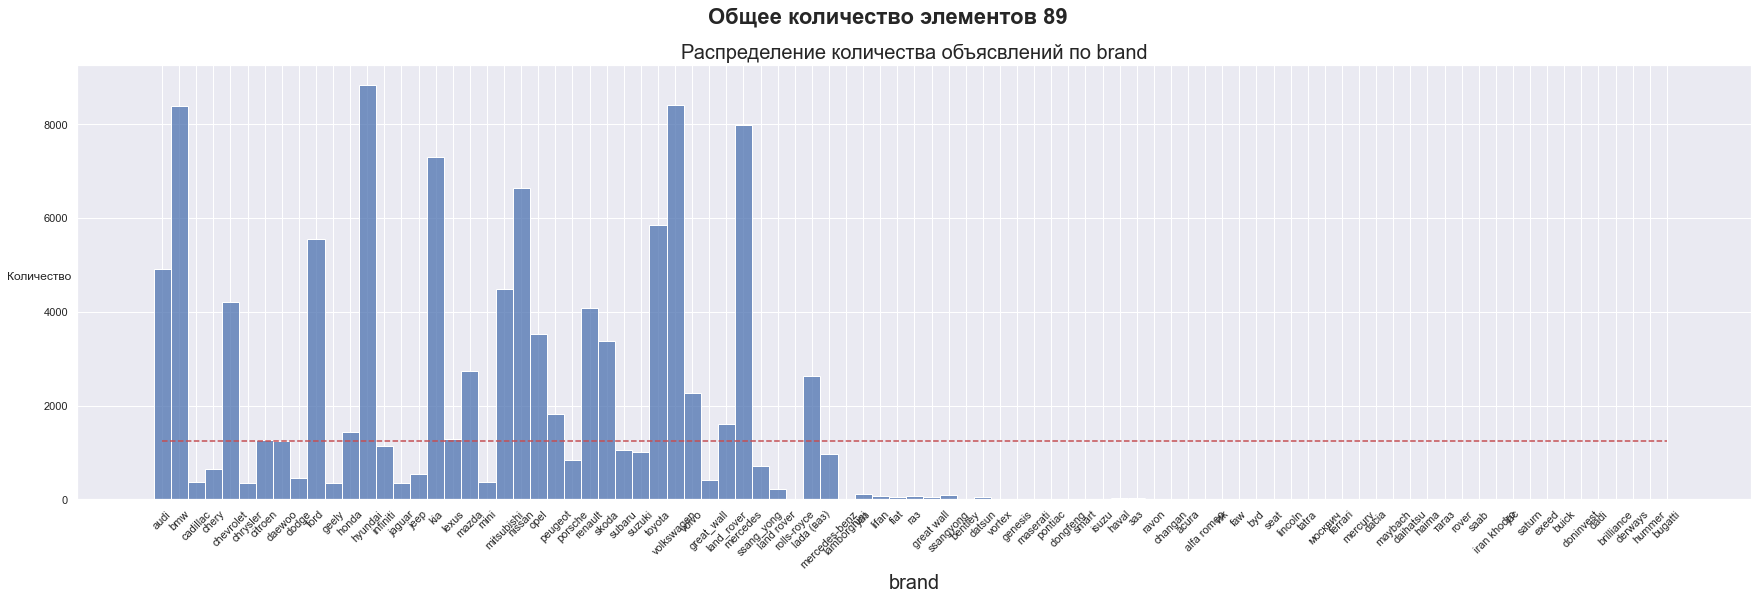

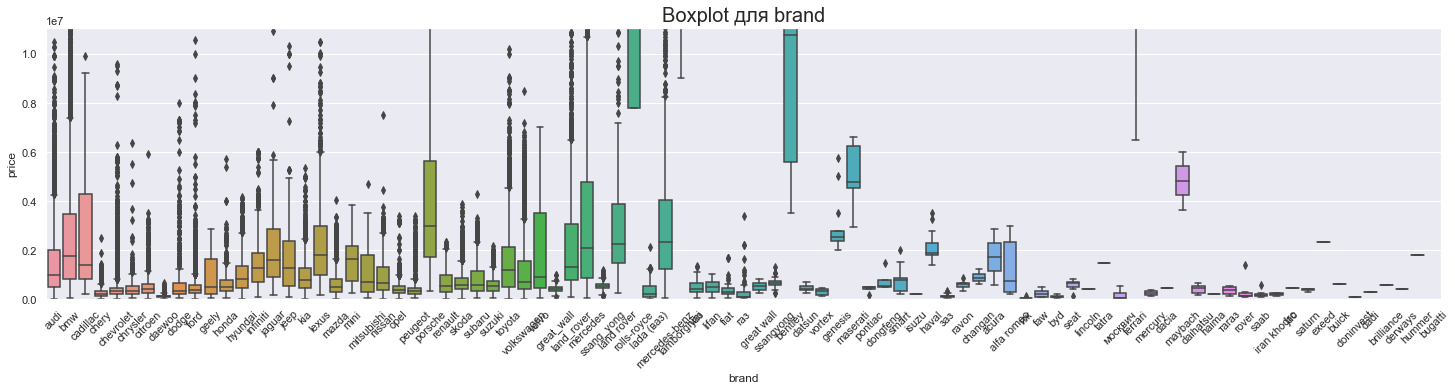

In [483]:
analiz_catigarial_feature(data, 'brand', 1)

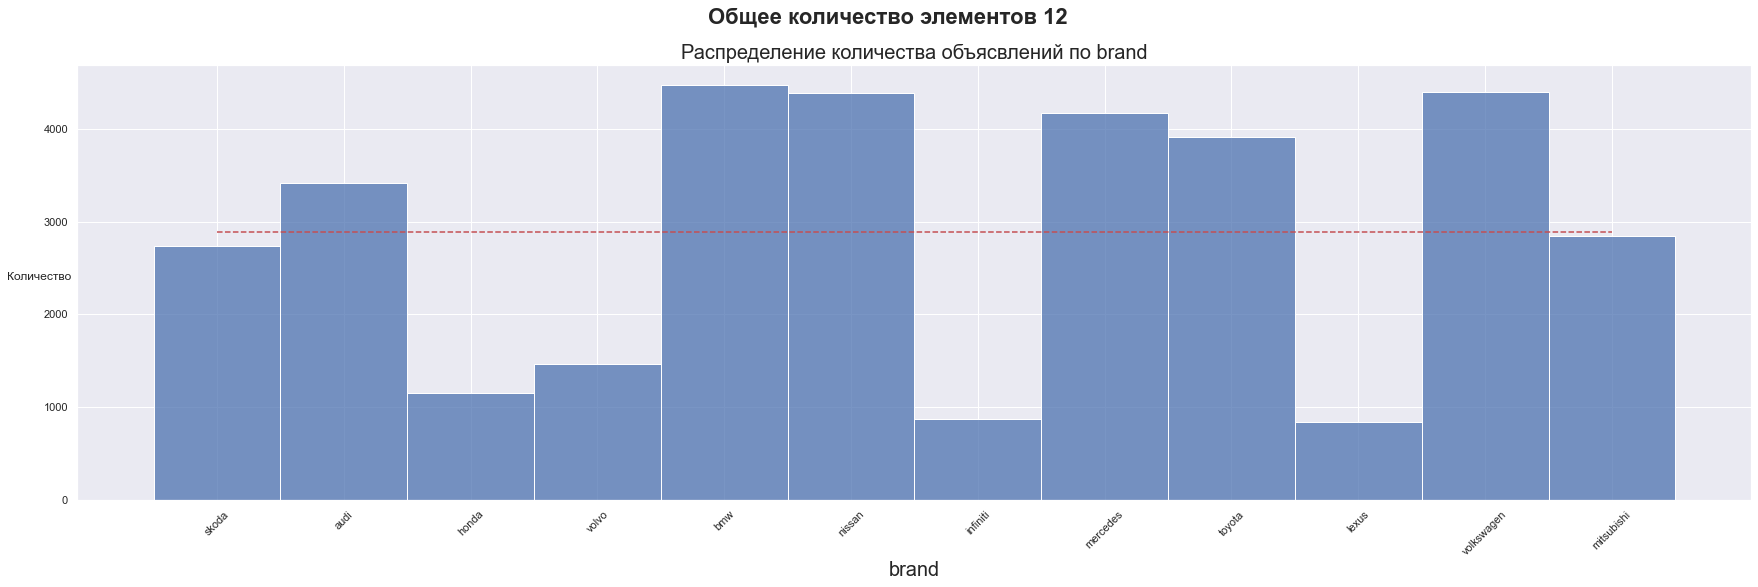

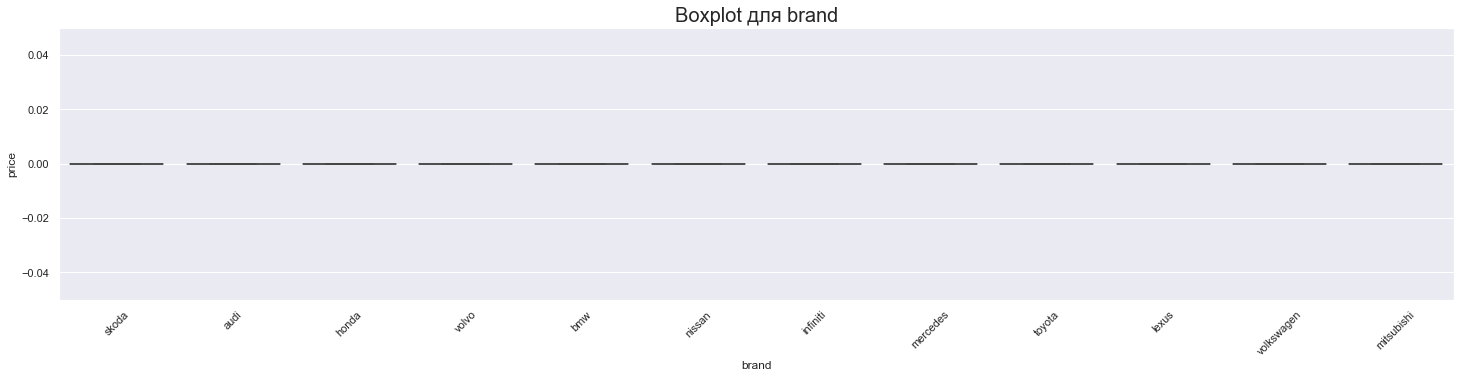

In [484]:
analiz_catigarial_feature(data, 'brand', 0)

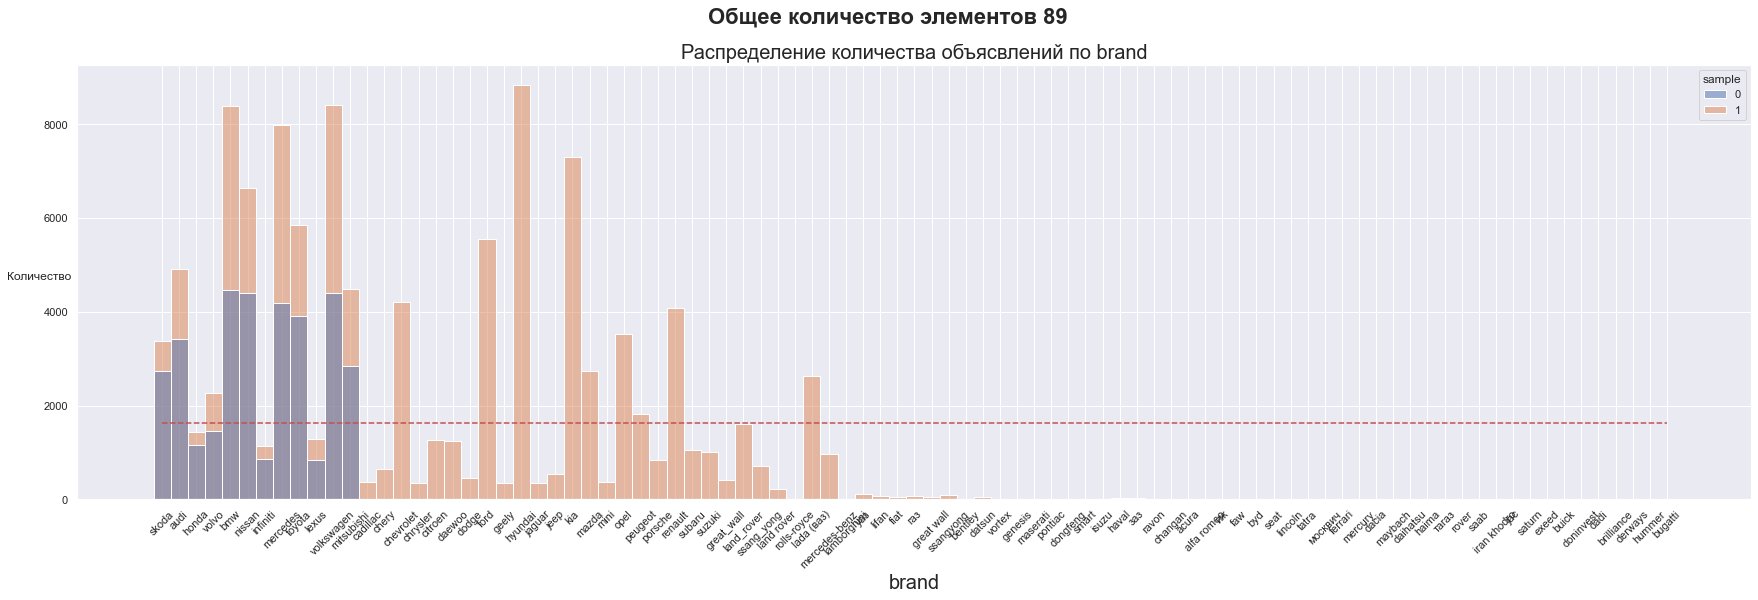

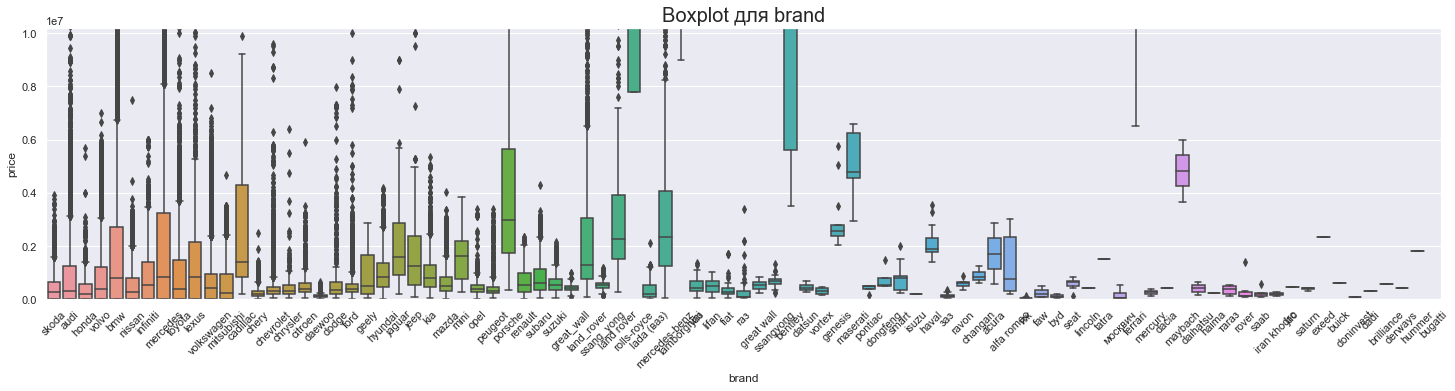

In [485]:
analiz_catigarial_feature(data, 'brand', 2)

**Вывод**: пропусков в признае нет, признак brand распределен неравномерно. В test представдены всего 12 брендов.
Представим этот признак как категориальный 

# bodyType 
- тип кузова 

In [486]:
getEmptyValue(data, 'bodyType')

Количество уникальных значений для train 25
Количество пропусков значений   для train0
Количество уникальных значений для test 24
Количество пропусков значений   для test 0


In [487]:
definePopularColumn(data, 'bodyType', 1)

{'внедорожник 5 дв.': 40310,
 'седан': 39182,
 'хэтчбек 5 дв.': 11603,
 'универсал 5 дв.': 4390,
 'лифтбек': 4196,
 'минивэн': 2698,
 'компактвэн': 2361,
 'хэтчбек 3 дв.': 2082,
 'купе': 1700,
 'пикап двойная кабина': 662}

In [488]:
definePopularColumn(data, 'bodyType', 0)

{'седан': 13147,
 'внедорожник 5 дв.': 12228,
 'лифтбек': 2232,
 'хэтчбек 5 дв.': 2124,
 'универсал 5 дв.': 1276,
 'минивэн': 995,
 'купе': 824,
 'компактвэн': 489,
 'хэтчбек 3 дв.': 485,
 'пикап двойная кабина': 280}

In [489]:
defineDiffPopularCol(data, 'bodyType')

Значений которых нет в test Но есть в train
{'хэтчбек 4 дв.', 'спидстер'}
Значений которых нет в train Но есть в test
{'купе-хардтоп'}


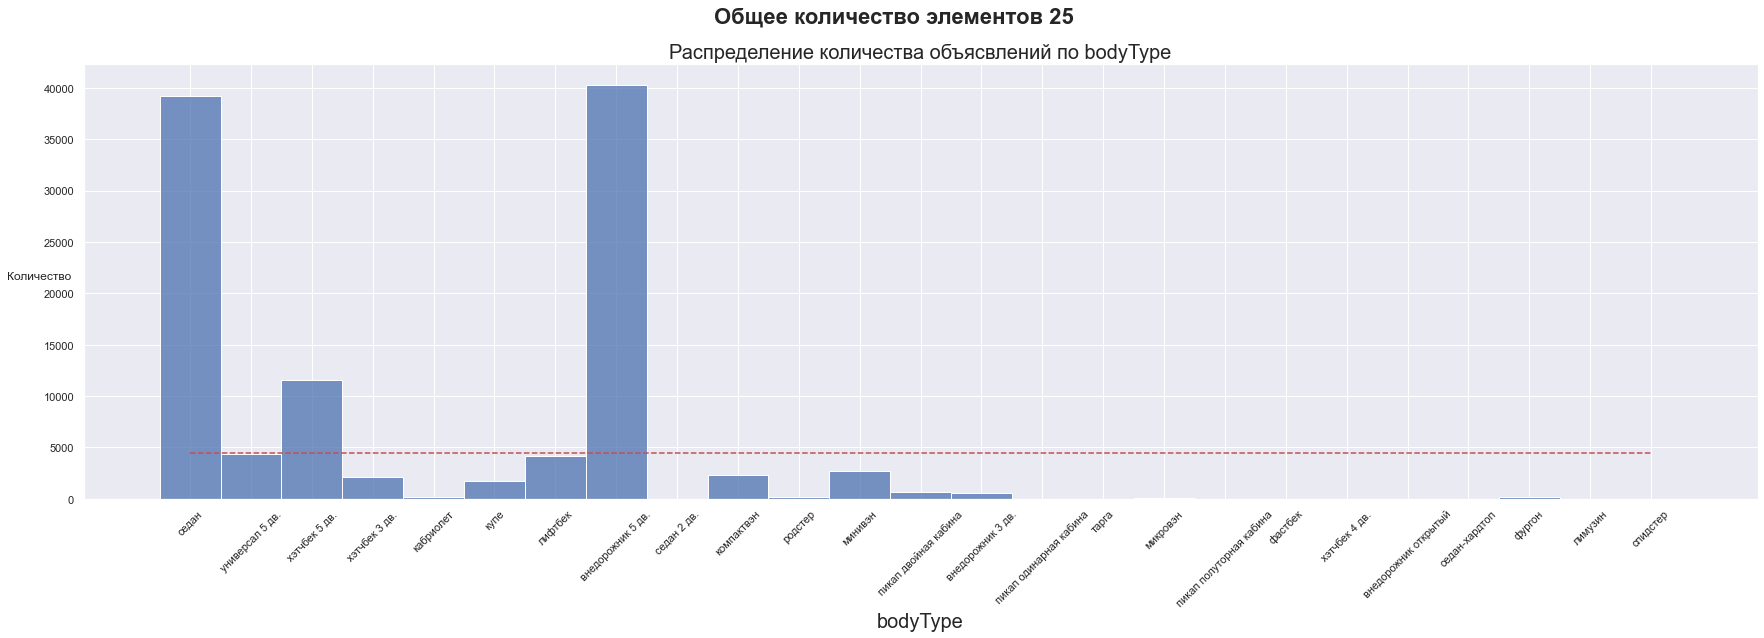

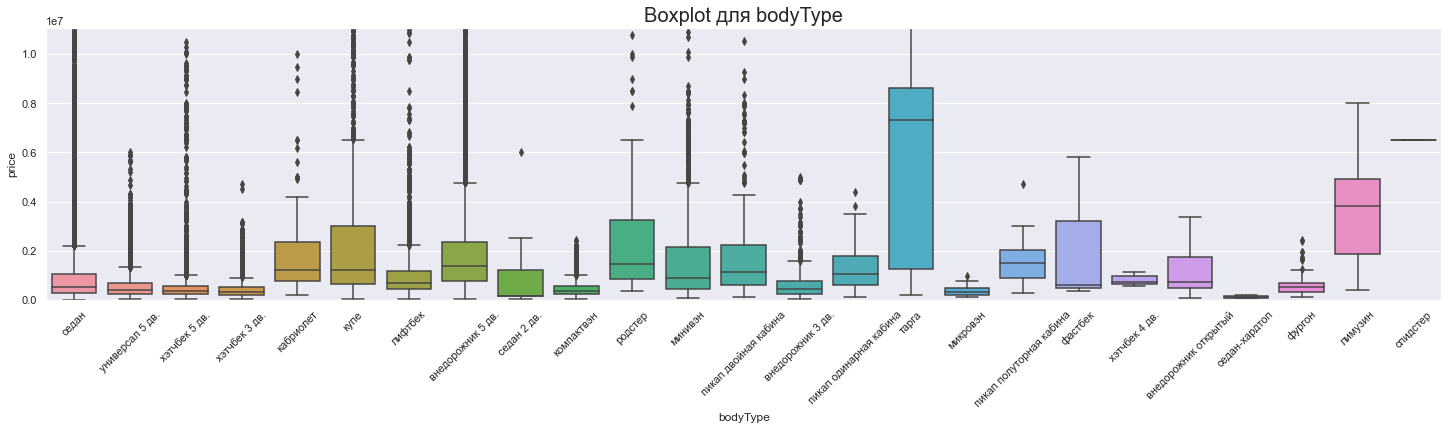

In [490]:
analiz_catigarial_feature(data, 'bodyType', 1)

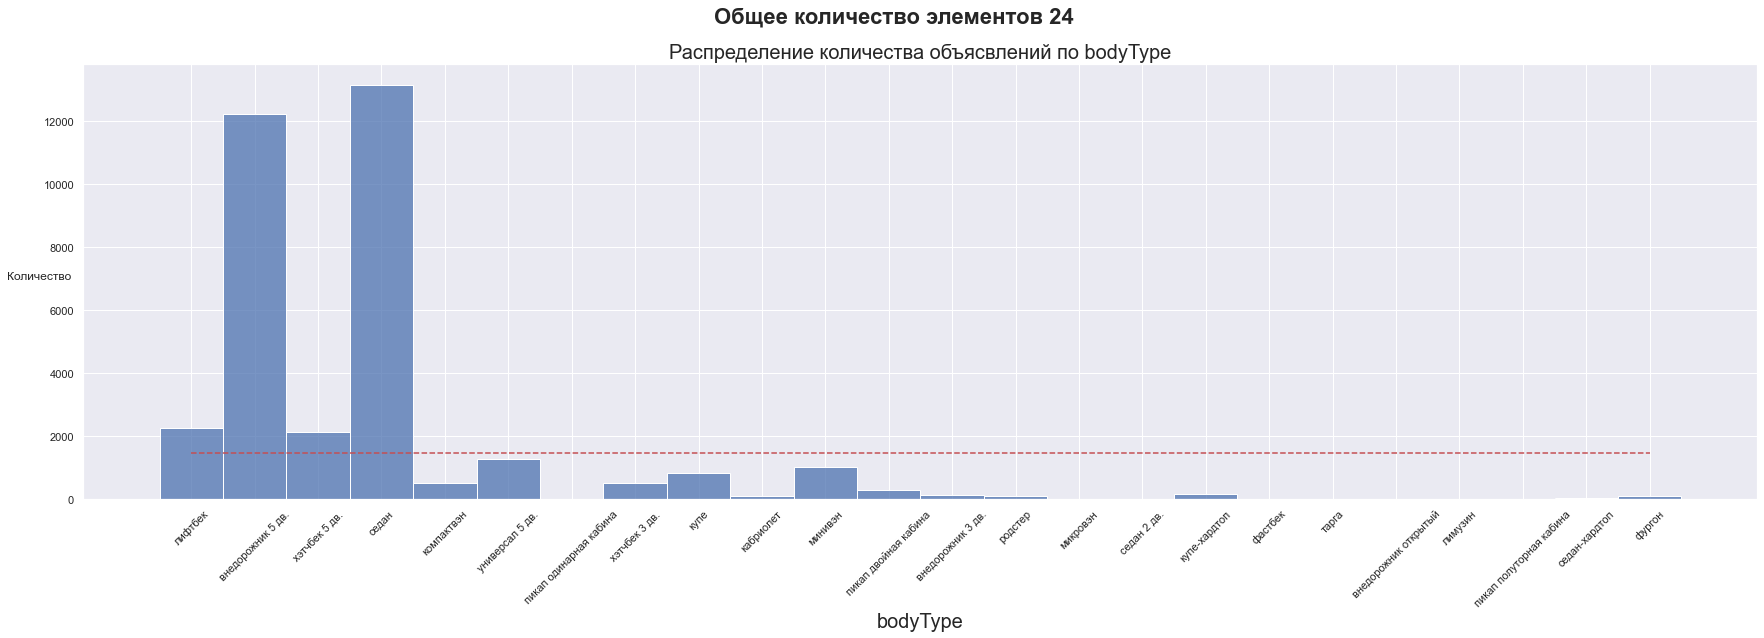

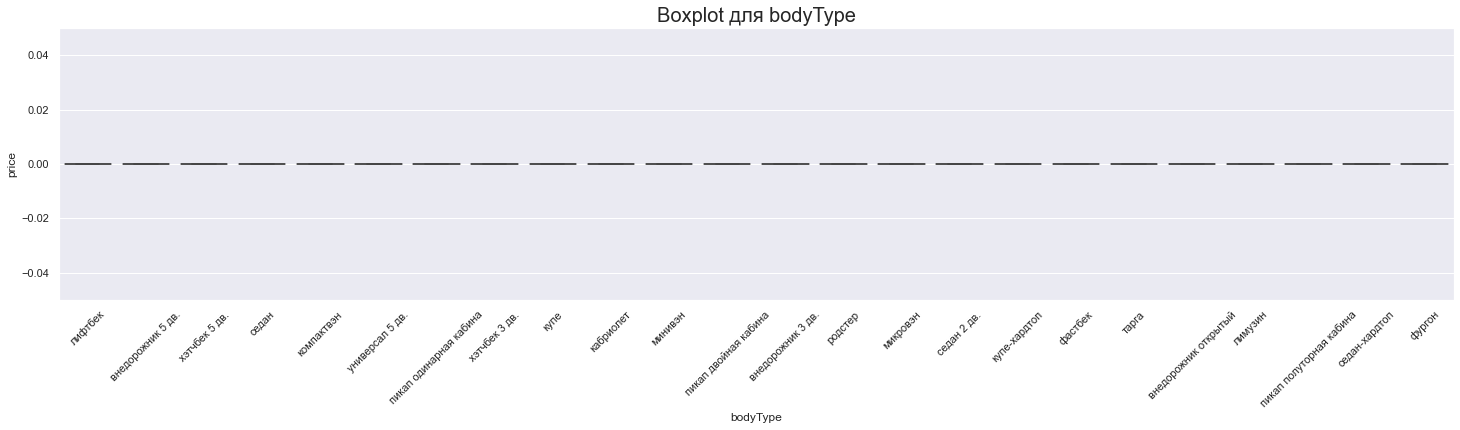

In [491]:
analiz_catigarial_feature(data, 'bodyType', 0)

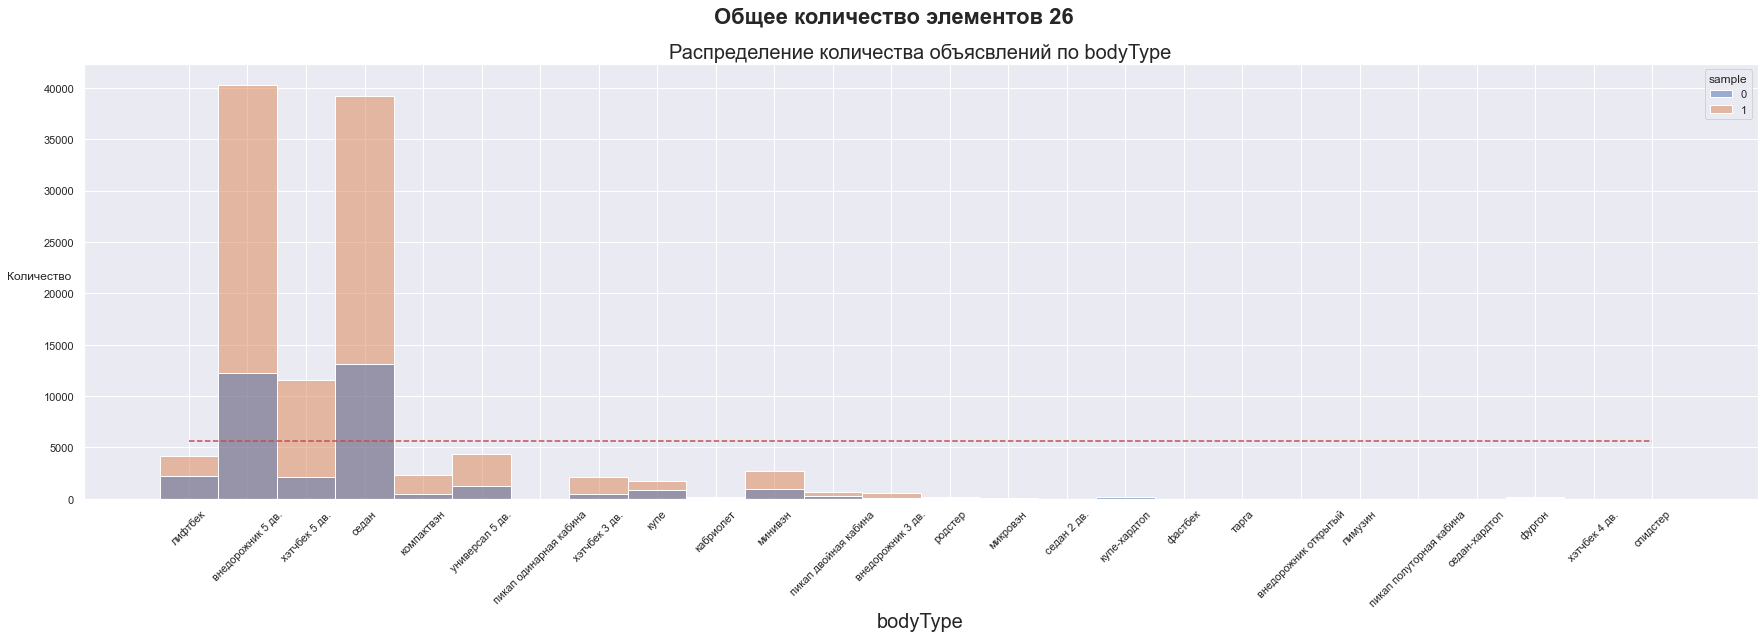

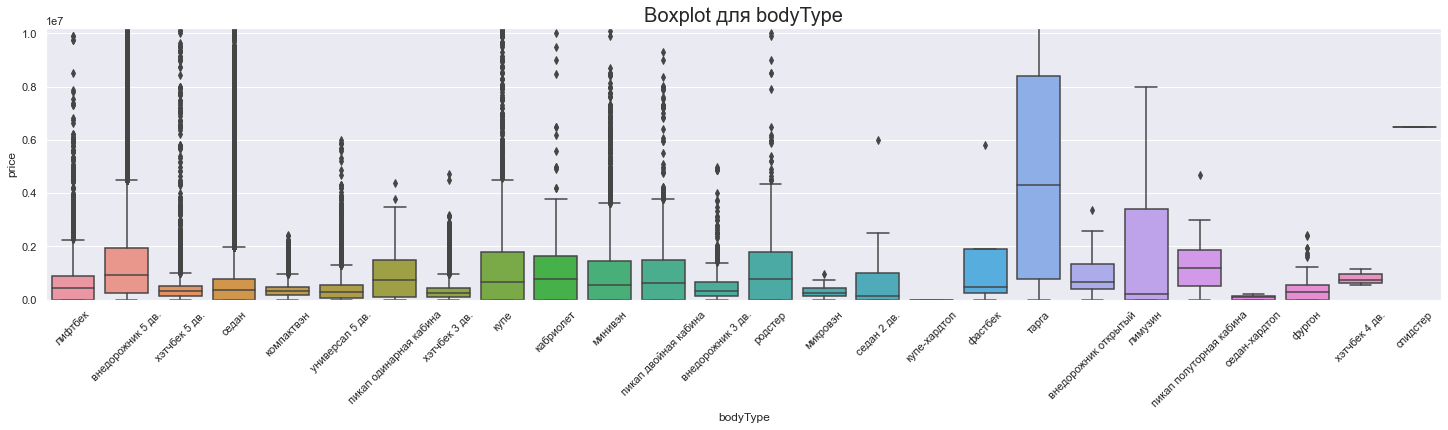

In [492]:
analiz_catigarial_feature(data, 'bodyType', 2)

**Вывод** - в тренировочной выборке представлены не все типы кузовов. Это связано с неполной выборкой и также присутсвует неравноменость выборки. Отнесем это признак к категориальному

# color

  цвет машины.


In [493]:
getEmptyValue(data, 'color')

Количество уникальных значений для train 16
Количество пропусков значений   для train0
Количество уникальных значений для test 16
Количество пропусков значений   для test 0


Часто встречающие цвета!

In [494]:
definePopularColumn(data, 'color', 1)

{'чёрный': 29751,
 'белый': 20201,
 'серый': 14013,
 'серебристый': 13908,
 'синий': 10722,
 'красный': 5668,
 'коричневый': 4761,
 'зелёный': 3231,
 'бежевый': 2364,
 'голубой': 1657}

In [495]:
definePopularColumn(data, 'color', 0)

{'чёрный': 11010,
 'белый': 6133,
 'серебристый': 4113,
 'серый': 3984,
 'синий': 3289,
 'красный': 1531,
 'коричневый': 1501,
 'зелёный': 952,
 'бежевый': 639,
 'голубой': 457}

In [496]:
defineDiffPopularCol(data, 'color')

Значений которых нет в test Но есть в train
set()
Значений которых нет в train Но есть в test
set()


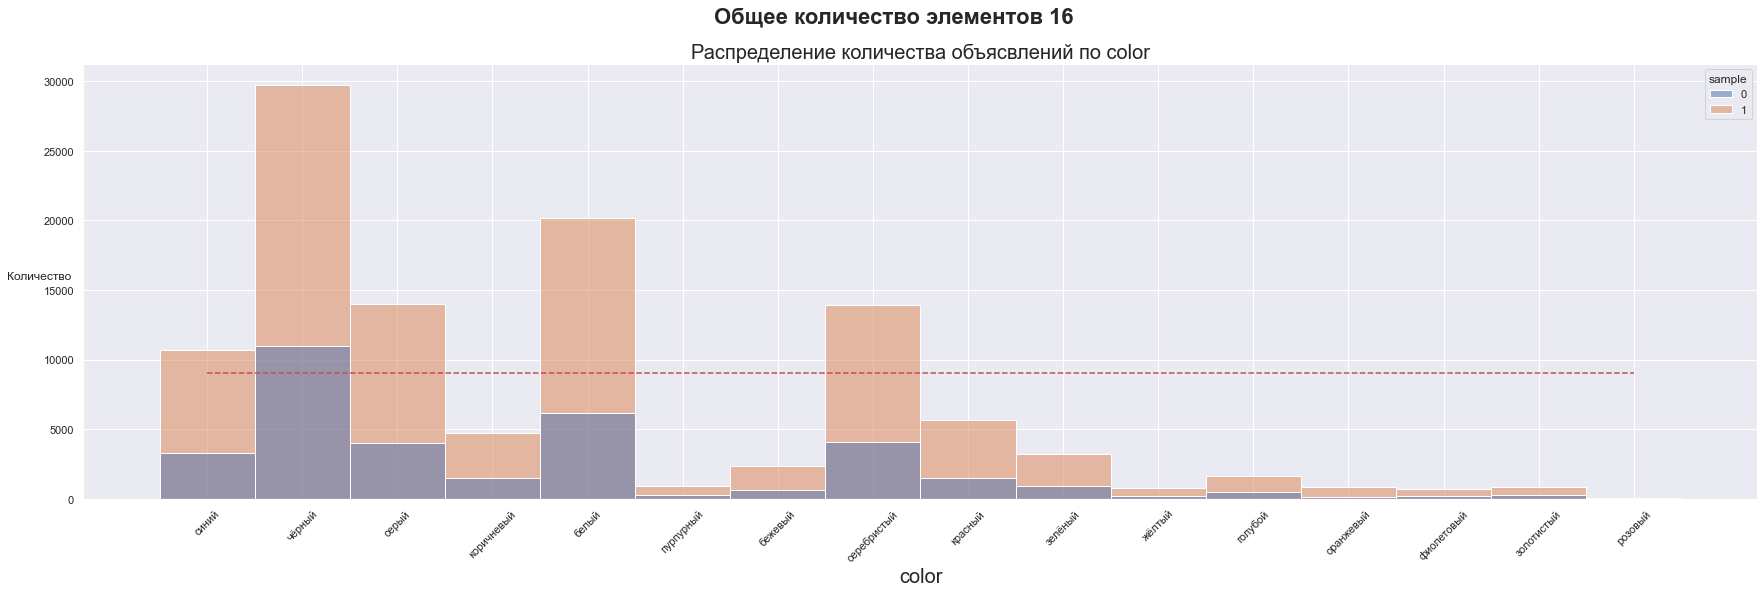

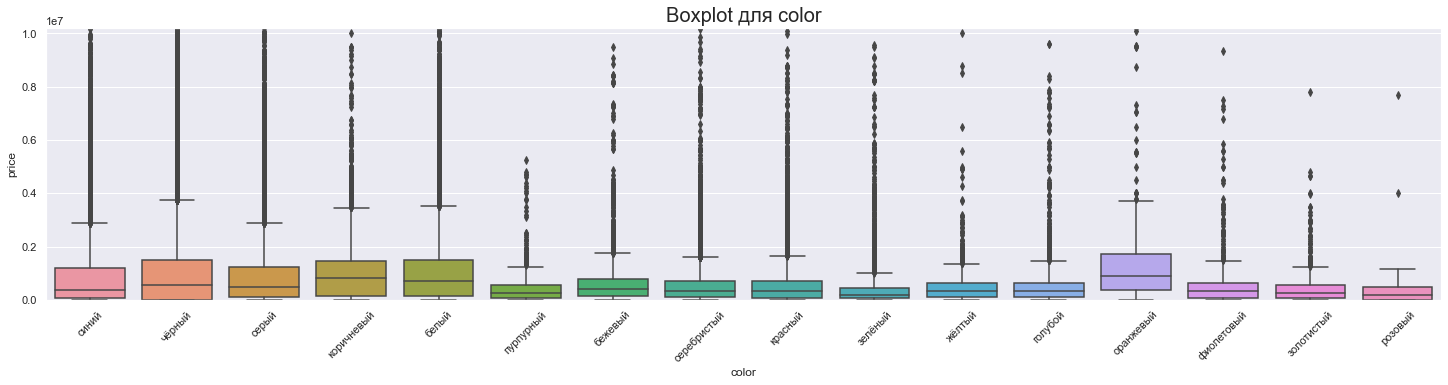

In [497]:
analiz_catigarial_feature(data, 'color', 2)

**Вывод** в train присутствут все цвета , которые есть в test. Представим как категориальный признак

# fuelType
тип топлива

In [498]:
getEmptyValue(data, 'fuelType')

Количество уникальных значений для train 6
Количество пропусков значений   для train0
Количество уникальных значений для test 5
Количество пропусков значений   для test 0


In [499]:
definePopularColumn(data, 'fuelType', 1)

{'бензин': 93349,
 'дизель': 16519,
 'гибрид': 363,
 'бензин. газобаллонное оборудование': 189,
 'газ': 14,
 'электро': 2}

In [500]:
definePopularColumn(data, 'fuelType', 0)

{'бензин': 28601, 'дизель': 5800, 'гибрид': 223, 'электро': 55, 'газ': 7}

In [501]:
defineDiffPopularCol(data, 'fuelType')

Значений которых нет в test Но есть в train
{'бензин. газобаллонное оборудование'}
Значений которых нет в train Но есть в test
set()


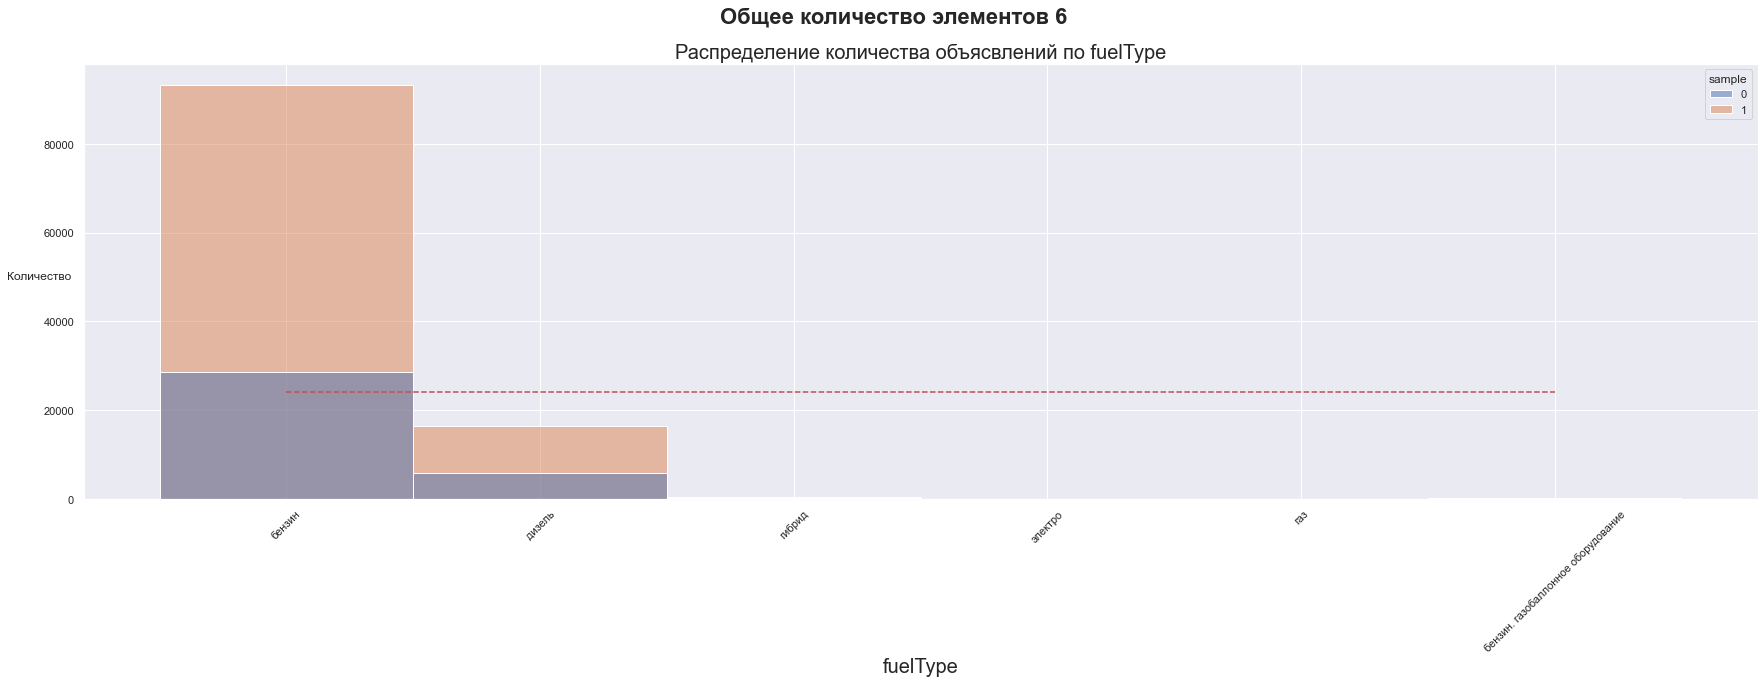

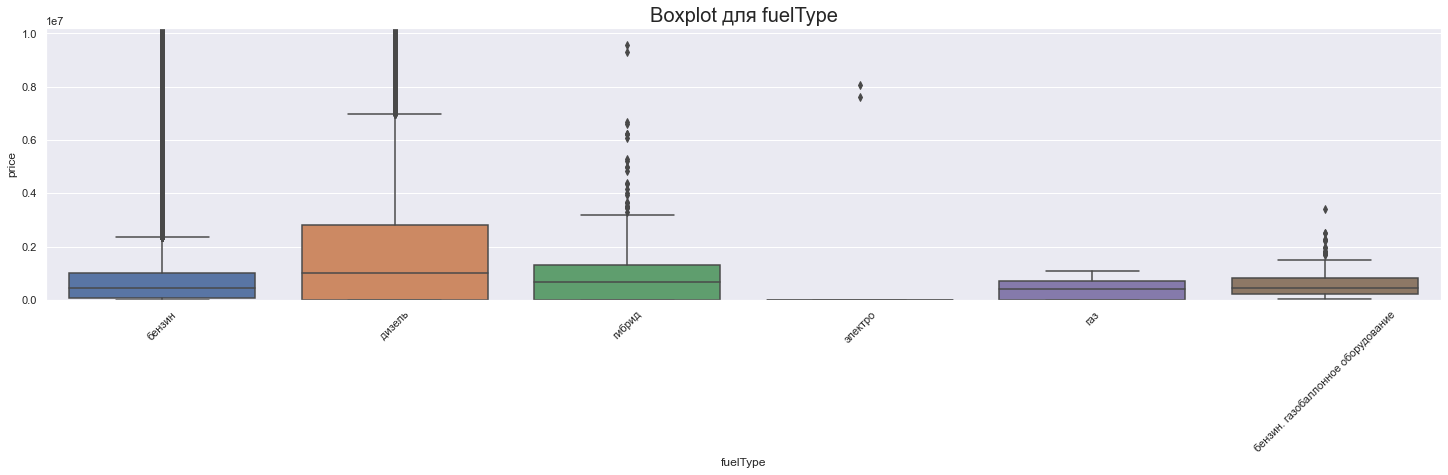

In [502]:
analiz_catigarial_feature(data, 'fuelType', 2)

**Вывод** - по рисункам видно, что машины на  бензине дешевле чем на дизиле. Пример как категориальный признак

# vehicleTransmission
- тип передачи

In [503]:
getEmptyValue(data, 'vehicleTransmission')

Количество уникальных значений для train 4
Количество пропусков значений   для train0
Количество уникальных значений для test 4
Количество пропусков значений   для test 0


In [504]:
definePopularColumn(data, 'vehicleTransmission', 0)

{'автомат': 19596, 'механика': 7209, 'вариатор': 3999, 'робот': 3882}

In [505]:
defineDiffPopularCol(data, 'vehicleTransmission')

Значений которых нет в test Но есть в train
set()
Значений которых нет в train Но есть в test
set()


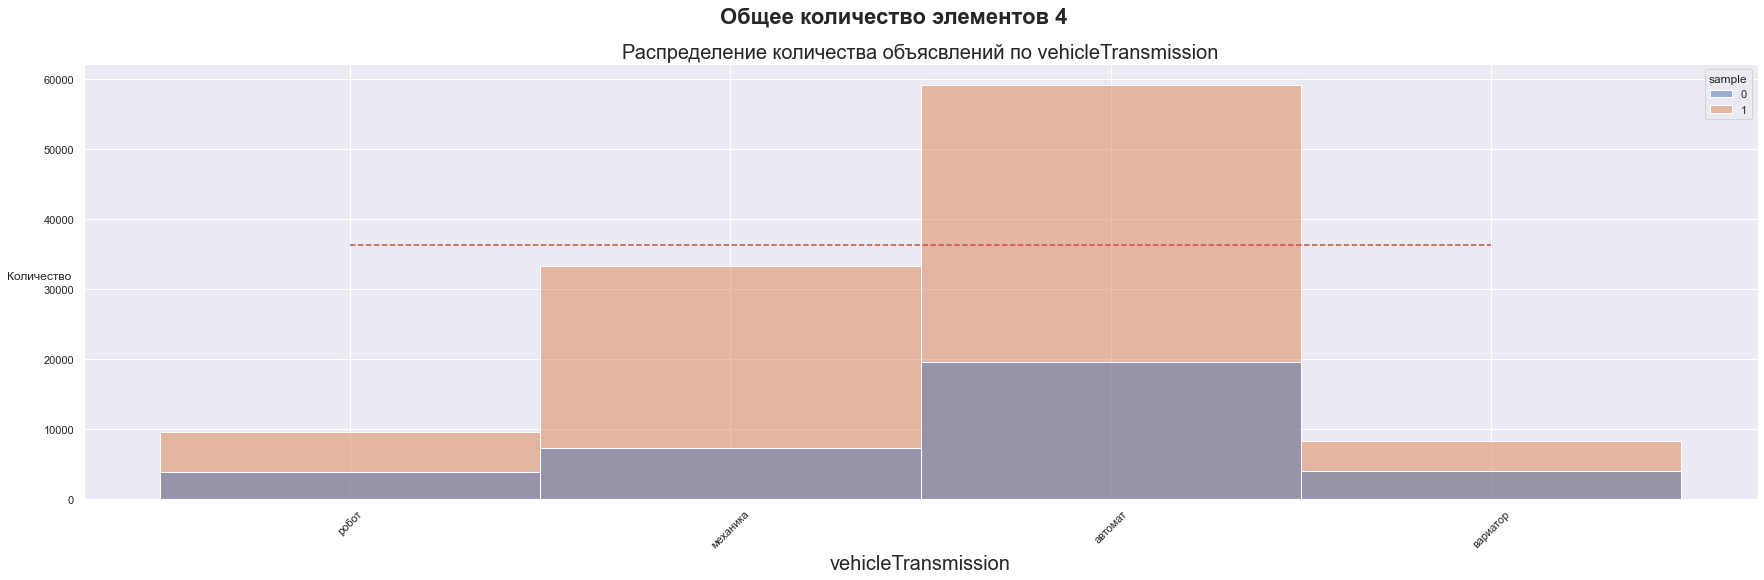

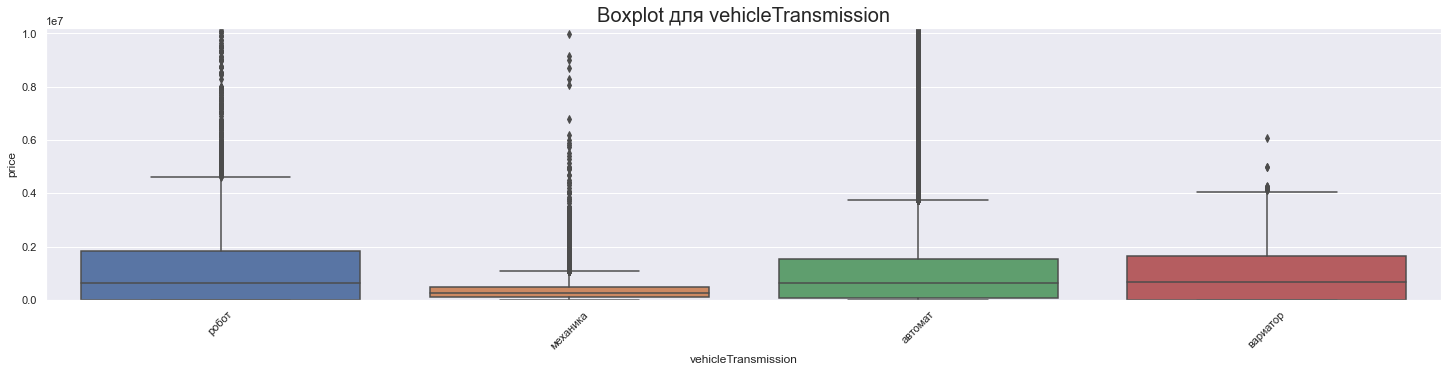

In [506]:
analiz_catigarial_feature(data, 'vehicleTransmission', 2)

**Вывод** - в целом механика дешевле всех. разные признаки имеют разные доверительные интервалы по ценам - что позволит отличать их между собой. Примем как категориальный тип

# drivertrain 
привод

In [507]:
getEmptyValue(data, 'drivertrain')

Количество уникальных значений для train 3
Количество пропусков значений   для train0
Количество уникальных значений для test 3
Количество пропусков значений   для test 0


In [508]:
definePopularColumn(data, 'drivertrain', 1)

{'передний': 59825, 'полный': 42344, 'задний': 8267}

In [509]:
defineDiffPopularCol(data, 'drivertrain')

Значений которых нет в test Но есть в train
set()
Значений которых нет в train Но есть в test
set()


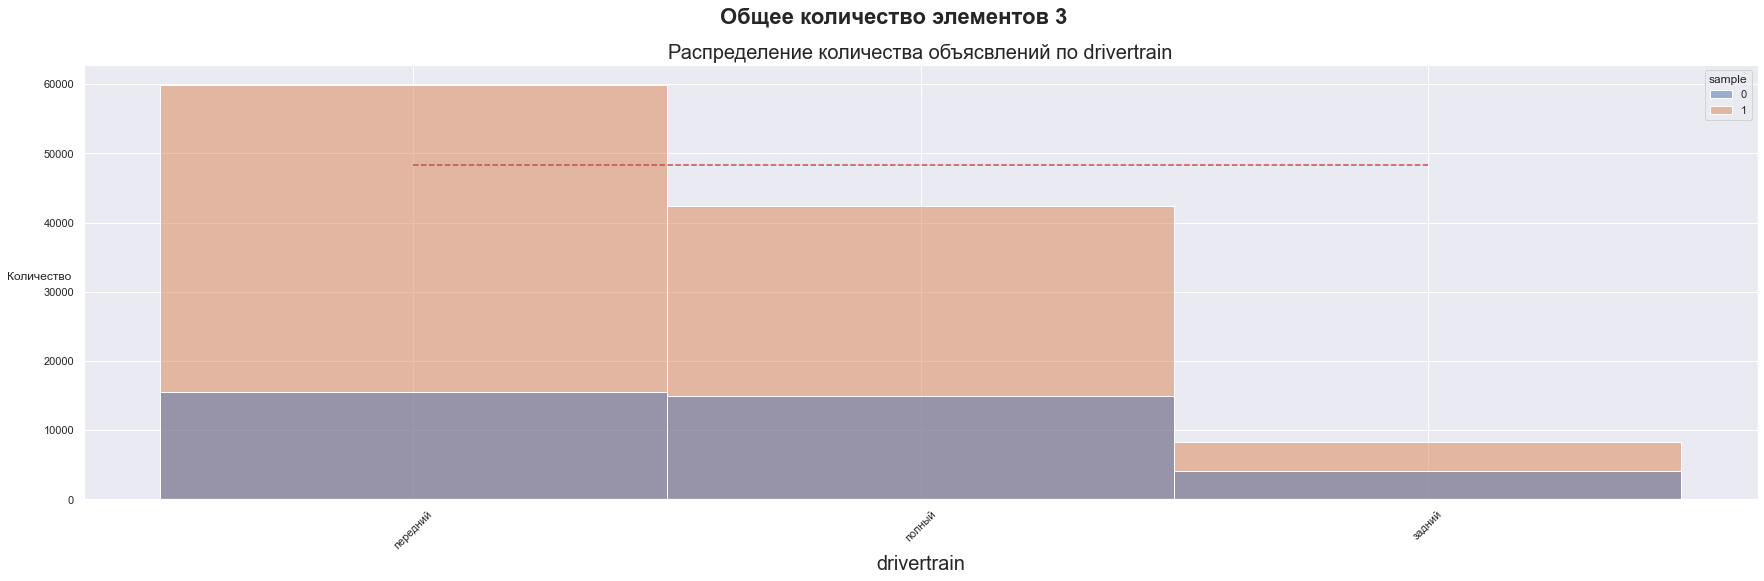

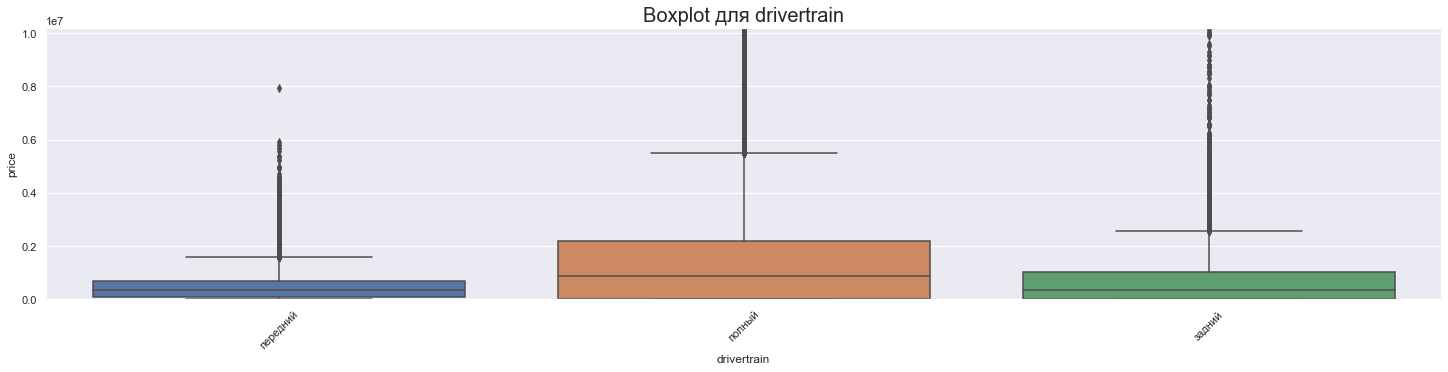

In [510]:
analiz_catigarial_feature(data, 'drivertrain', 2)

**Вывод** - в целом передний привод дешевле всех, полный привод заметно дороже. Примем его как категориальный признак

# vendor
производитель

In [511]:
getEmptyValue(data, 'vendor')

Количество уникальных значений для train 6
Количество пропусков значений   для train0
Количество уникальных значений для test 2
Количество пропусков значений   для test 0


In [512]:
definePopularColumn(data, 'vendor', 1)

{'EUROPEAN': 50590,
 'JAPANESE': 25689,
 'ASIAN': 19794,
 'AMERICAN': 11485,
 'RUSSIAN': 2875,
 'ARABIC': 3}

In [513]:
defineDiffPopularCol(data, 'vendor')

Значений которых нет в test Но есть в train
{'RUSSIAN', 'ASIAN', 'AMERICAN', 'ARABIC'}
Значений которых нет в train Но есть в test
set()


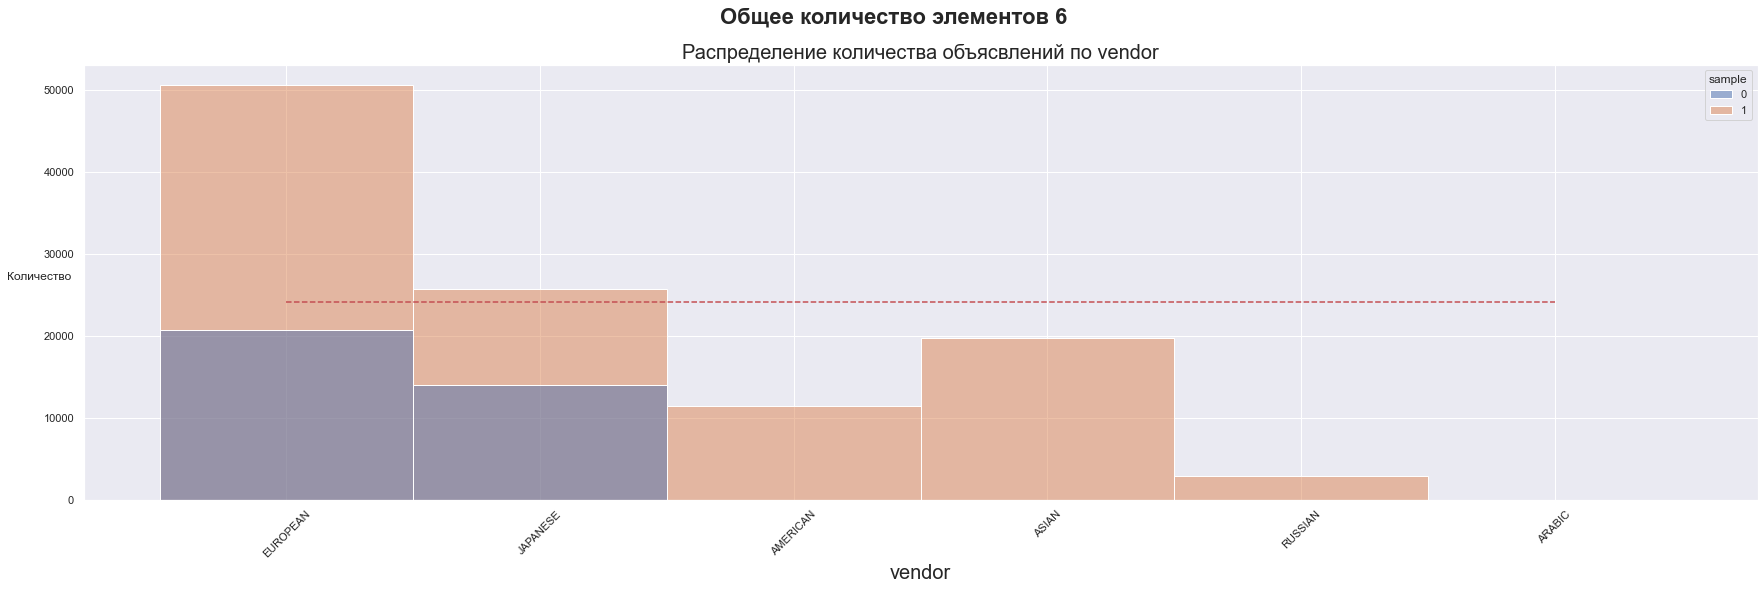

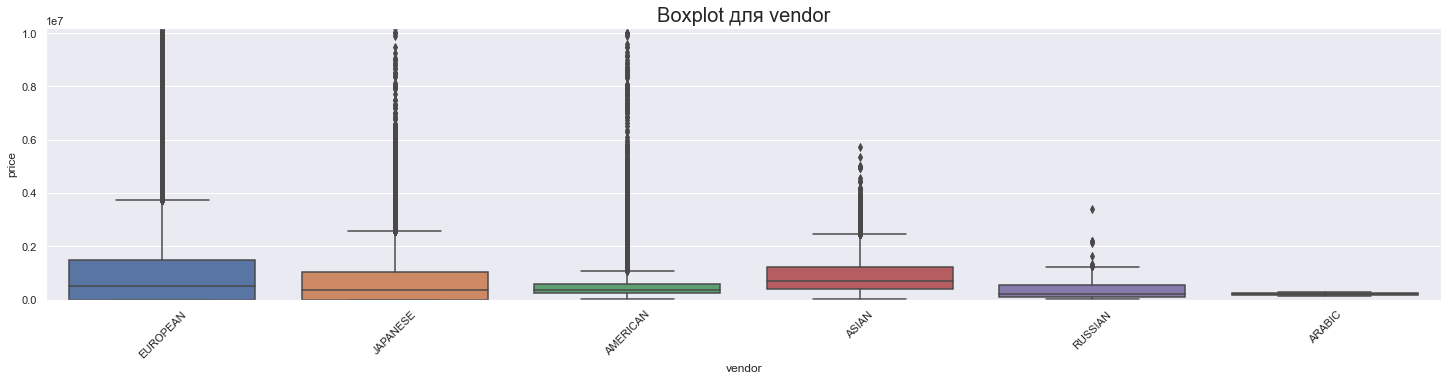

In [514]:
analiz_catigarial_feature(data, 'vendor', 2)

**Вывод** - в целом график показывает что реально русские машины самые дешевые! Примем его за категориальный признак

# ownersCount 
количество владельцев



In [515]:
getEmptyValue(data, 'ownersCount')

Количество уникальных значений для train 4
Количество пропусков значений   для train0
Количество уникальных значений для test 3
Количество пропусков значений   для test 0


In [516]:
definePopularColumn(data, 'ownersCount', 1)

{'three more': 43370, 'two': 25354, 'one': 24964, 'non': 16748}

In [517]:
defineDiffPopularCol(data, 'ownersCount')

Значений которых нет в test Но есть в train
{'non'}
Значений которых нет в train Но есть в test
set()


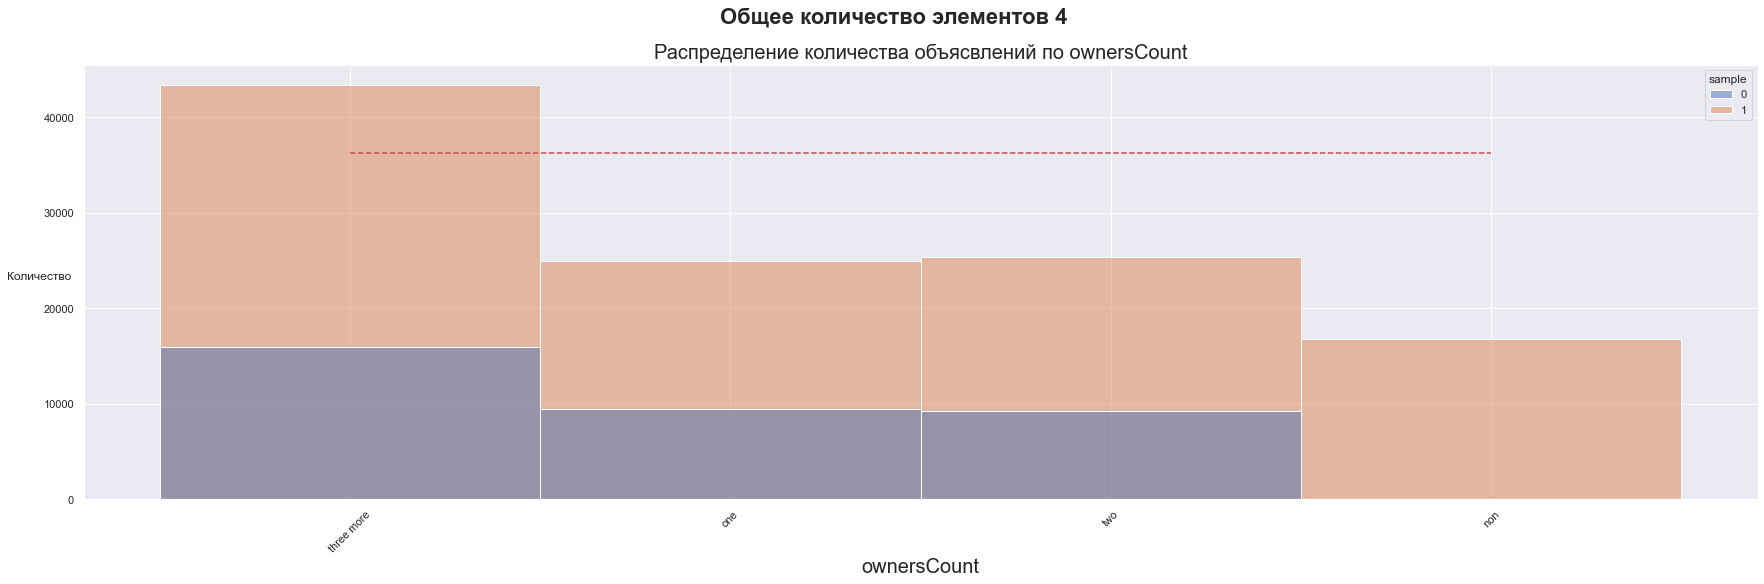

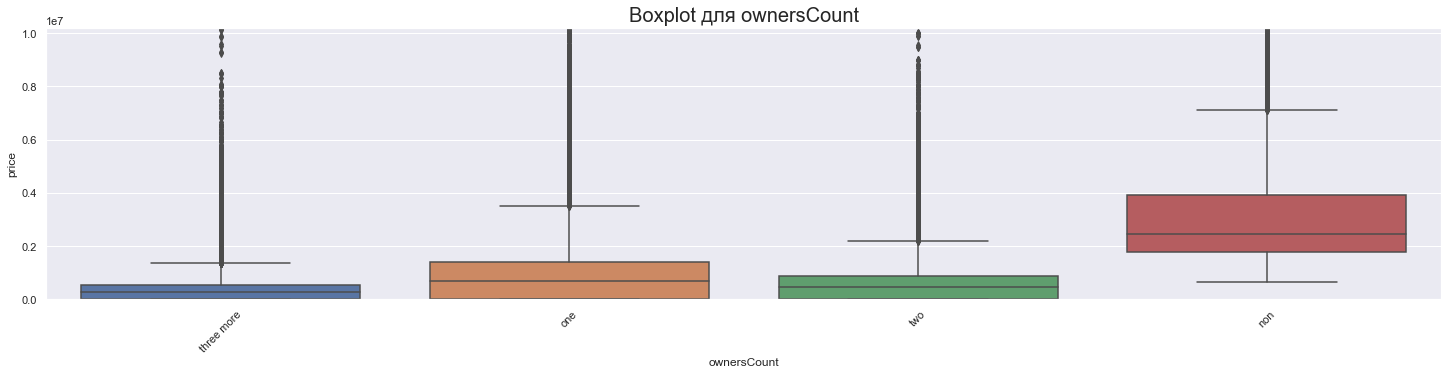

In [518]:
analiz_catigarial_feature(data, 'ownersCount', 2)

**Вывод** - с ростом количества владельцев цена уменьшается. Примем его за категориальный признак

# numberOfDoors 
    количество дверей

In [519]:
getEmptyValue(data, 'numberOfDoors')

Количество уникальных значений для train 5
Количество пропусков значений   для train0
Количество уникальных значений для test 5
Количество пропусков значений   для test 0


In [520]:
definePopularColumn(data, 'numberOfDoors', 1)

{5: 64479, 4: 41071, 3: 2741, 2: 2144, 0: 1}

In [521]:
defineDiffPopularCol(data, 'numberOfDoors')

Значений которых нет в test Но есть в train
set()
Значений которых нет в train Но есть в test
set()


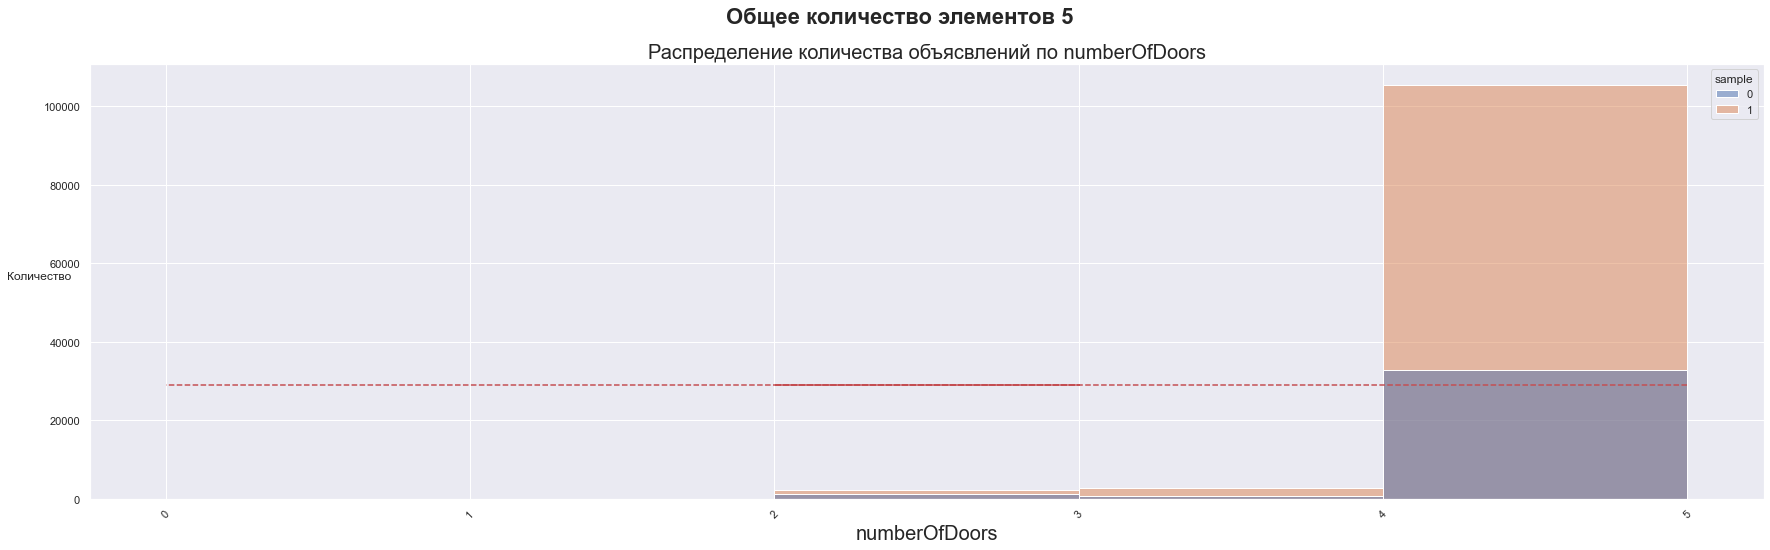

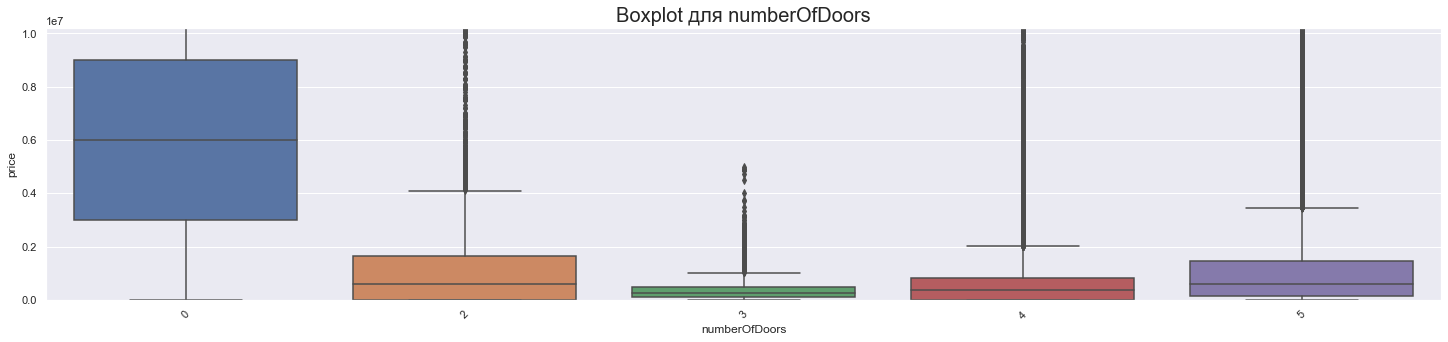

In [522]:
analiz_catigarial_feature(data, 'numberOfDoors', 2)

In [523]:
data = data[data['numberOfDoors'] != 0]

In [524]:
definePopularColumn(data, 'numberOfDoors', 1)

{5: 64479, 4: 41071, 3: 2741, 2: 2144}

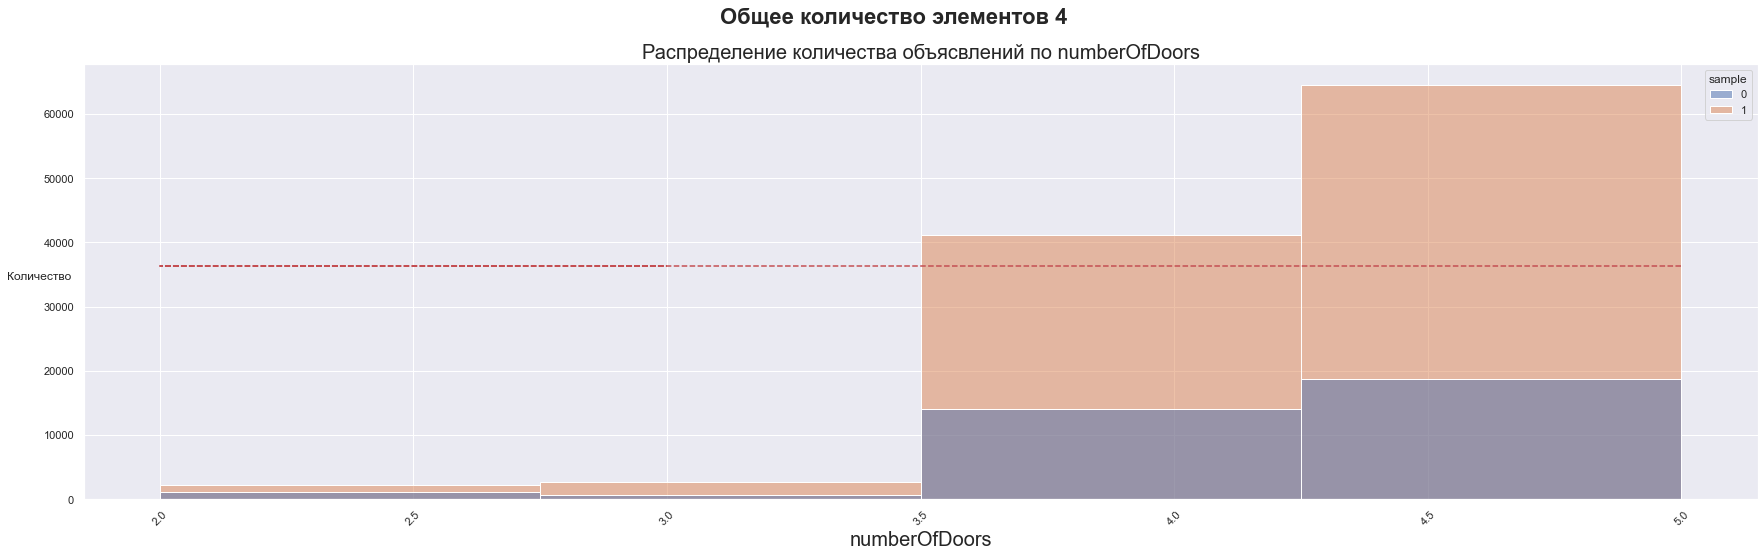

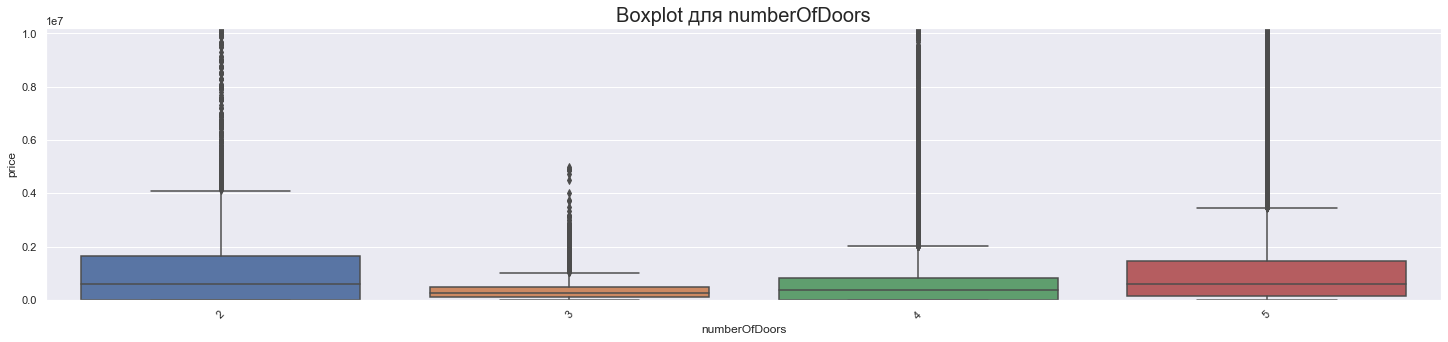

In [525]:
analiz_catigarial_feature(data, 'numberOfDoors', 2)

**Вывод** - удалим из признака значения 0 как ошибочное. примем данное значение как категориальное! 

# Числовые признаки

## modelDate
дата модели авто

In [526]:
def analis_number_scatterplot(date, col):
    fig, axes = plt.subplots(figsize=(30, 8))

    sns.scatterplot(x=col, y="price", data=date)
    plt.xticks(rotation=45)
    plt.xlabel(col, fontsize=20)
    plt.title('распределенеи по годам - ' + col, fontsize=20)
    plt.show()

def analis_number_boxplot(data, col):
    fig, axes = plt.subplots(figsize=(30, 8))
    sns.boxplot(data[col])
    plt.xticks(rotation=45)
    plt.xlabel(col, fontsize=20)
    plt.title('boxplot - ' + col, fontsize=20)
    plt.show()

def analiz_number_feature(data, col, sample = 1):
    
    if sample == 0 or sample == 1:
        train = data.query('sample == ' + str(sample))
    else:
        train = data
    fig, axes = plt.subplots(figsize=(30, 8))

    sns.distplot(train[col])
    plt.xticks(rotation=45)
    plt.xlabel(col, fontsize=20)
    plt.ylabel('Кол.', rotation='horizontal', fontsize=20)
    plt.title('Распределение  числового признака - ' + col, fontsize=20)
    plt.show()
    analis_number_boxplot(train, col)
    analis_number_scatterplot(train, col)


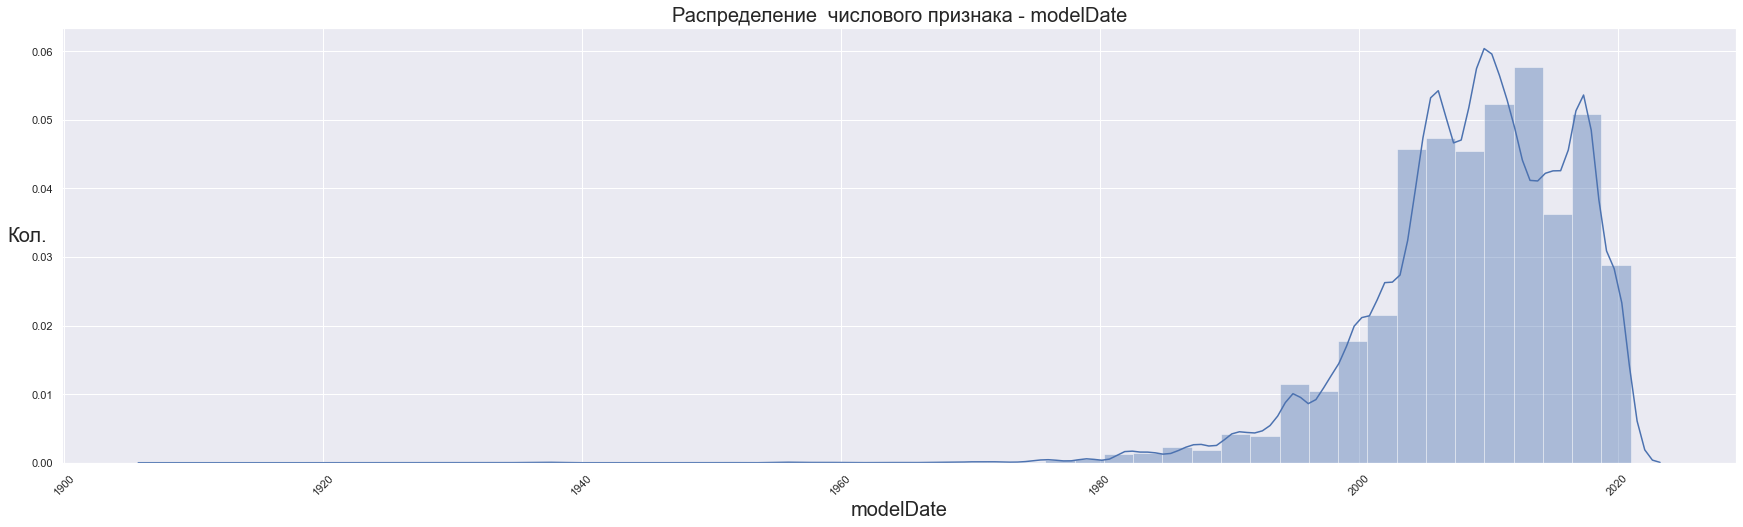

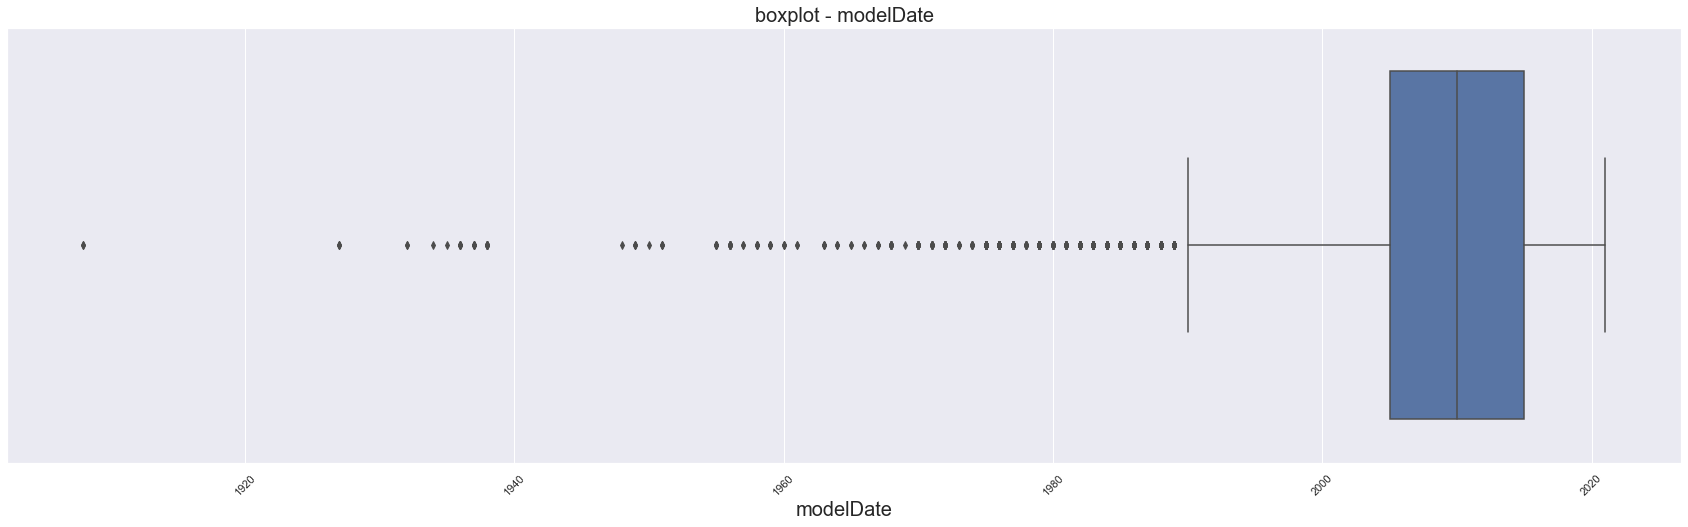

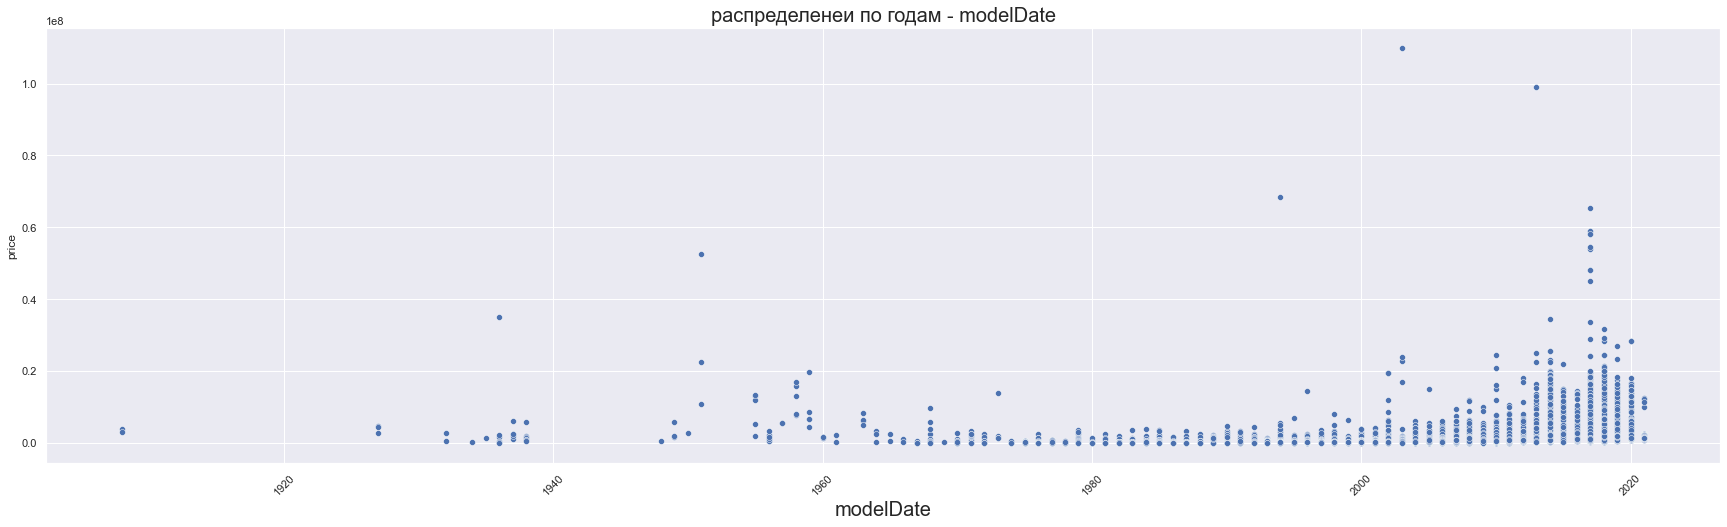

In [527]:
analiz_number_feature(data, 'modelDate', 1)

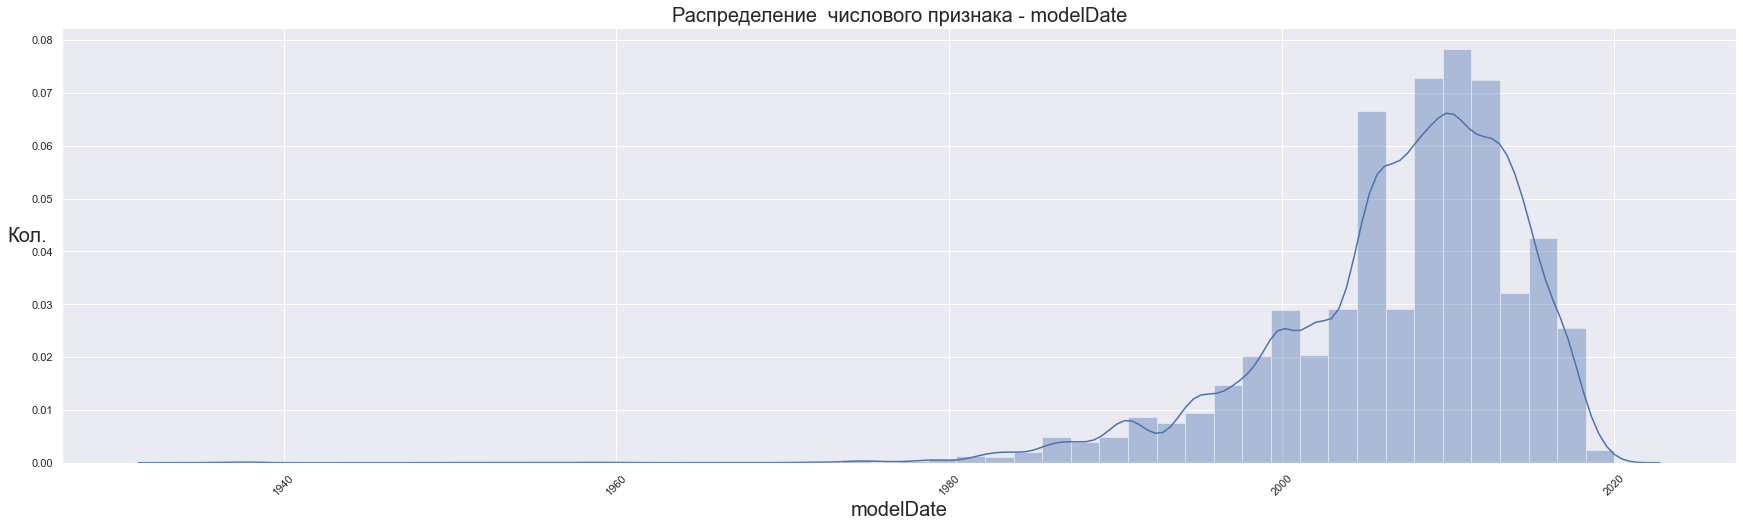

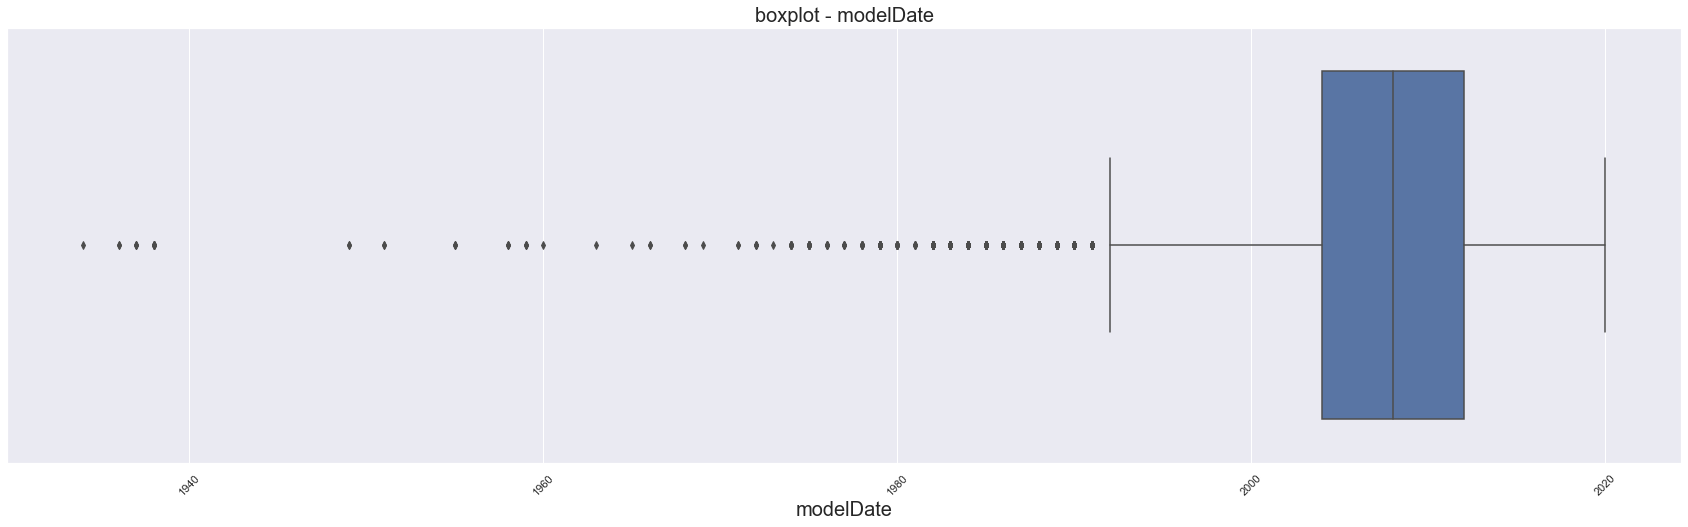

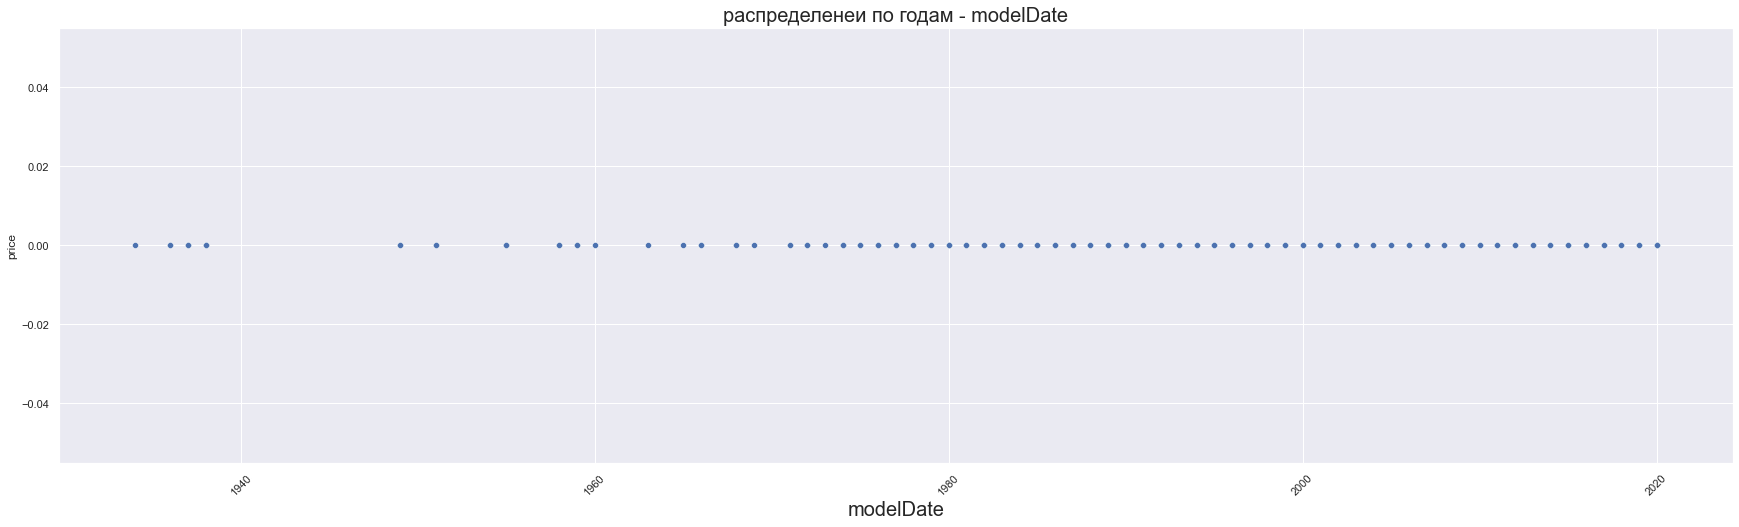

In [528]:
analiz_number_feature(data, 'modelDate', 0)

**Вывод** - modelDate будем использоват как числовой параметр
 
# productionDate

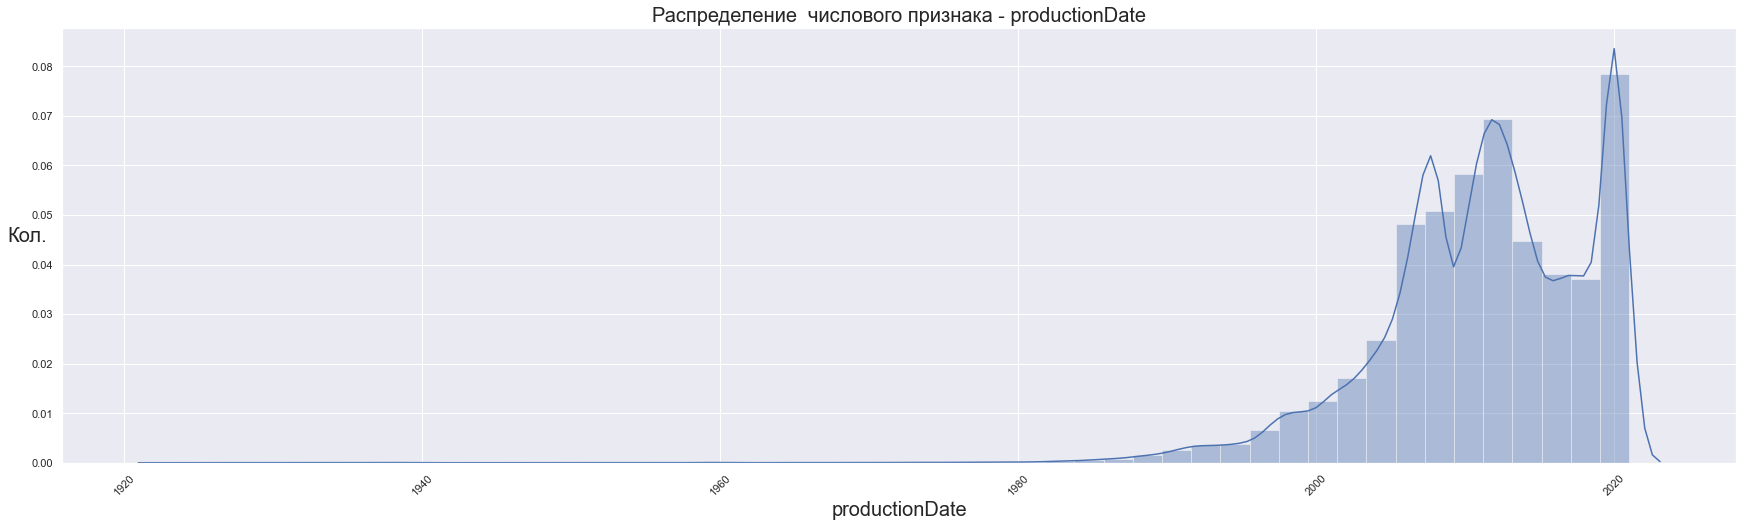

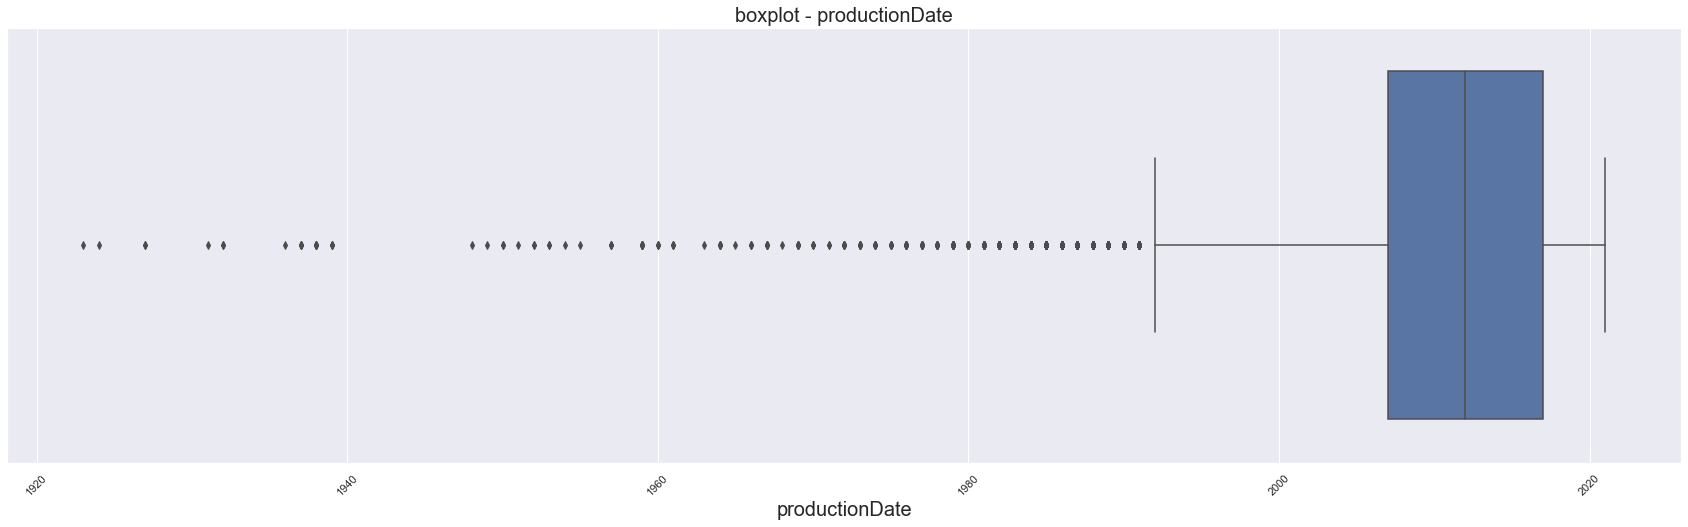

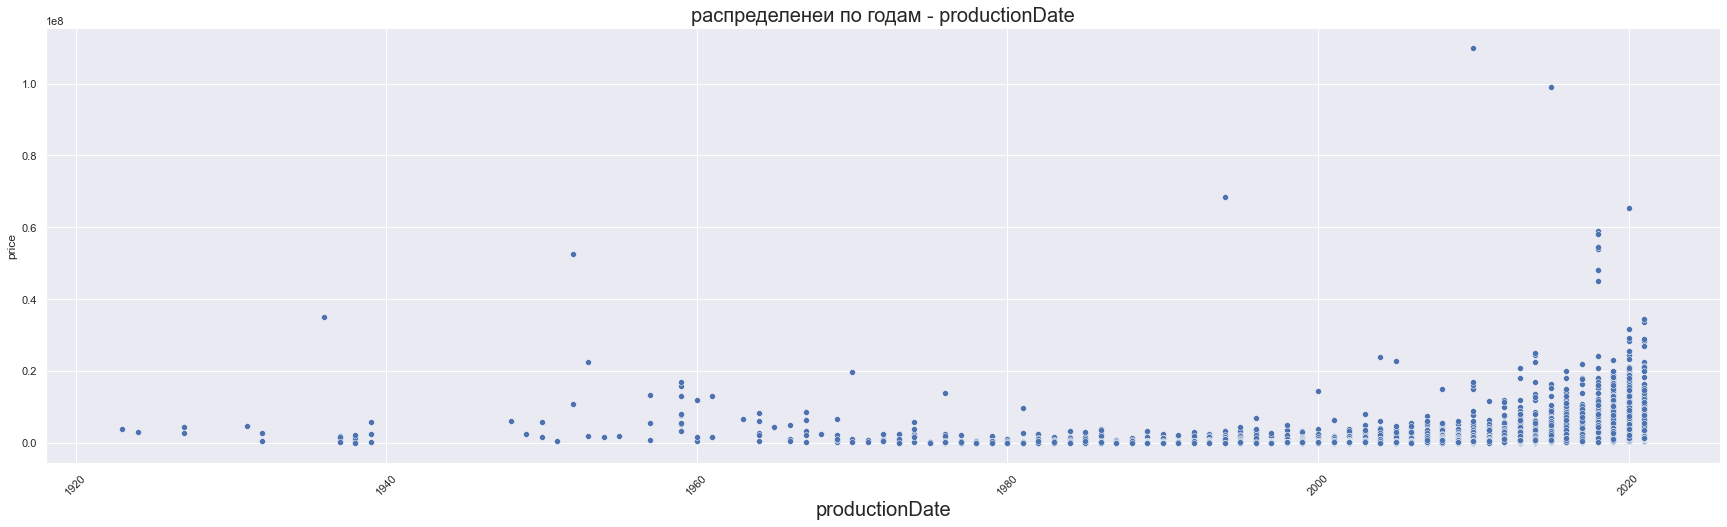

In [529]:
analiz_number_feature(data, 'productionDate', 1)

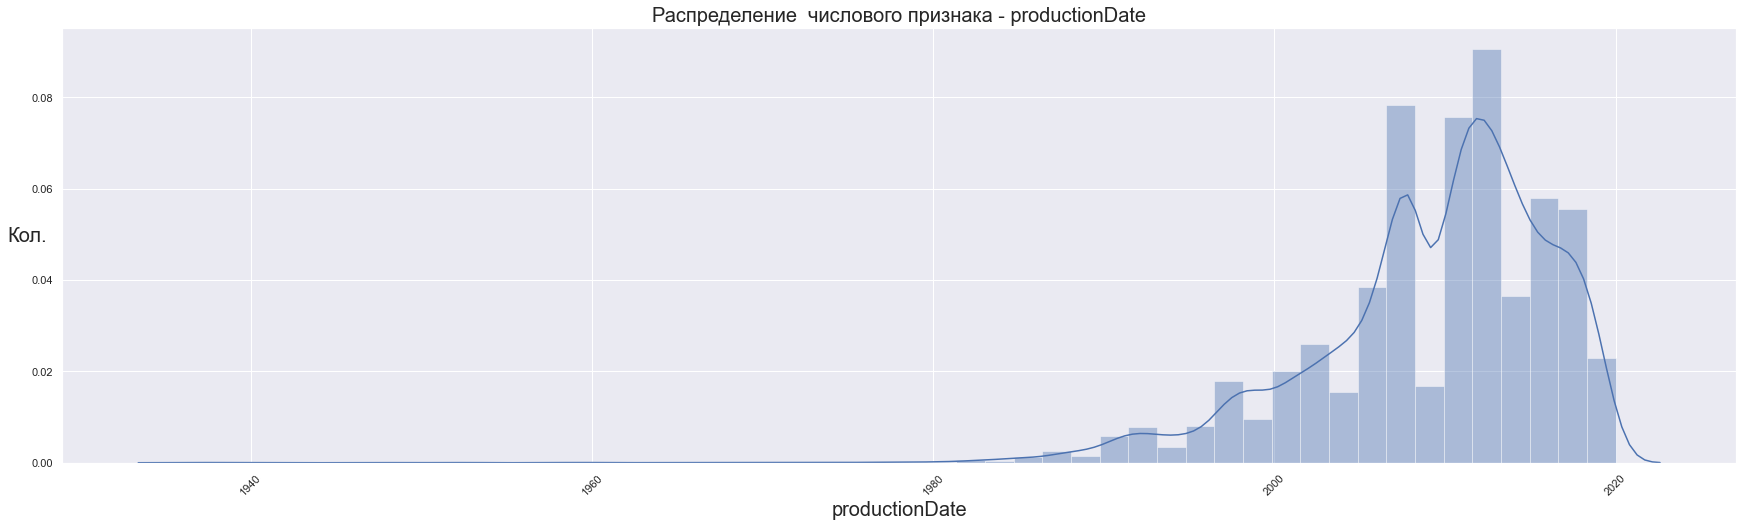

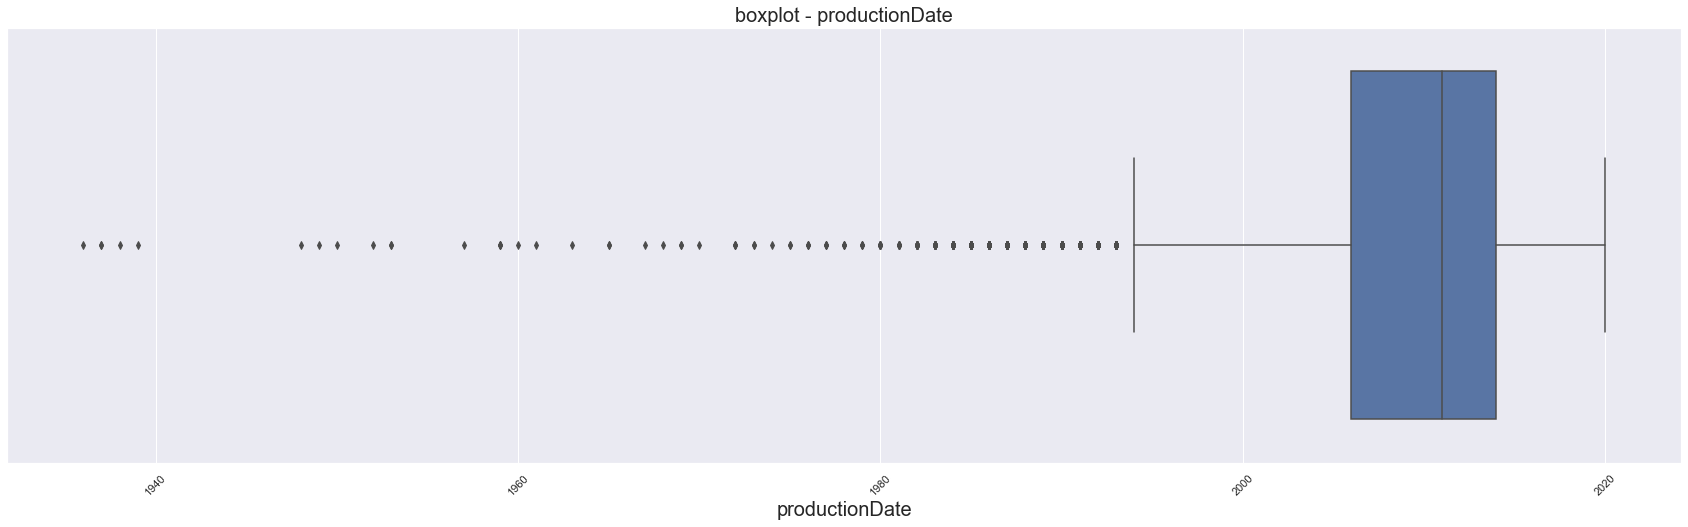

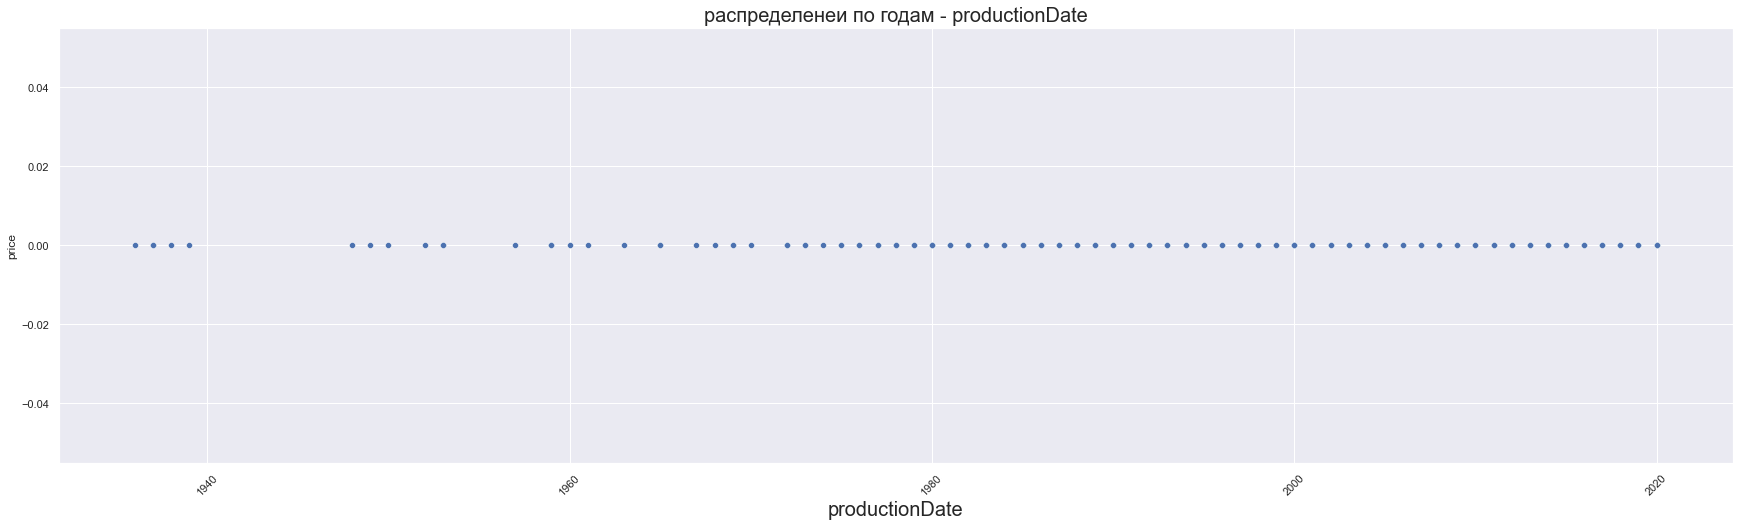

In [530]:
analiz_number_feature(data, 'productionDate', 0)

In [531]:
train[train['productionDate'] < 1950][['bodyType', 'vendor', 'price']]

bodyType    vendor       price
302            седан  EUROPEAN   2000000.0
5802     седан 2 дв.  EUROPEAN   1000000.0
5803     седан 2 дв.  EUROPEAN   2500000.0
5804     седан 2 дв.  EUROPEAN   6000000.0
5805     седан 2 дв.  EUROPEAN   2000000.0
5806           седан  EUROPEAN    440000.0
5807           седан  EUROPEAN   1700000.0
22540  хэтчбек 3 дв.  AMERICAN   4703812.0
22541  хэтчбек 3 дв.  AMERICAN   4500000.0
22542  хэтчбек 3 дв.  AMERICAN   2700000.0
22543      кабриолет  AMERICAN   3800000.0
22544      кабриолет  AMERICAN   3000000.0
23566          седан  AMERICAN   2700000.0
23567          седан  AMERICAN    480000.0
23568        фастбек  AMERICAN   5800000.0
51445          седан  EUROPEAN   2500000.0
53955          седан  EUROPEAN   1500000.0
54056          седан  EUROPEAN    210000.0
54057          седан  EUROPEAN    135000.0
61452  хэтчбек 3 дв.  EUROPEAN    300000.0
87551      кабриолет  EUROPEAN  12000000.0
88134          седан  EUROPEAN  35000000.0
88135          седан  EUROPEAN   2300000.0

**Вывод** - modelDate будем использоват как числовой параметр. Видно можно добавить признак раритетности авто.
 
# production_model
разница  в годах между производством авто и годом ее модели

In [532]:
data['production_model'] = data['productionDate'] - data['modelDate']

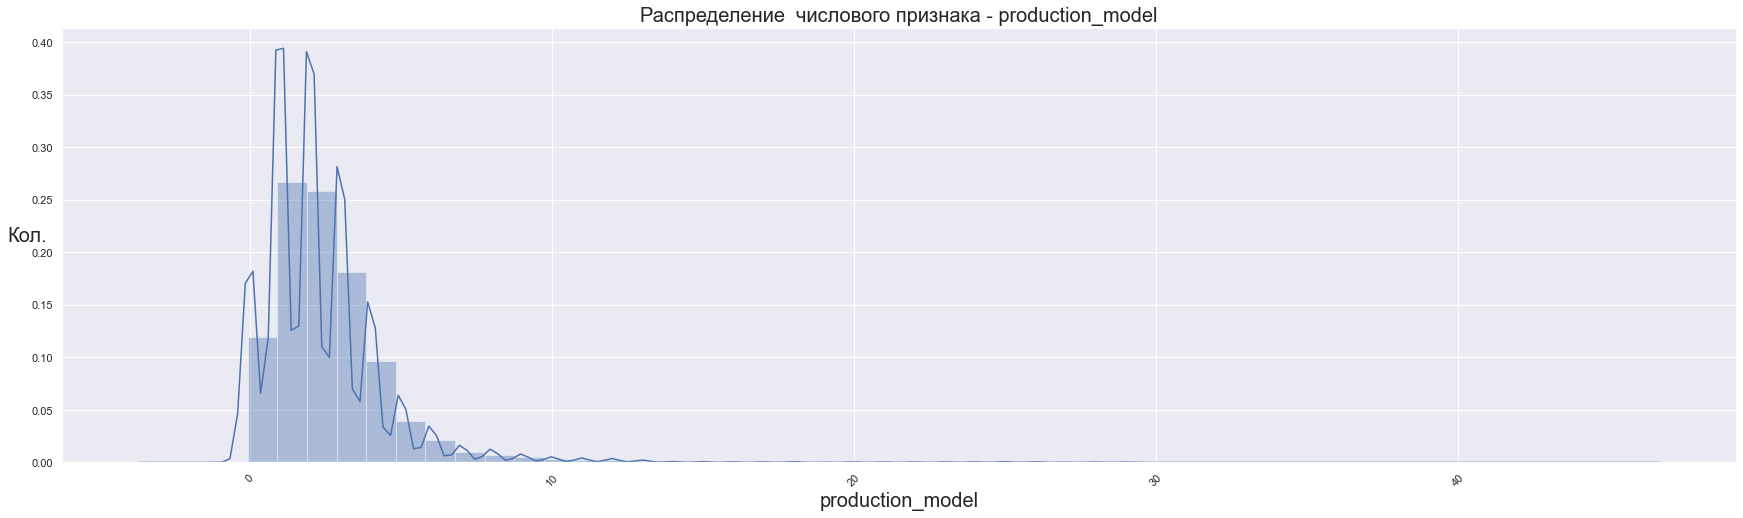

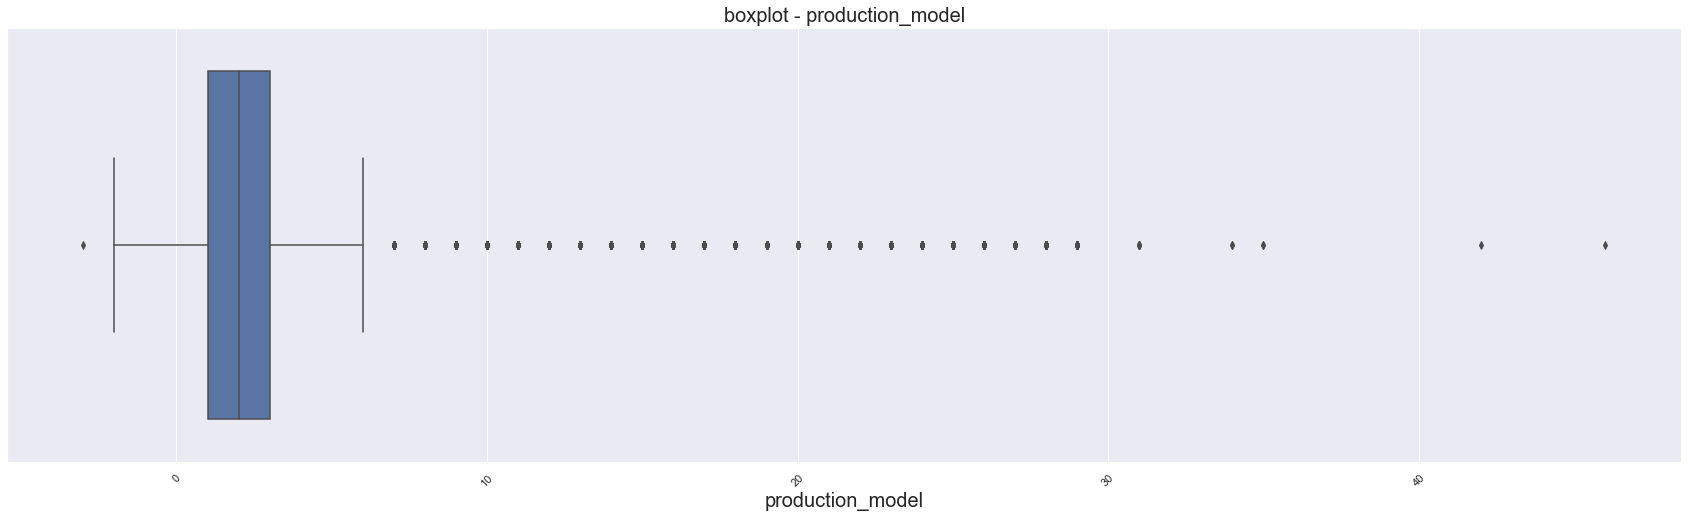

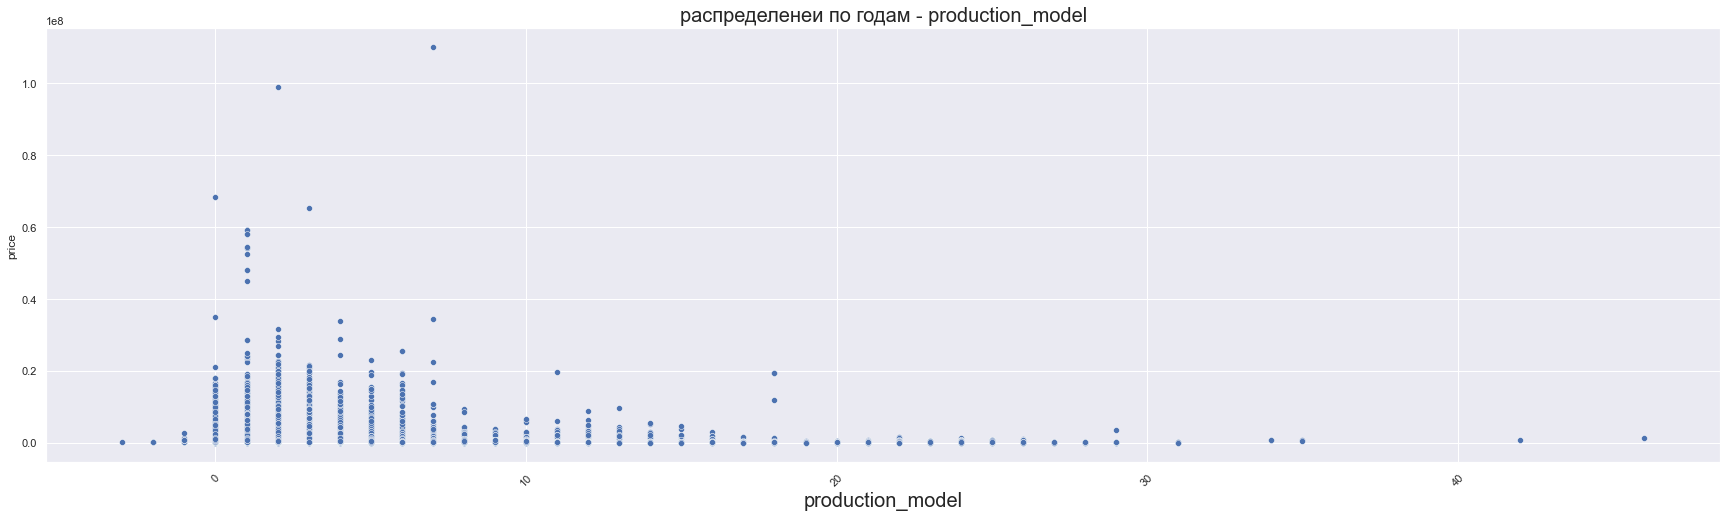

In [533]:
analiz_number_feature(data, 'production_model', 1)

In [534]:
data[data['production_model'] < 0]

car_url           bodyType  \
21068   https://auto.ru/cars/used/sale/toyota/camry/11...              седан   
27908   https://auto.ru/cars/used/sale/mitsubishi/dion...         компактвэн   
28045   https://auto.ru/cars/used/sale/mitsubishi/dion...         компактвэн   
28581   https://auto.ru/cars/used/sale/mitsubishi/dion...         компактвэн   
28762   https://auto.ru/cars/used/sale/mitsubishi/dion...         компактвэн   
46671                                                 NaN              седан   
60746                                                 NaN  внедорожник 5 дв.   
76926                                                 NaN         компактвэн   
76928                                                 NaN         компактвэн   
76929                                                 NaN         компактвэн   
76930                                                 NaN         компактвэн   
76931                                                 NaN         компактвэн   
76932                                                 NaN         компактвэн   
86437                                                 NaN      хэтчбек 3 дв.   
86514                                                 NaN      хэтчбек 3 дв.   
86748                                                 NaN      хэтчбек 3 дв.   
97869                                                 NaN           микровэн   
99789                                                 NaN              седан   
122608                                                NaN            минивэн   
124108  https://auto.ru/cars/used/sale/subaru/forester...  внедорожник 5 дв.   
124389  https://auto.ru/cars/used/sale/mitsubishi/dion...         компактвэн   
127060  https://auto.ru/cars/used/sale/subaru/forester...  внедорожник 5 дв.   
131607  https://auto.ru/cars/used/sale/opel/astra/1105...      хэтчбек 3 дв.   
135548  https://auto.ru/cars/used/sale/bmw/5er/1105602...              седан   
140194  https://auto.ru/cars/used/sale/volkswagen/pass...              седан   

             brand        color fuelType  modelDate  numberOfDoors  \
21068       toyota       чёрный   бензин       2017              4   
27908   mitsubishi       чёрный   бензин       2002              5   
28045   mitsubishi      бежевый   бензин       2002              5   
28581   mitsubishi       чёрный   бензин       2002              5   
28762   mitsubishi      зелёный   бензин       2002              5   
46671        chery       чёрный   бензин       2010              4   
60746      hyundai        белый   бензин       1997              5   
76926   mitsubishi       чёрный   бензин       2002              5   
76928   mitsubishi       чёрный   бензин       2002              5   
76929   mitsubishi      бежевый   бензин       2002              5   
76930   mitsubishi       чёрный   бензин       2002              5   
76931   mitsubishi      зелёный   бензин       2002              5   
76932   mitsubishi  серебристый   бензин       2002              5   
86437         opel      красный   бензин       2012              3   
86514         opel      красный   бензин       2012              3   
86748         opel      красный   бензин       2012              3   
97869       subaru        белый   бензин       2009              5   
99789       toyota       чёрный   бензин       2017              4   
122608    mercedes        белый   дизель       1996              4   
124108      subaru  серебристый   бензин       2011              5   
124389  mitsubishi  серебристый   бензин       2002              5   
127060      subaru  серебристый   бензин       2011              5   
131607        opel       чёрный   бензин       2012              3   
135548         bmw  серебристый   дизель       2017              4   
140194  volkswagen   коричневый   бензин       2011              4   

        productionDate vehicleTransmission  engineDisplacement  ...  \
21068             2016             автомат                 2.5  ...   
27908 

По данным видно что это скорее всего ошибка. Отрицательные значения приравняем к 0


In [535]:
data['production_model'] = data['production_model'].apply(lambda x : x if x > 0 else 0)

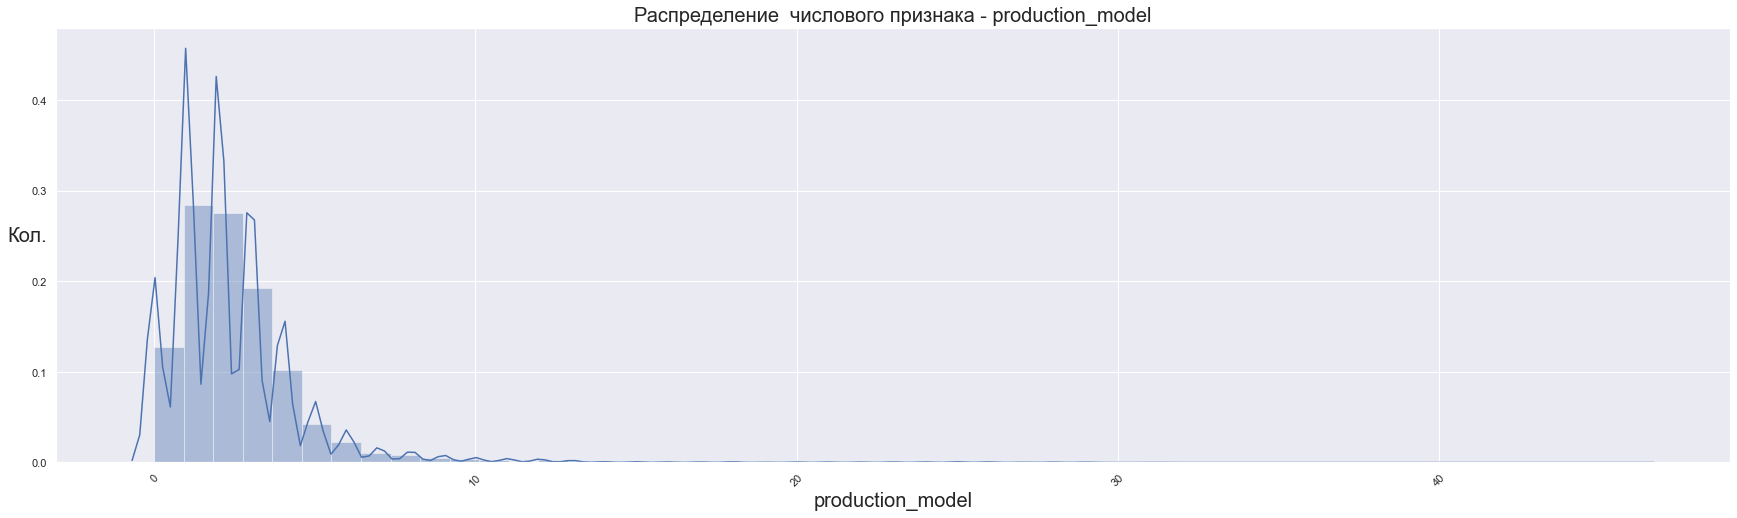

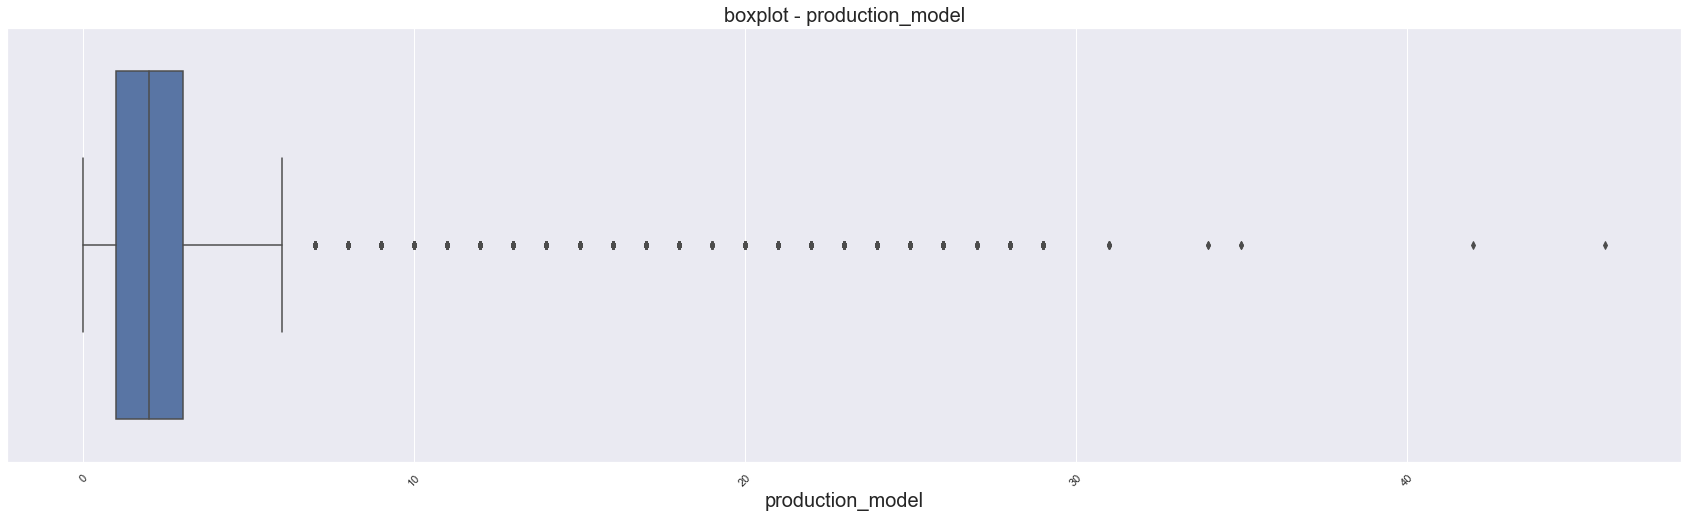

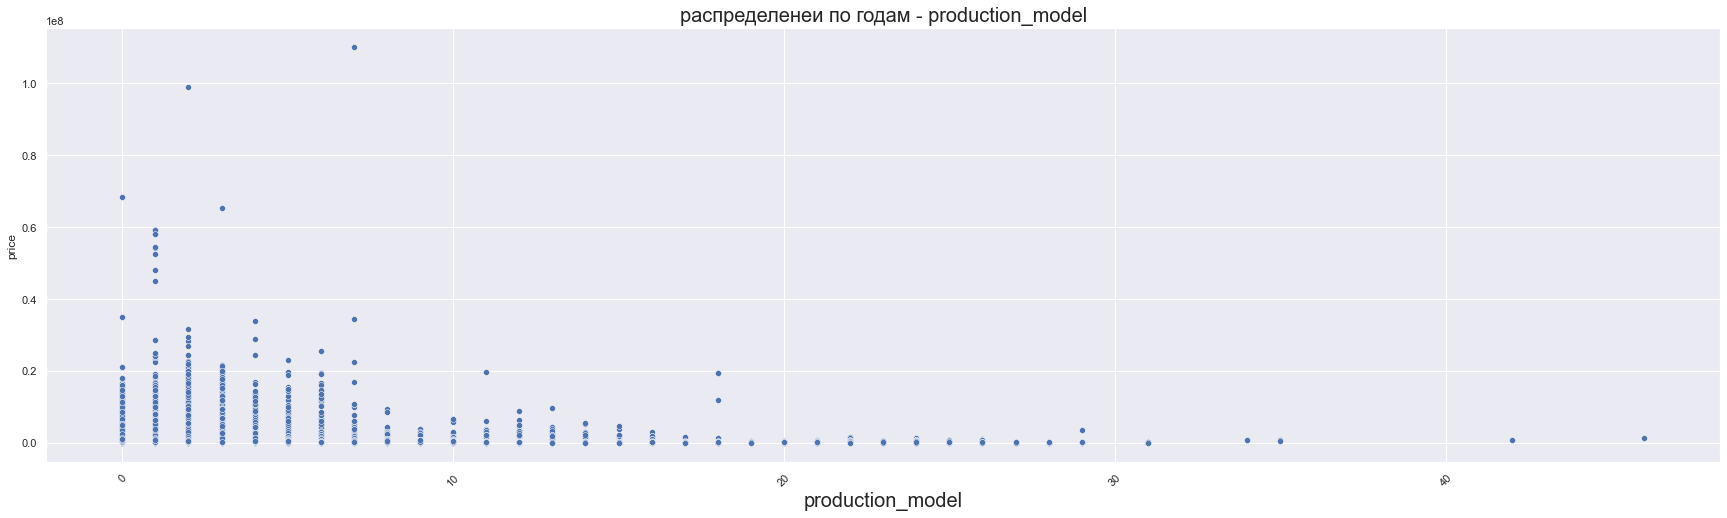

In [536]:
analiz_number_feature(data, 'production_model', 1)

**Вывод** - чем больше разница тем цена уменьшается

# enginePower
 мощность


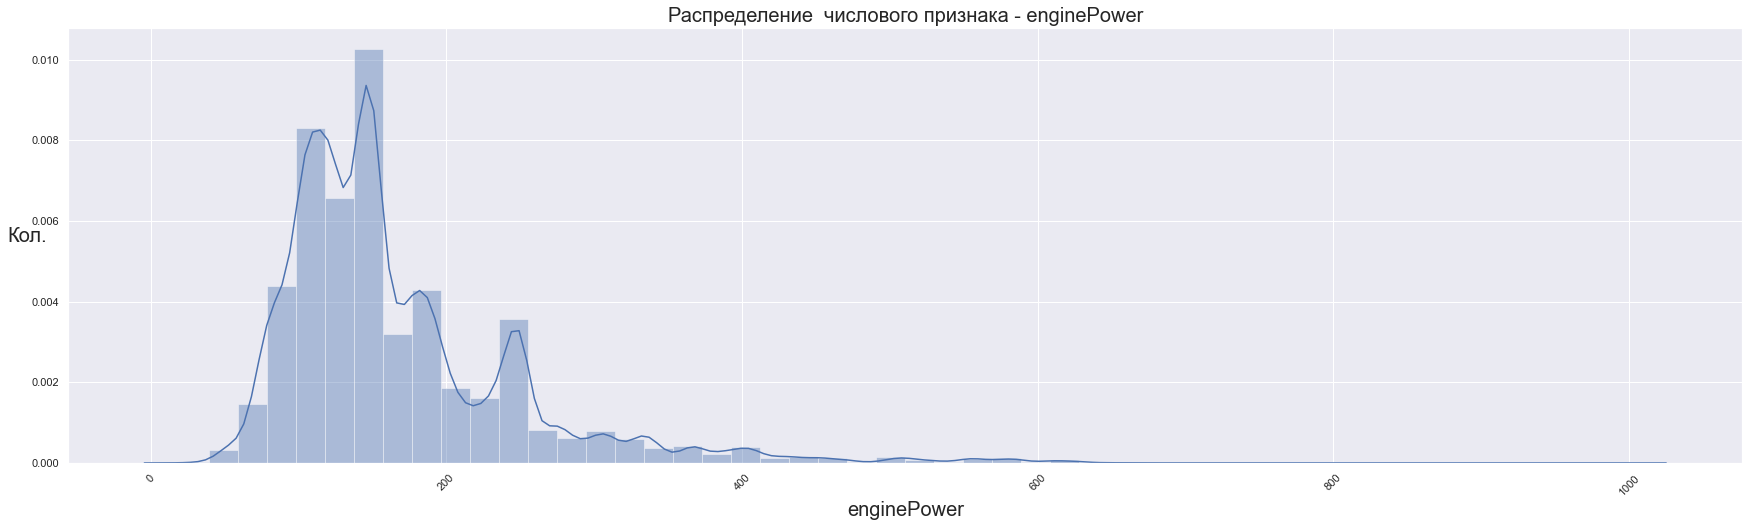

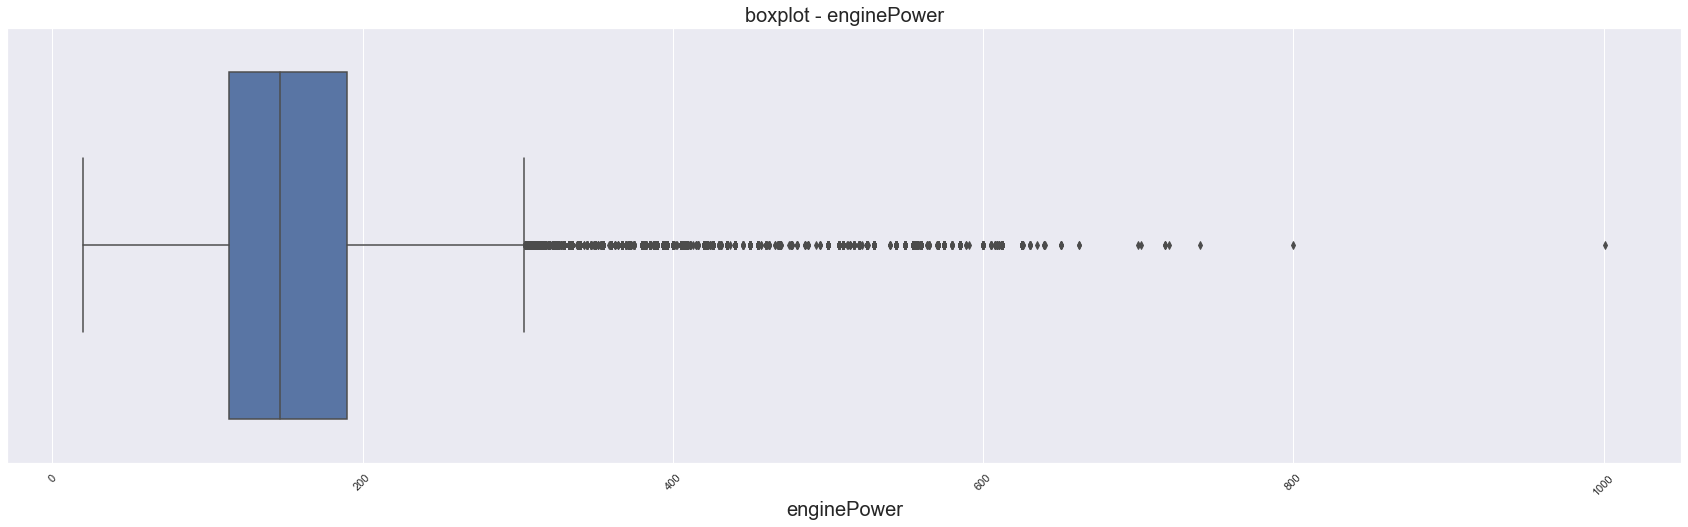

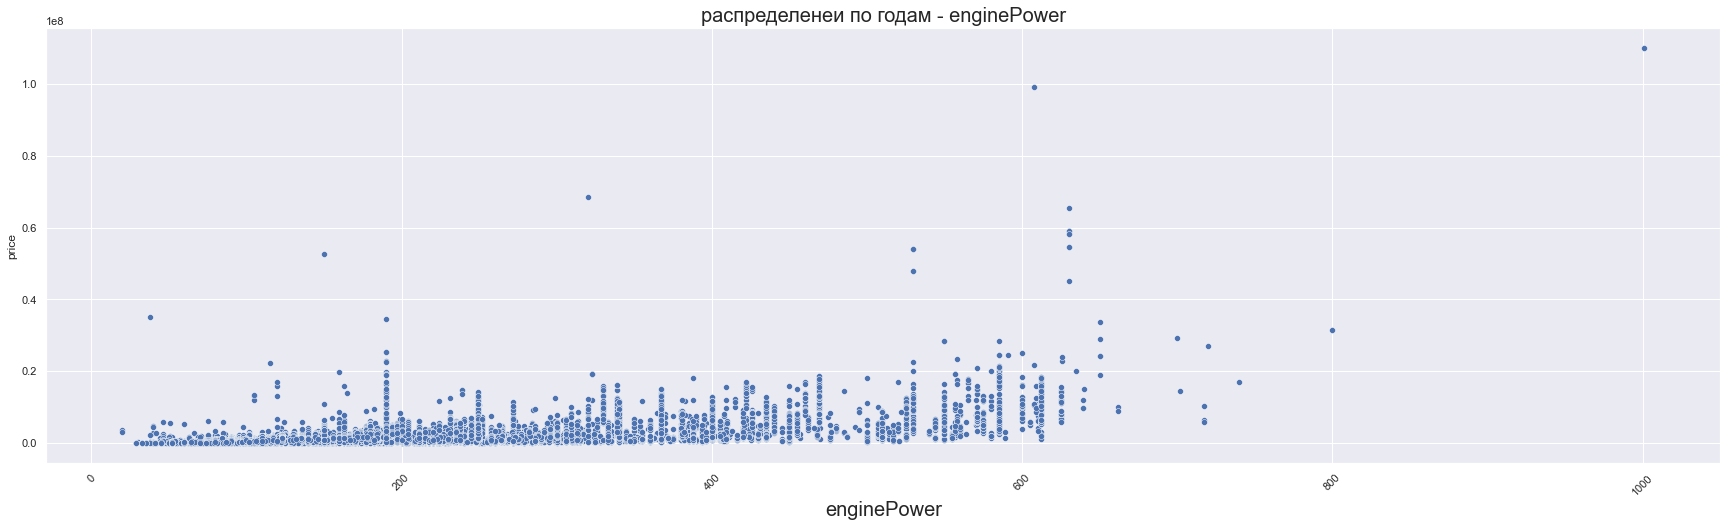

In [537]:
analiz_number_feature(data, 'enginePower', 1)

**Вывод**  - как и ожидалось тем больше мощность тем выше цена

# engineDisplacement
объем двигателя


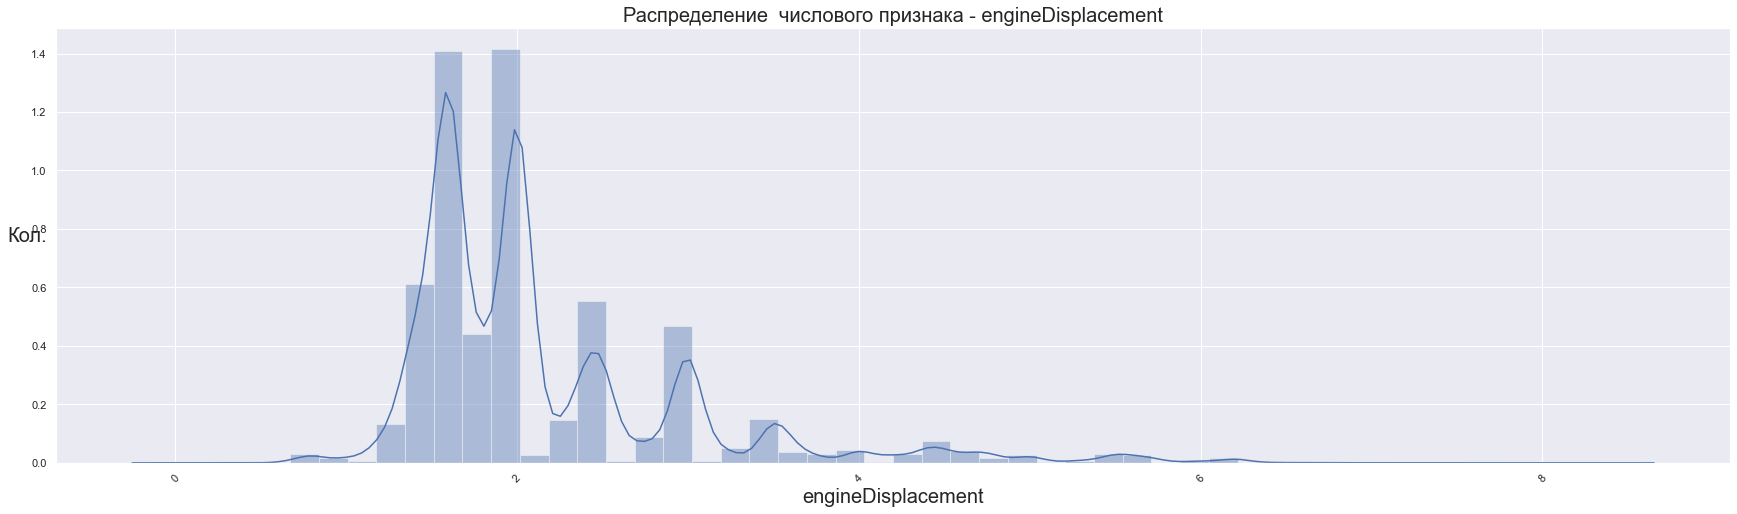

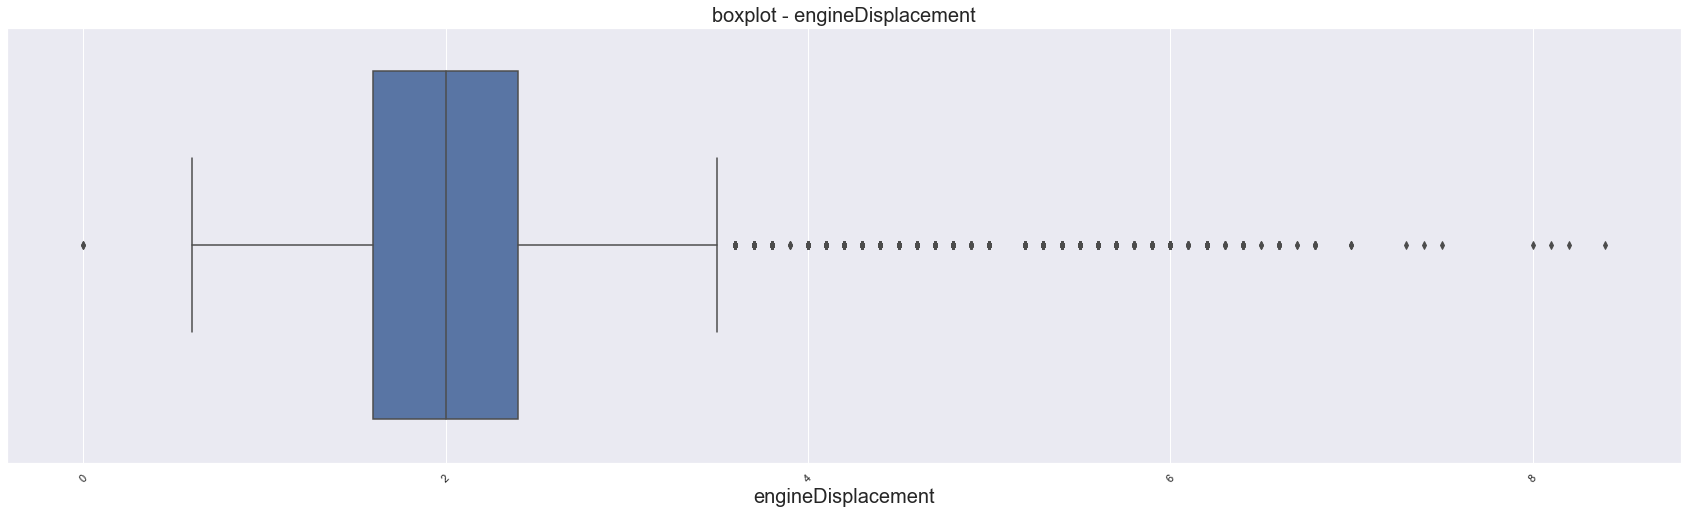

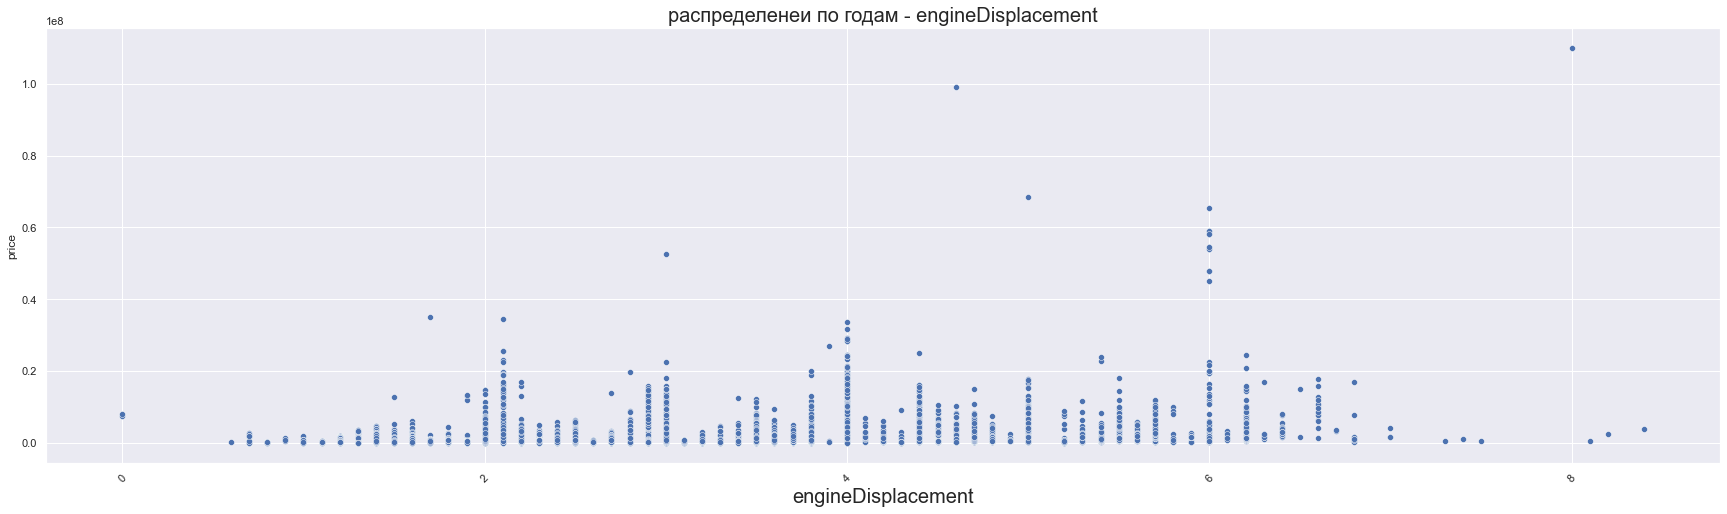

In [538]:
analiz_number_feature(data, 'engineDisplacement', 1)

In [539]:
data[data['engineDisplacement'] < 0]

car_url           bodyType  \
5241   https://auto.ru/cars/used/sale/audi/e_tron/110...  внедорожник 5 дв.   
7992   https://auto.ru/cars/used/sale/bmw/i3/11010431...      хэтчбек 5 дв.   
8252   https://auto.ru/cars/used/sale/bmw/i3/11012780...      хэтчбек 5 дв.   
8350   https://auto.ru/cars/used/sale/bmw/i3/11002716...      хэтчбек 5 дв.   
8684   https://auto.ru/cars/used/sale/bmw/i3/11011745...      хэтчбек 5 дв.   
8722   https://auto.ru/cars/used/sale/bmw/i3/11000973...      хэтчбек 5 дв.   
8917   https://auto.ru/cars/used/sale/bmw/i3/11008715...      хэтчбек 5 дв.   
10817  https://auto.ru/cars/used/sale/bmw/i3/11012664...      хэтчбек 5 дв.   
10936  https://auto.ru/cars/used/sale/bmw/i3/10996733...      хэтчбек 5 дв.   
11043  https://auto.ru/cars/used/sale/bmw/i3/10993761...      хэтчбек 5 дв.   
11302  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
11682  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
11714  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
11719  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
11754  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
11878  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
11974  https://auto.ru/cars/used/sale/nissan/leaf/108...      хэтчбек 5 дв.   
12072  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
12085  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12100  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12250  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12287  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12334  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
12466  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
12481  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
12558  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12582  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12678  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12749  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12854  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12916  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12948  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12950  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
13052  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
13104  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
13105  https://auto.ru/cars/used/sale/nissan/leaf/108...      хэтчбек 5 дв.   
13478  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
13633  https://auto.ru/cars/used/sale/nissan/leaf/100...      хэтчбек 5 дв.   
13660  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
13720  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
13812  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
13915  https://auto.ru/cars/used/sale/nissan/leaf/108...      хэтчбек 5 дв.   
13952  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
13989  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
14147  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
14419  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
23869  https://auto.ru/cars/used/sale/volkswagen/golf...      хэтчбек 5 дв.   
23948  https://auto.ru/cars/used/sale/volkswagen/golf...      хэтчбек 5 дв.   
27064  https://auto.ru/cars/used/sale/mitsubishi/i_mi...      хэтчбек 5 дв.   
28241  https://auto.ru/cars/used/sale/mitsubishi/i_mi...      хэтчбек 5 дв.   
32668  https://auto.

**Вывод**  - явной связи ценой с объемом двигателя не прослежтивается. Отрицательные заначения  - это как бы пометил что значения неизвестны. (Видно что электромашины) Это может быть связано с возрастом авто

# car_age
вычислим как start_year  минус production_model

In [540]:
data['car_age'] = data['start_year'] - data['productionDate']

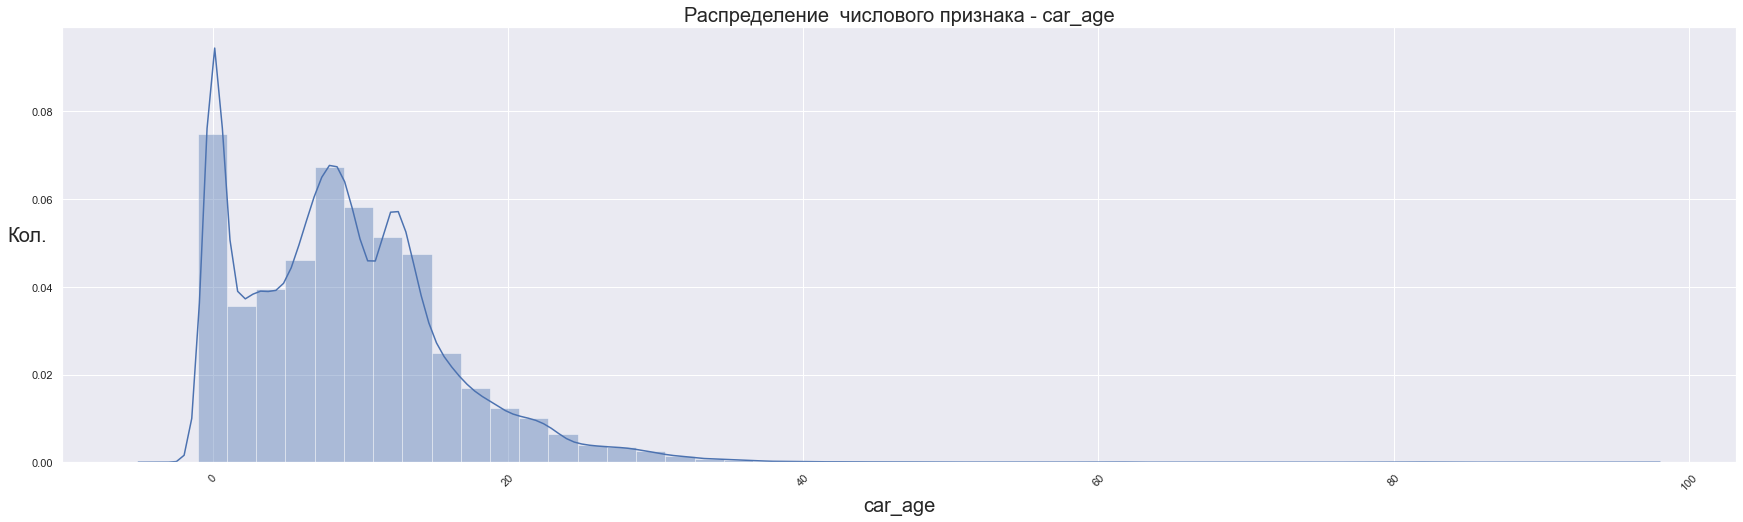

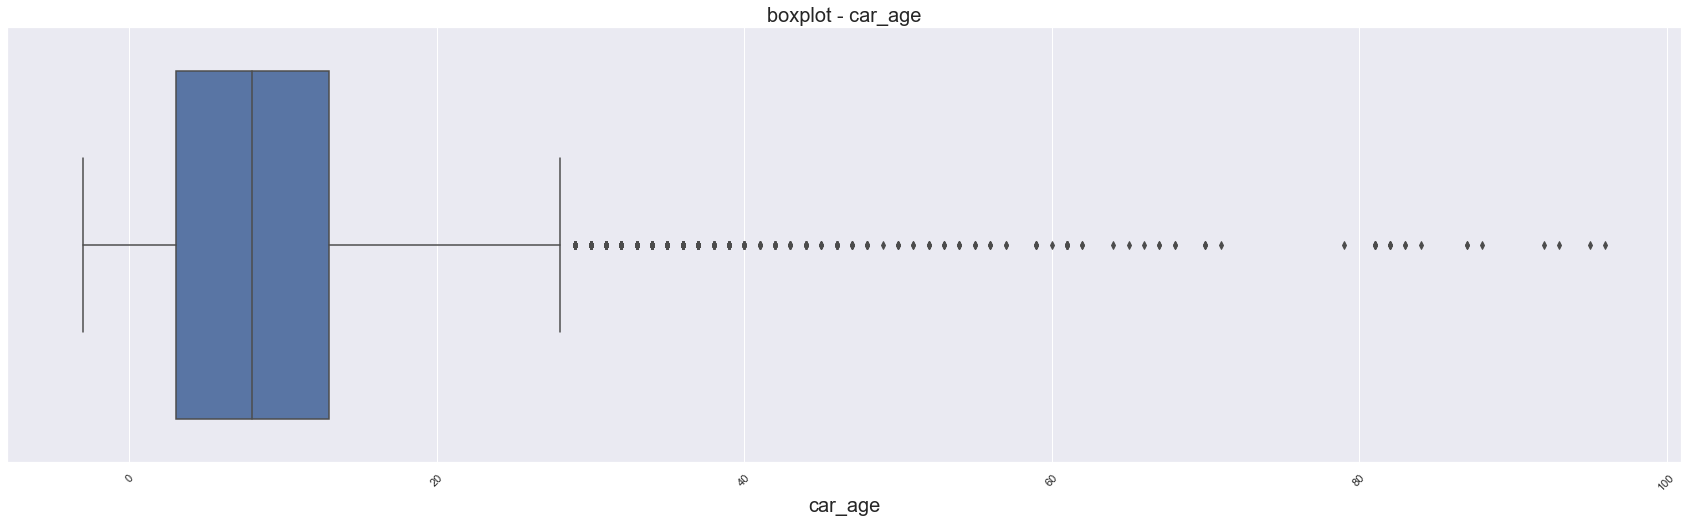

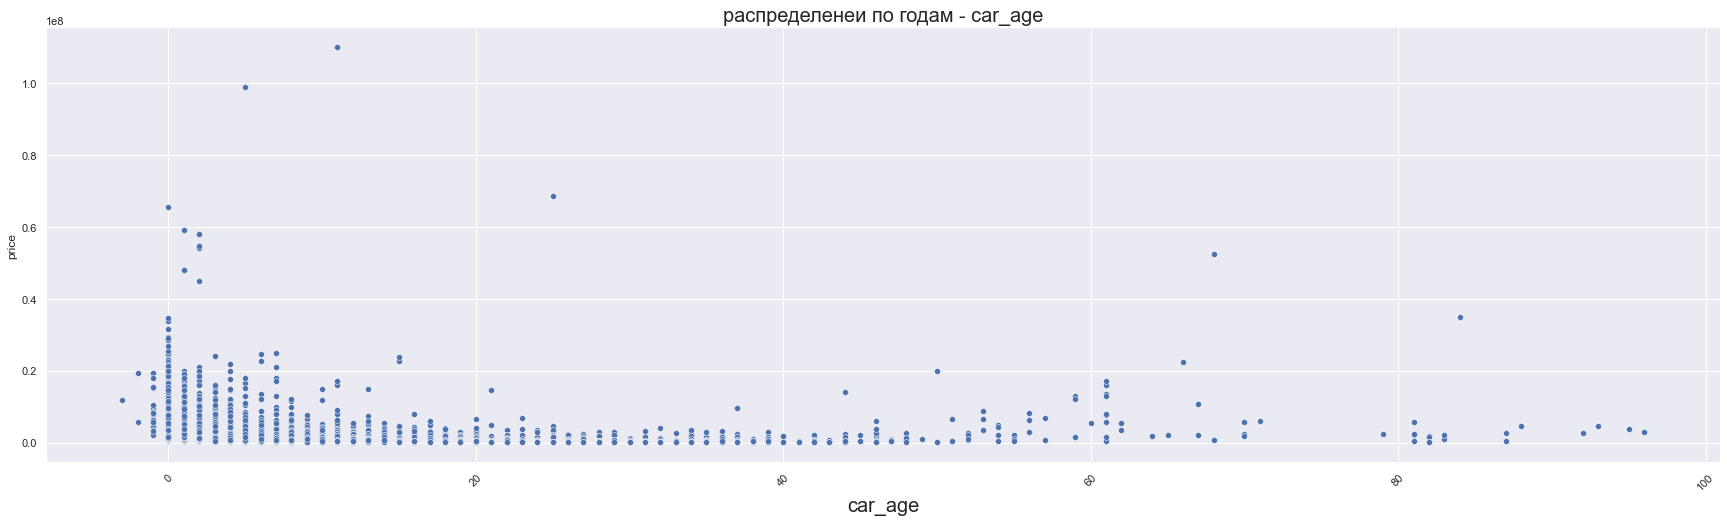

In [541]:
analiz_number_feature(data, 'car_age', 1)

In [542]:
data[data['car_age'] < 0]

car_url              bodyType      brand      color fuelType  \
43352      NaN     внедорожник 5 дв.        bmw      белый   бензин   
46264      NaN     внедорожник 5 дв.   cadillac     чёрный   бензин   
46265      NaN     внедорожник 5 дв.   cadillac     чёрный   бензин   
46267      NaN     внедорожник 5 дв.   cadillac     чёрный   бензин   
48441      NaN               минивэн  chevrolet      белый   бензин   
48442      NaN               минивэн  chevrolet      синий   бензин   
48443      NaN               минивэн  chevrolet      серый   бензин   
48444      NaN               минивэн  chevrolet      синий   бензин   
50300      NaN  пикап двойная кабина  chevrolet     чёрный   бензин   
50576      NaN                 седан   chrysler      серый   бензин   
53148      NaN               минивэн      dodge      синий   бензин   
53300      NaN     внедорожник 5 дв.      dodge  пурпурный   бензин   
53935      NaN  пикап двойная кабина       ford      белый   бензин   
53944      NaN  пикап двойная кабина       ford      белый   дизель   
53947      NaN  пикап двойная кабина       ford      синий   бензин   
58014      NaN                  купе       ford     чёрный   бензин   
59589      NaN               минивэн      honda      белый   бензин   
59593      NaN               минивэн      honda      синий   бензин   
73433      NaN     внедорожник 5 дв.      lexus     чёрный   бензин   
98853      NaN     внедорожник 5 дв.     toyota      белый   бензин   
102322     NaN         хэтчбек 5 дв.     toyota    голубой   гибрид   
103330     NaN     внедорожник 5 дв.     toyota      белый   бензин   
103334     NaN     внедорожник 5 дв.     toyota      серый   бензин   
103354     NaN               минивэн     toyota      белый   бензин   
103357     NaN               минивэн     toyota    красный   бензин   
115092     NaN         хэтчбек 5 дв.   mercedes      белый   бензин   
116883     NaN                 седан   mercedes     чёрный   бензин   
117073     NaN                 седан   mercedes     чёрный   бензин   
118125     NaN     внедорожник 5 дв.   mercedes     чёрный   бензин   

        modelDate  numberOfDoors  productionDate vehicleTransmission  \
43352        2019              5            2020             автомат   
46264        2014              5            2019             автомат   
46265        2014              5            2019             автомат   
46267        2014              5            2019             автомат   
48441        2002              5            2020             автомат   
48442        2002              5            2020             автомат   
48443        2002              5            2020             автомат   
48444        2002              5            2020             автомат   
50300        2015              4            2020             автомат   
50576        2015              4            2020             автомат   
53148        2007              5            2020             автомат   
53300        2013              5            2020             автомат   
53935        2017              4            2020             автомат   
53944        2017              4            2020             автомат   
53947        2017              4            2020             автомат   
58014        2017              2            2020            механика   
59589        2018              5            2020             автомат   
59593        2018              5            2020             автомат   
73433        2015              5            2020             автомат   
98853        2013              5            2020             автомат   
102322       2015              5            2020             автомат   
103330       2017              5            2020             автомат   
103334       2017              5            2020             автомат   
103354       2010              5            2020             автомат   
103357       2010              5            2020             автомат   
1150

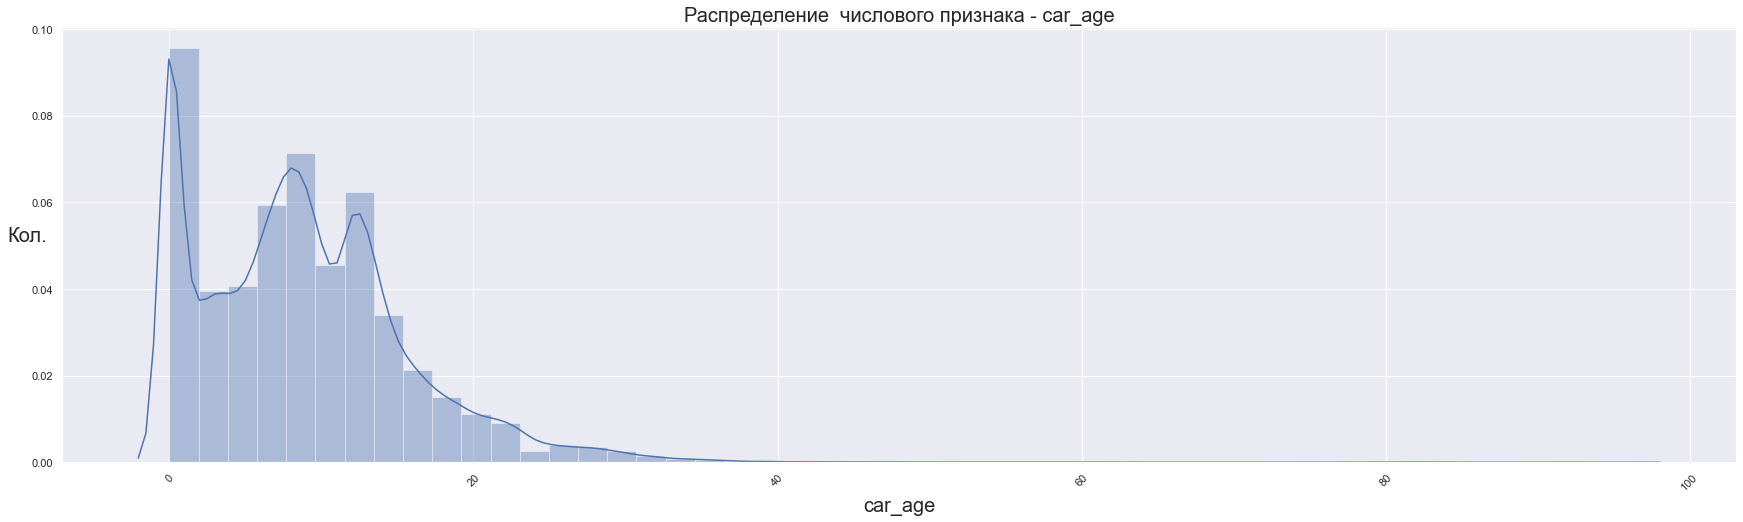

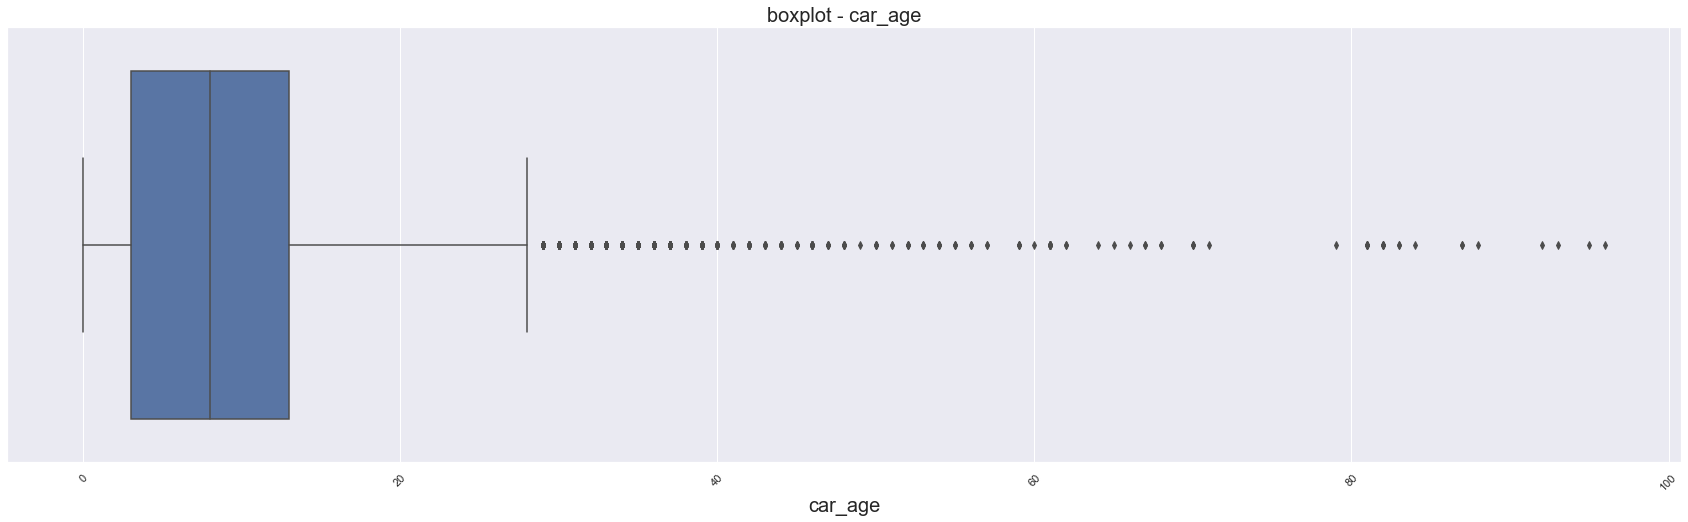

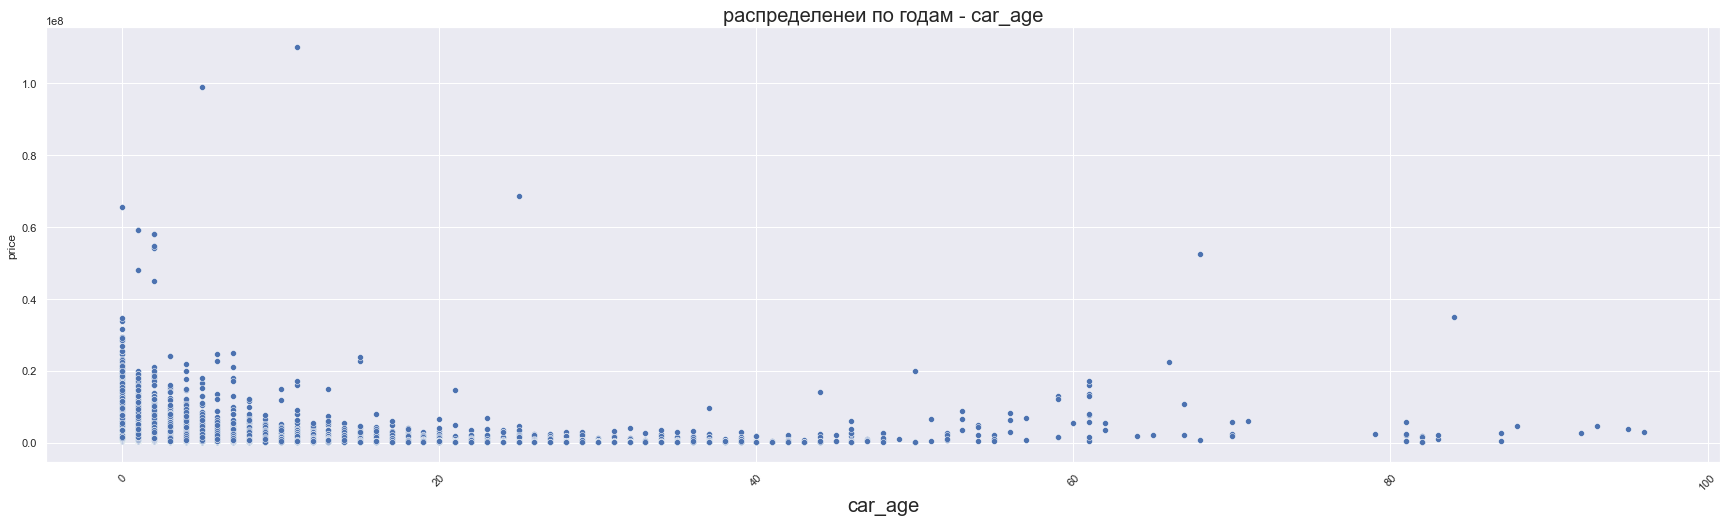

In [543]:
data['car_age'] = data['car_age'].apply(lambda x : x if x > 0 else 0)
analiz_number_feature(data, 'car_age', 1)

**Вывод**  - этот признак напрямую влияет на цену. Отрицатльные значения приравняем к 0, оченб похоже на ошибку

# mileage
пробег и установим бинарный признак новая/неновое авто.


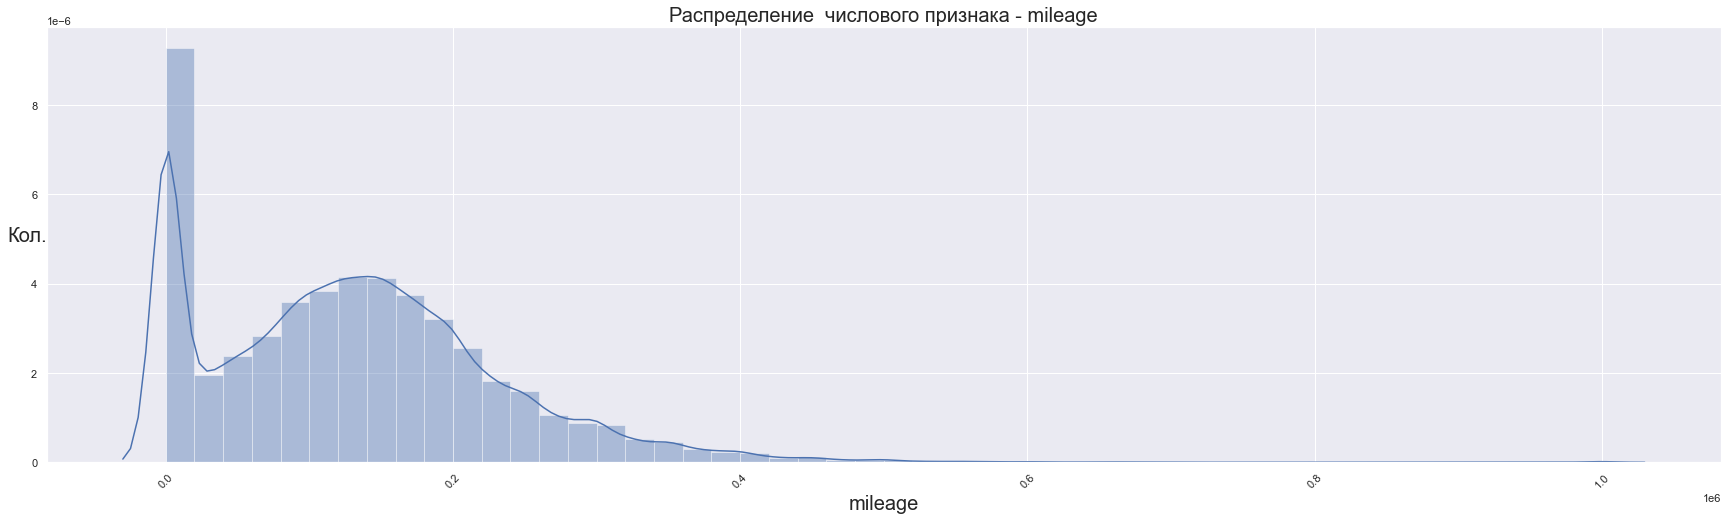

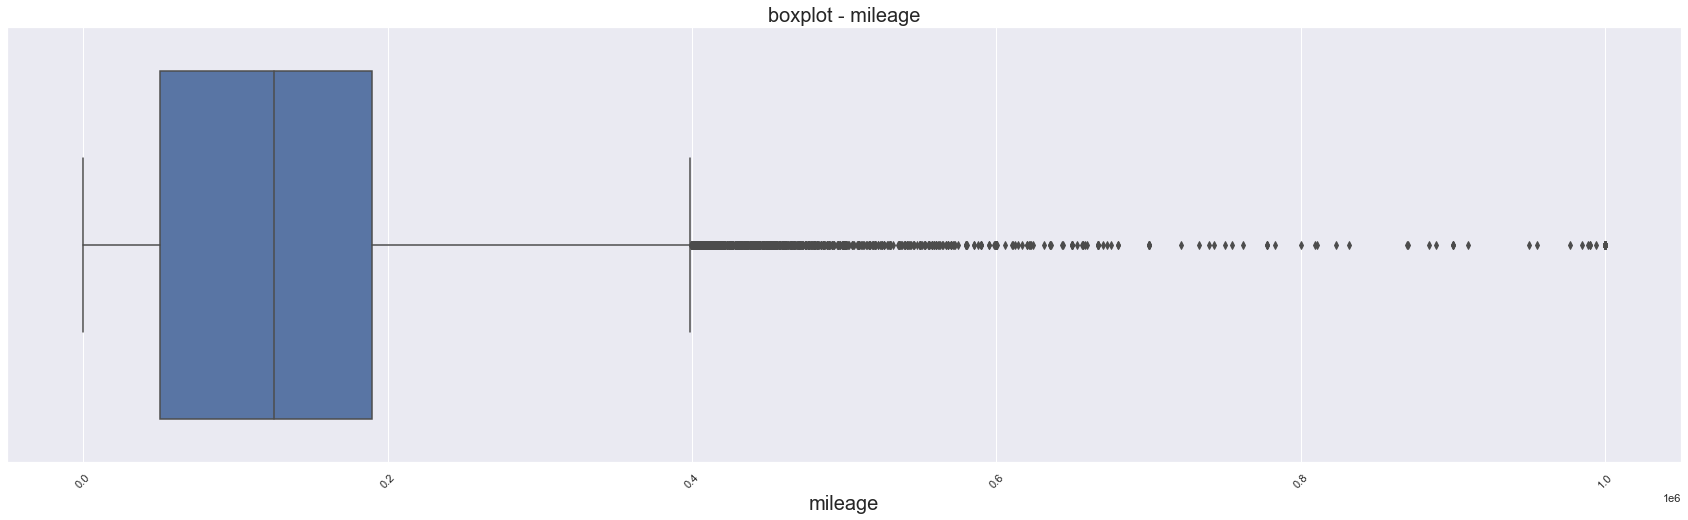

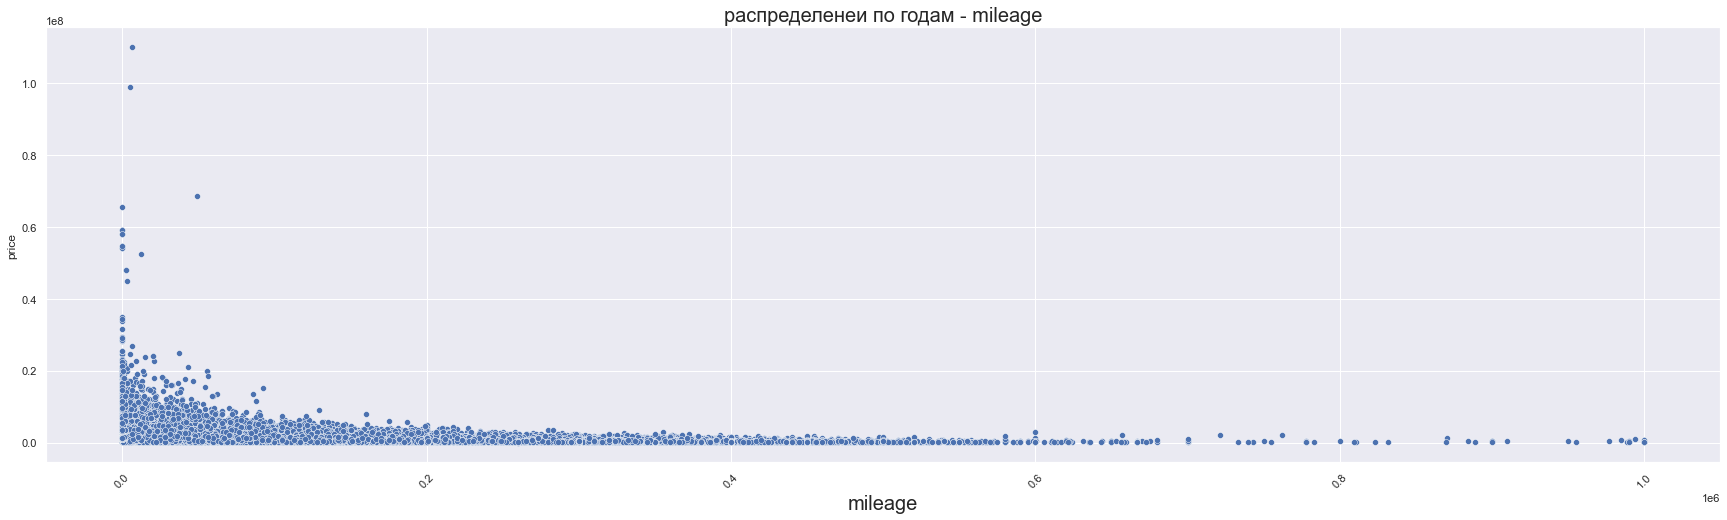

In [544]:
analiz_number_feature(data, 'mileage', 1)

**Вывод**  - этот признак  напрямую влияет на цену, цена убывает с возрастанием пробега

# racing
 Время разгона , неизвестные значения примем за -1 

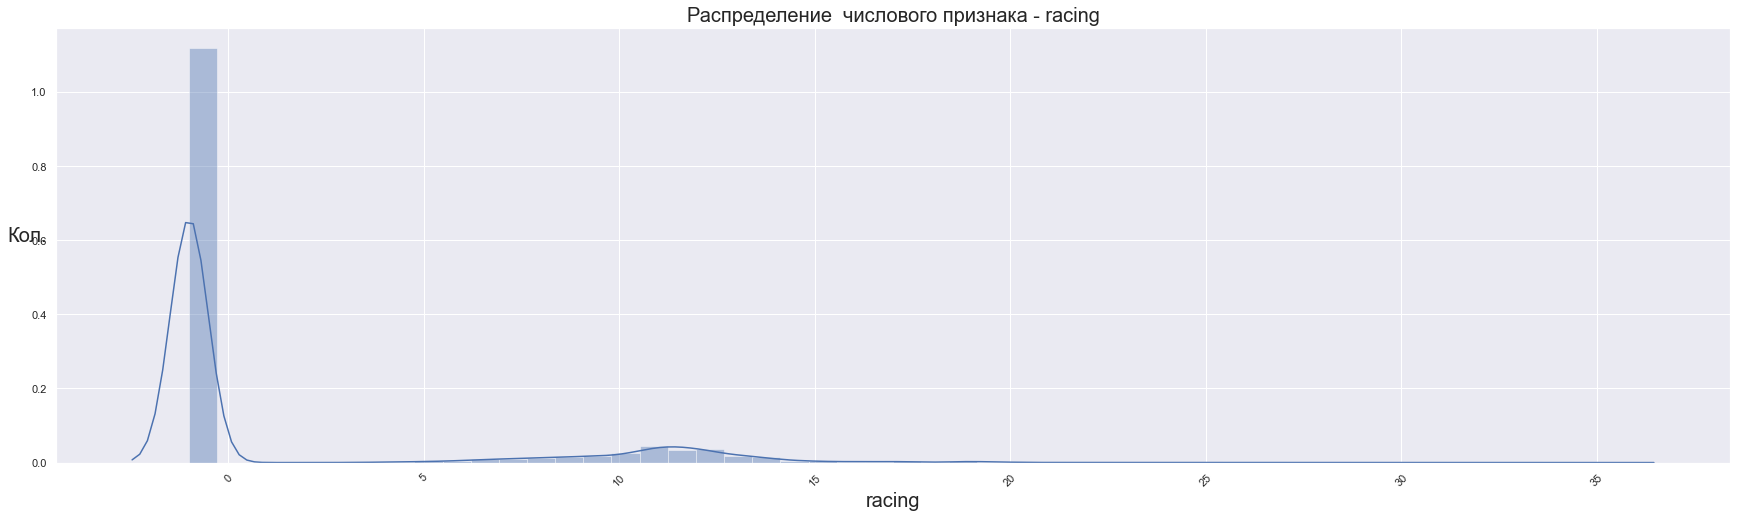

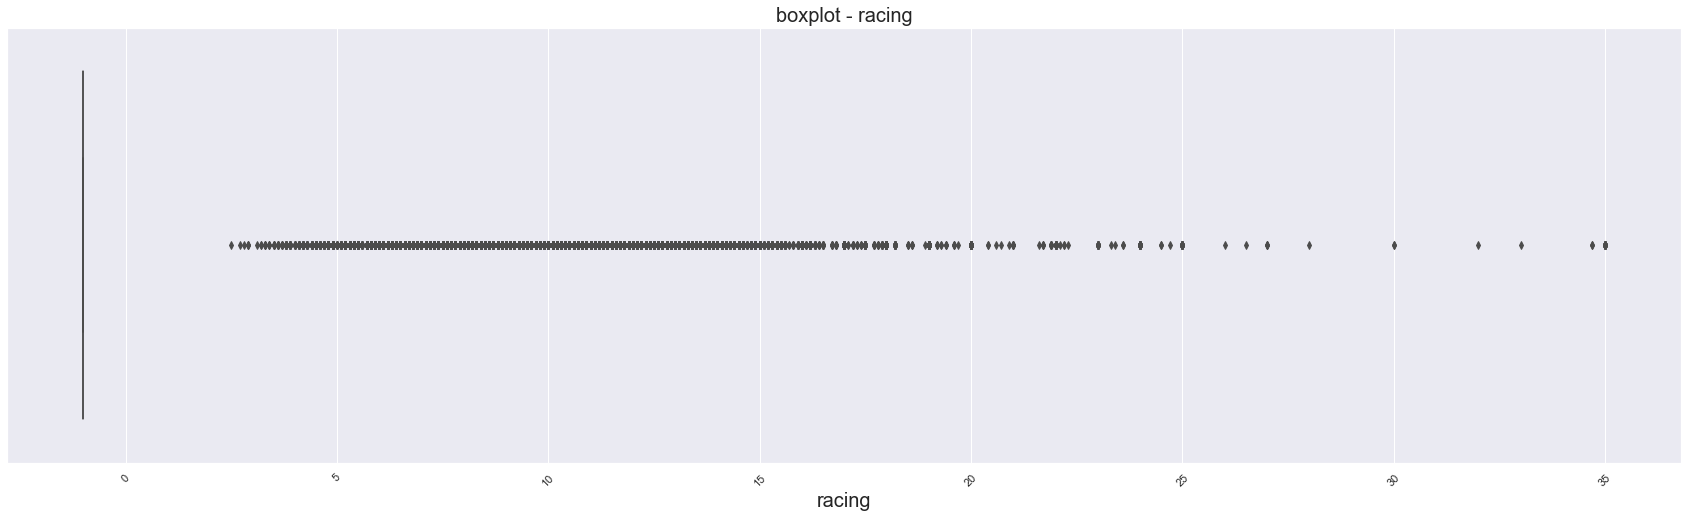

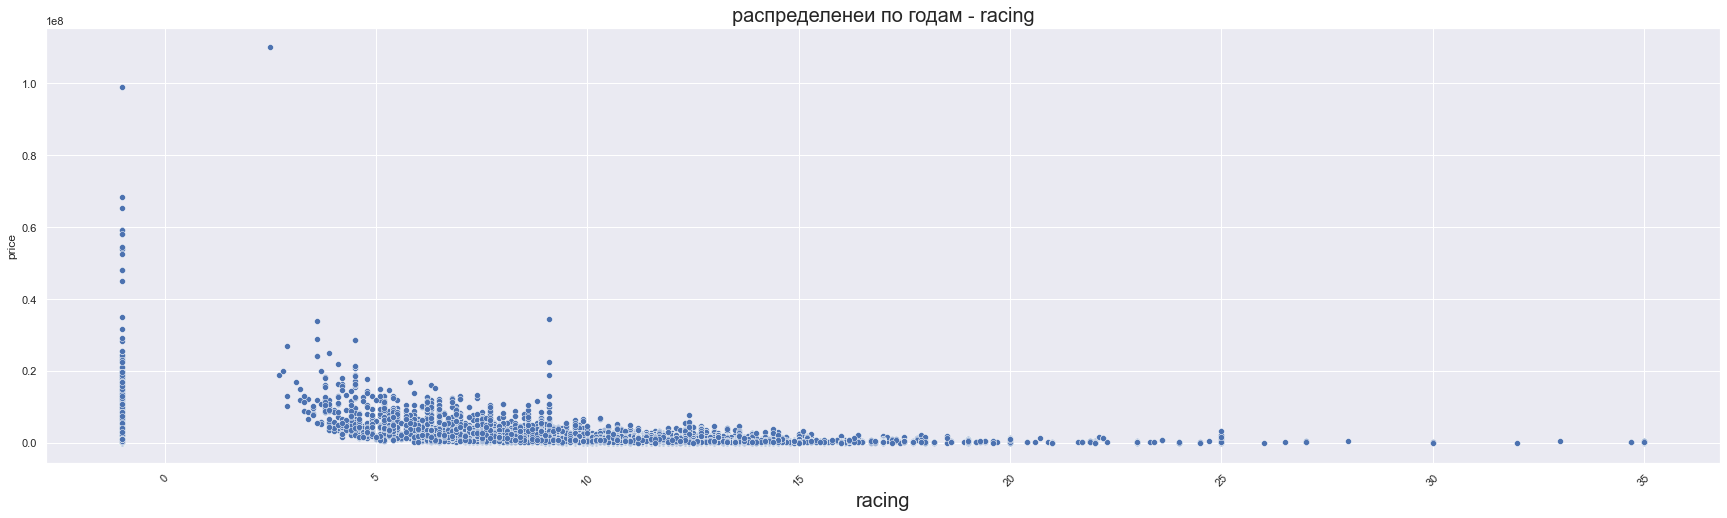

In [545]:
analiz_number_feature(data, 'racing', 1)

**Вывод**  - этот признак  напрямую влияет на цену, цена убывает с возрастанием разгона

# descrip_lenth
    Длина опсиания

In [546]:
data['descrip_lenth'] = data['description'].apply(lambda x: len(str(x)))

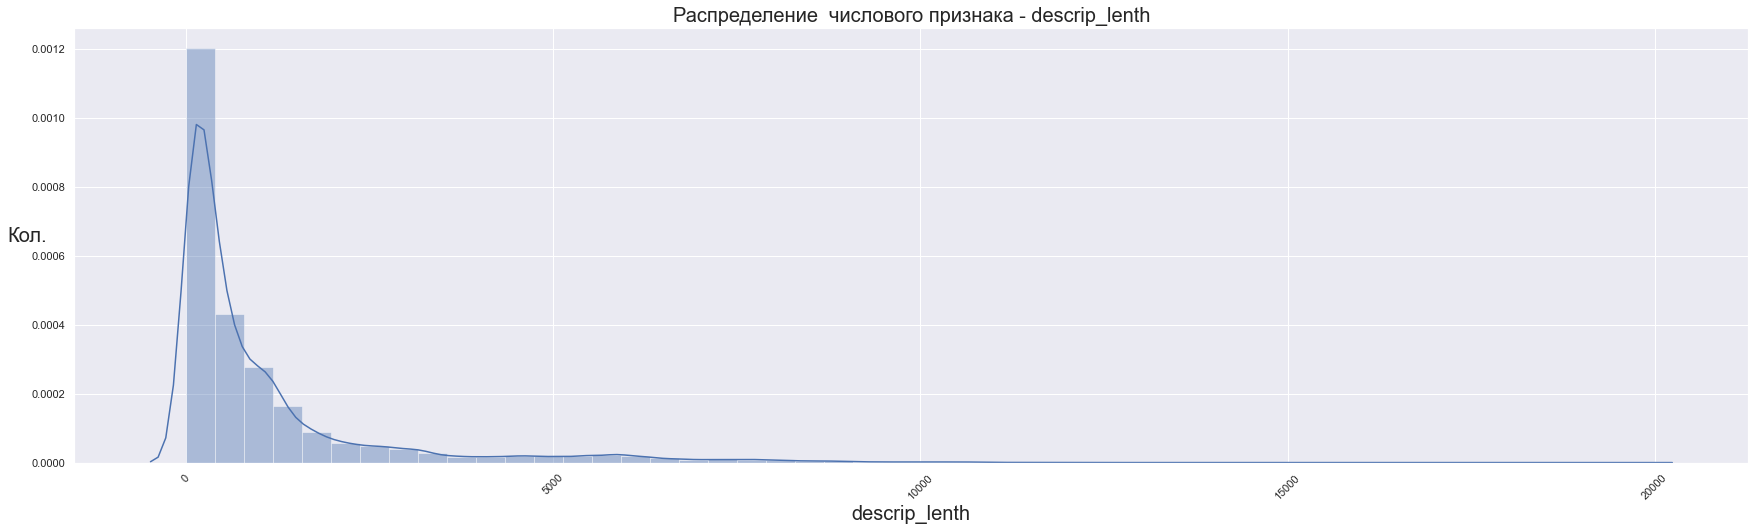

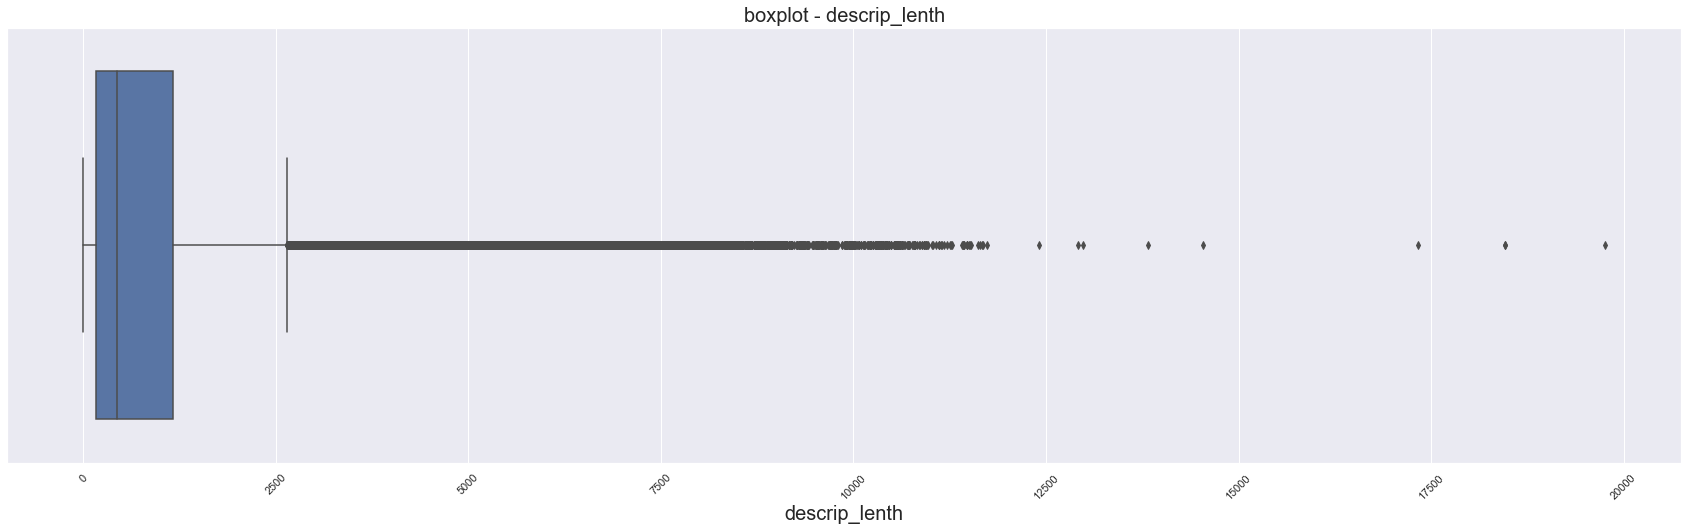

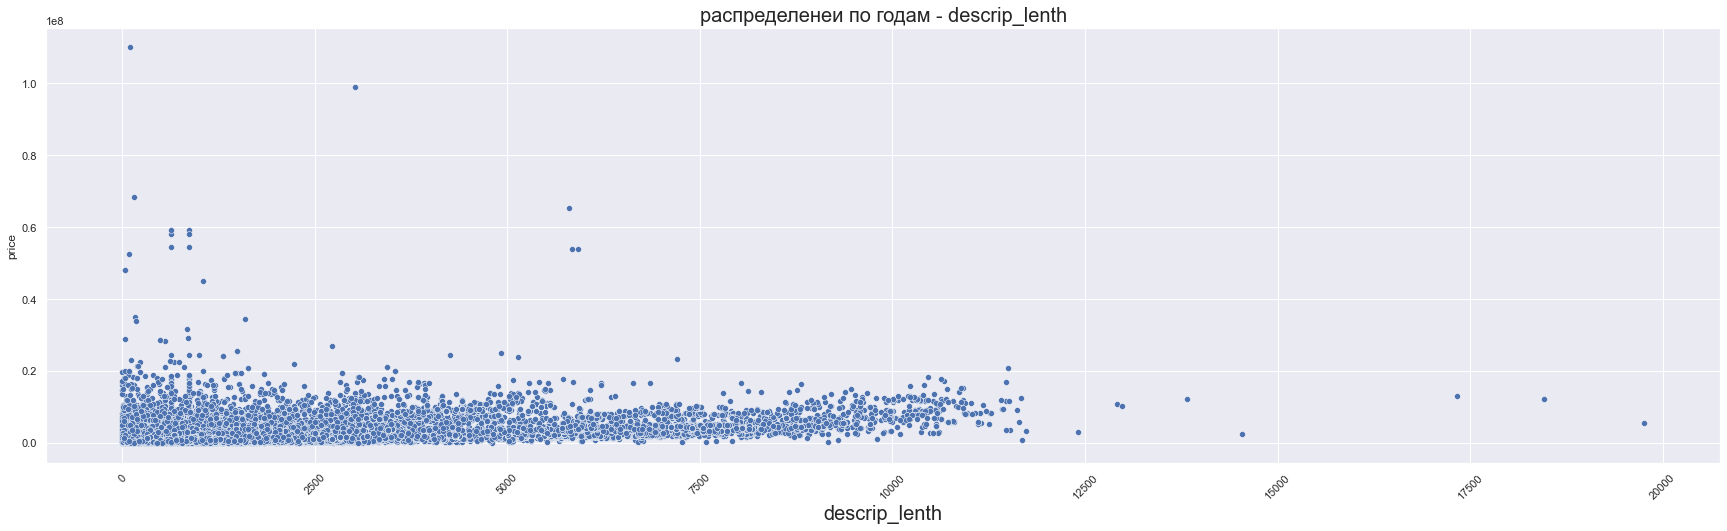

In [547]:
analiz_number_feature(data, 'descrip_lenth', 1)

**Вывод**  - ярко выраженной зависимости не налюдается

# mileage_year
    Пробег среднйи за год


In [548]:
data['mileage_year'] = pd.to_numeric(data['mileage'] / data['car_age']).round(2)
data['mileage_year'].replace([np.inf, -np.inf], np.nan, inplace=True)
data['mileage_year'].fillna(0, inplace=True)
data['mileage_year'] = data['mileage_year'].astype(int)

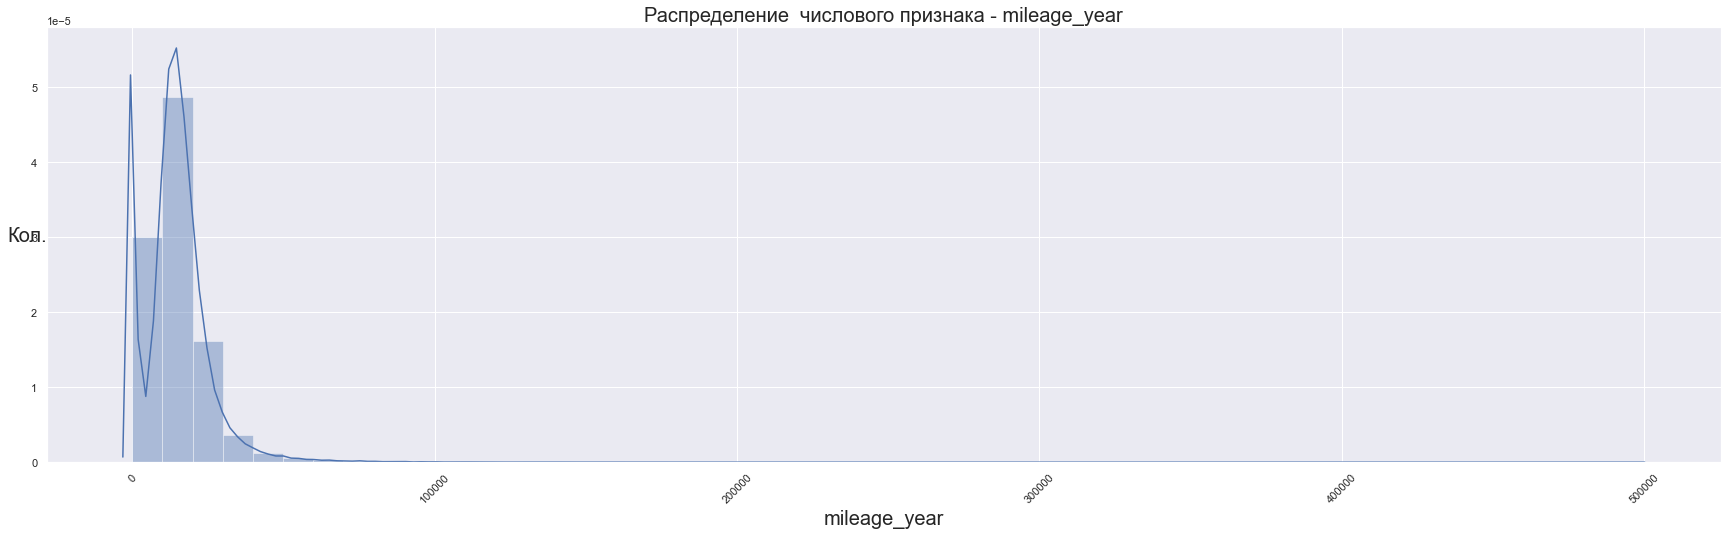

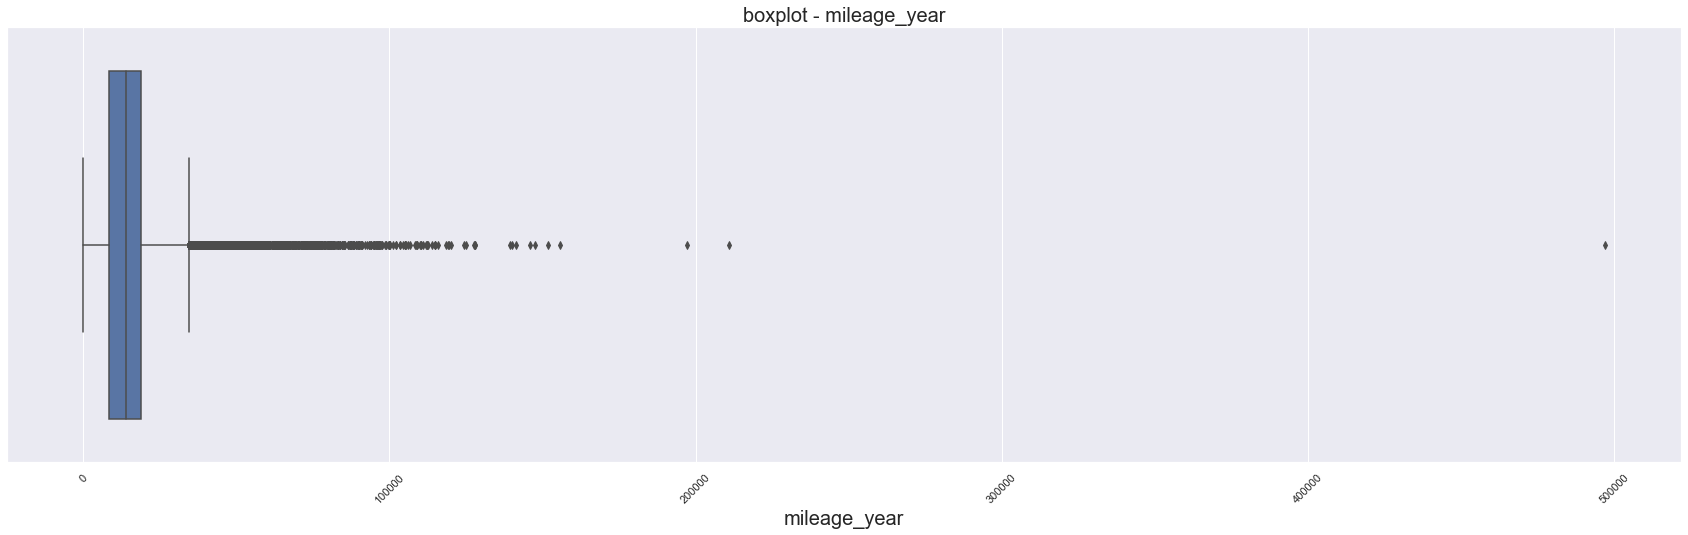

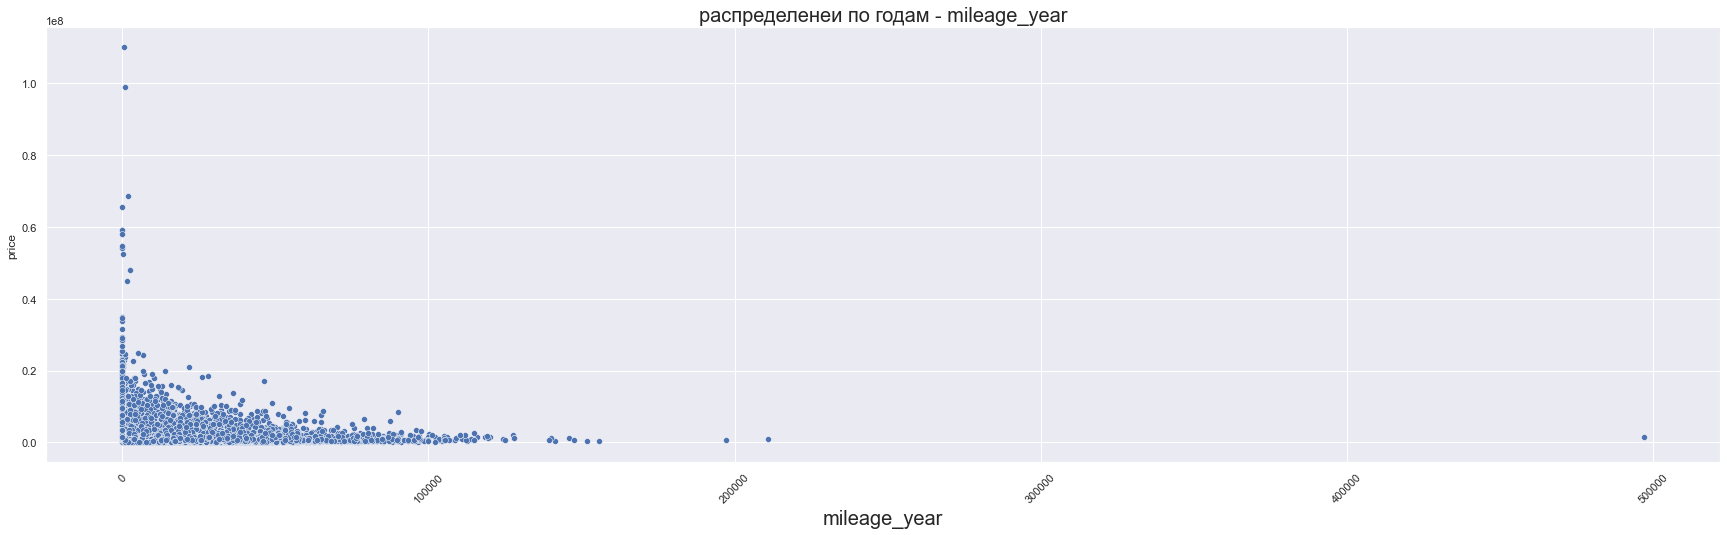

In [549]:
analiz_number_feature(data, 'mileage_year', 1)

**Вывод**  - чем больше пробег тем ниже ценаю Примем как числовой параметр


# Бинарные признаки
Бинарыне признаким нужно вообще то бы привести к балансировке (если будет время сделаю!!! )

**car_new** - новая ли машина, новый признак 

In [550]:
CAR_NEW_LIMIT = 500

def defineMileageRow(row, params, some):
    if int(row['mileage']) <= CAR_NEW_LIMIT:
        row['car_new'] = 1
    else:
        row['car_new'] = 0
    return row

def defineMileageType(data):
    data = data.apply(defineMileageRow, args=([], 1), axis=1)
    return data

data = defineMileageType(data)

In [551]:
data = defineMileageType(data)

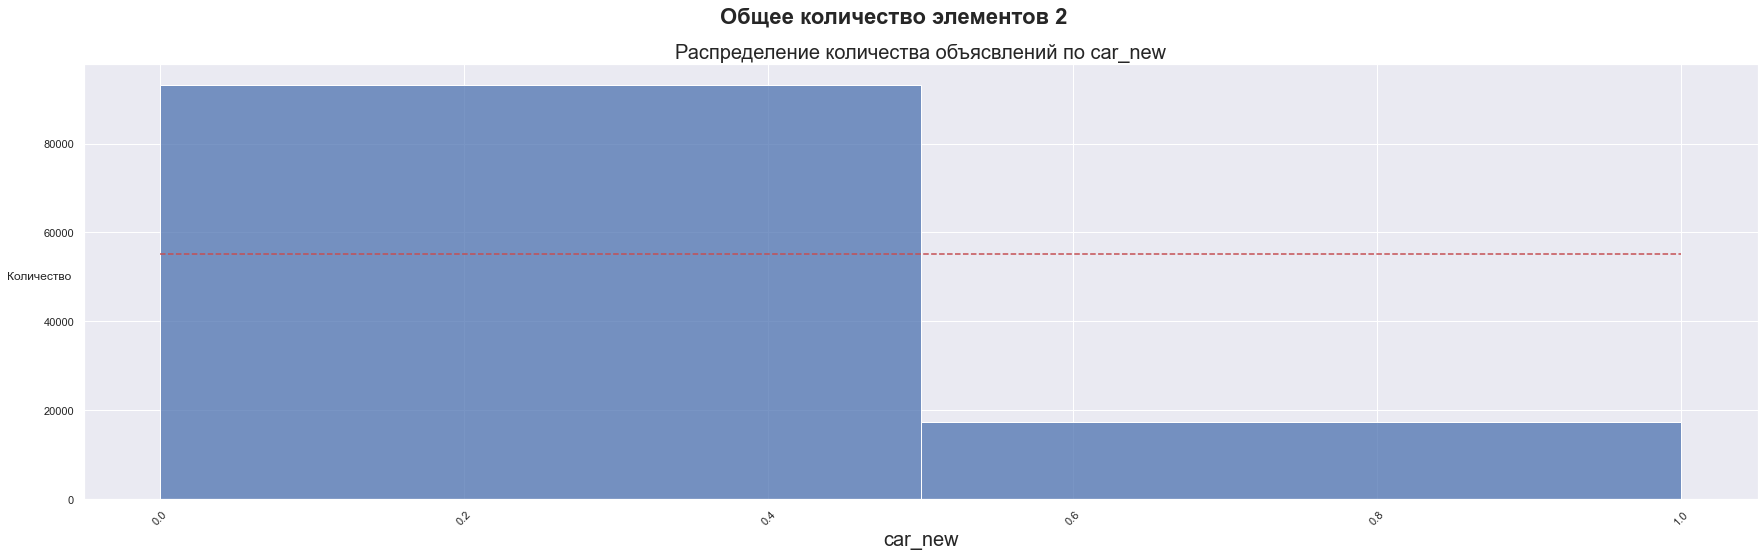

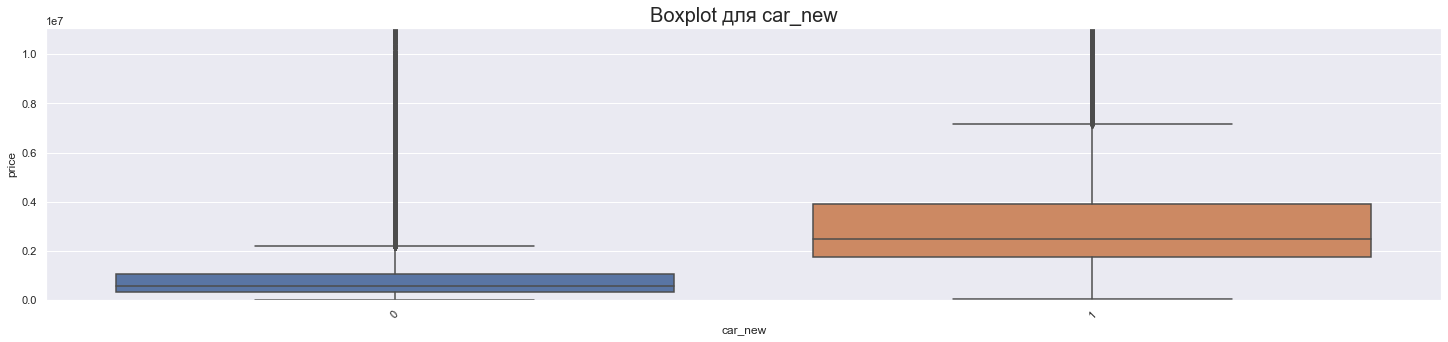

In [552]:
analiz_catigarial_feature(data, 'car_new', 1)

**Вывод**  - этот признак  напрямую влияет на цену, цена меньше с авто б/у.

# driverSide
строна Руля

In [553]:
definePopularColumn(data, 'driverSide', 1)

{'LEFT': 108350, 'RIGHT': 2085}

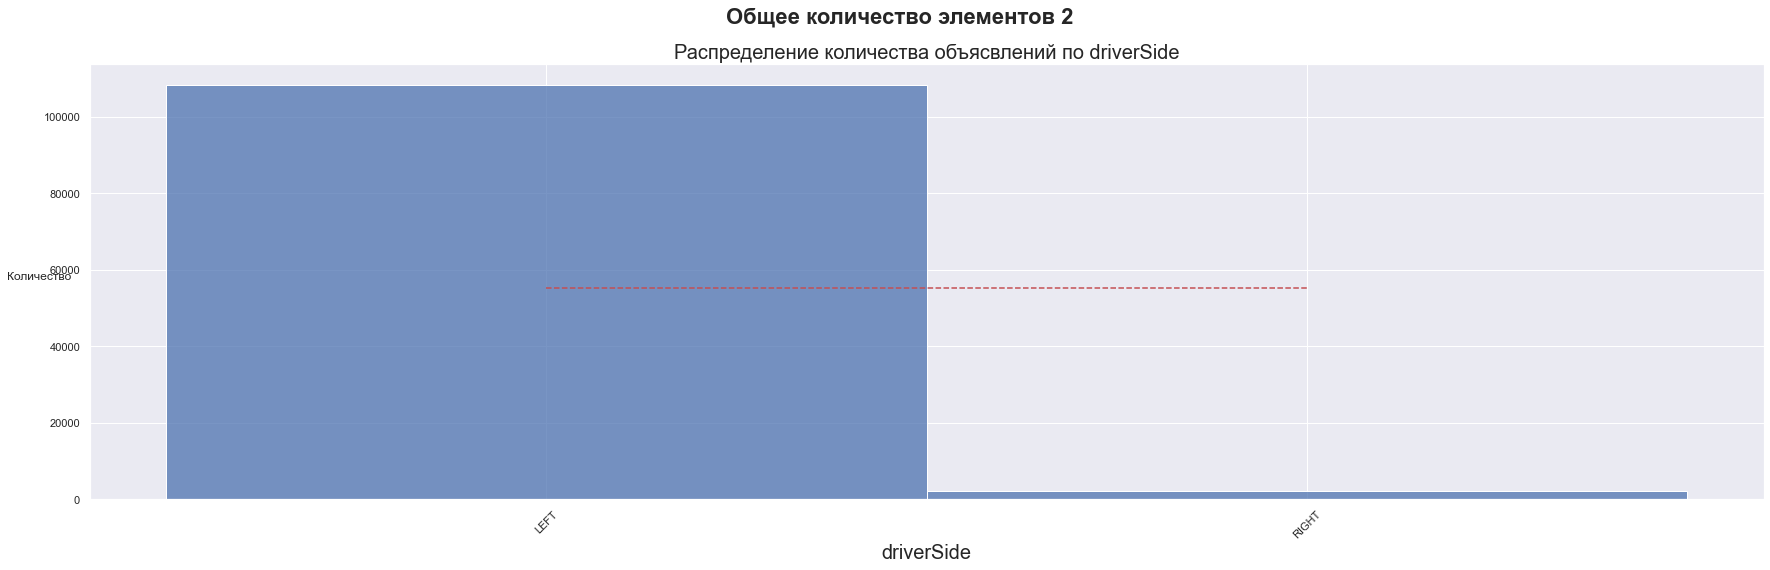

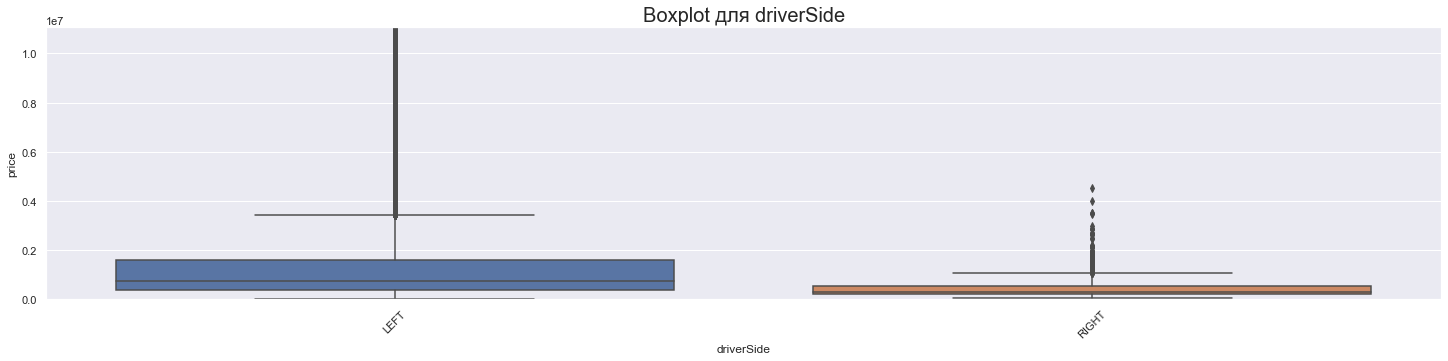

In [554]:
analiz_catigarial_feature(train, 'driverSide', 1)

**Вывод**  - этот признак  напрямую влияет на цены.

# pts
строка ПТС

In [555]:
definePopularColumn(data, 'pts', 1)

{'ORIGINAL': 81705, 'DUPLICATE': 28730}

In [556]:
definePopularColumn(data, 'pts', 0)

{'ORIGINAL': 30098, 'DUPLICATE': 4587}

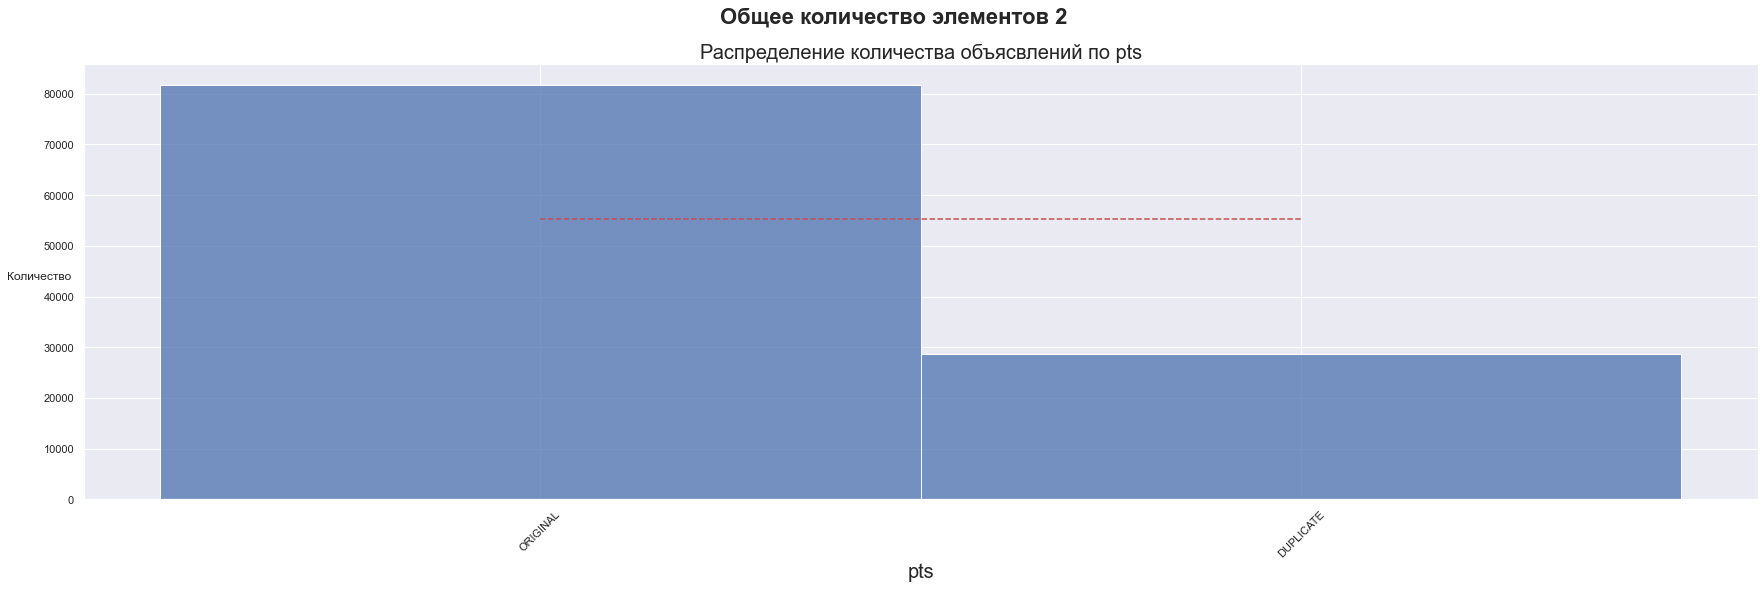

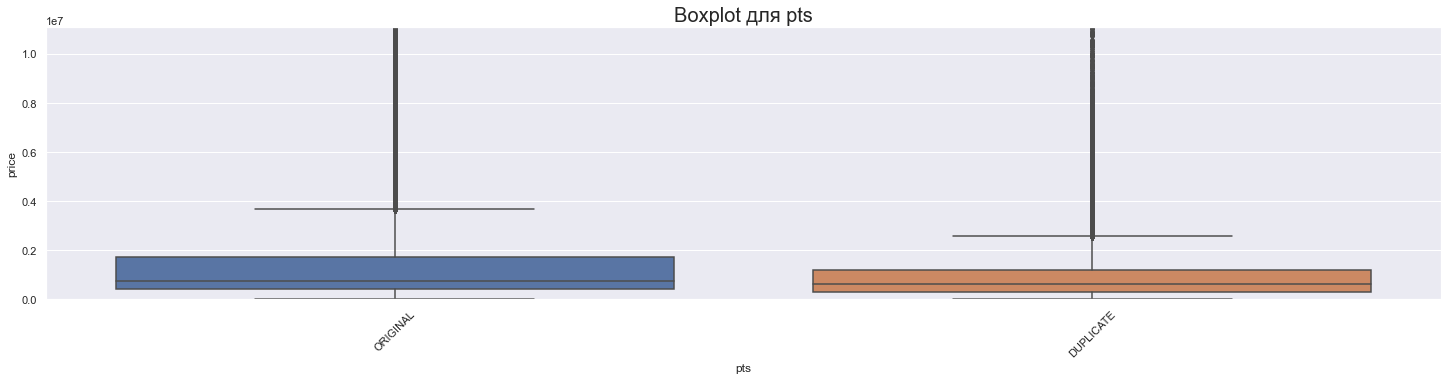

In [557]:
analiz_catigarial_feature(train, 'pts', 1)

# Предварительный анализ 

Кореляции и влияние на целевой показатель 

In [558]:
X = data.query('sample == 1')

In [586]:
target_col = ['price']
target_col_log  = ['price_log']

bin_cols = ['car_new', 'driverSide', 'pts']

cat_cols = ['brand', 'bodyType', 'color', 'fuelType',  'drivertrain', 'vendor', 'ownersCount',
         'numberOfDoors', 'vehicleTransmission']


num_cols = ['modelDate', 'productionDate',  'production_model', 'enginePower', 'engineDisplacement', 'car_age', 
            'mileage', 'racing', 'descrip_lenth', 'mileage_year']


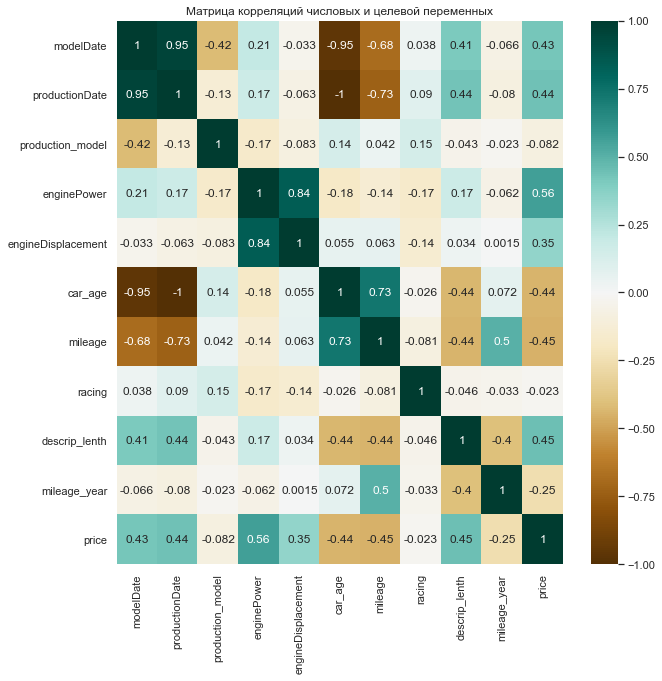

In [587]:
# Построим матрицу корреляций
fig, axes = plt.subplots(figsize=(10, 10))
data_pic = data.query('sample == 1')
heatmap = sns.heatmap(data_pic[num_cols + target_col].corr(), vmin=-1,
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций числовых и целевой переменных')
plt.show()

In [588]:
num_cols.remove('modelDate')
num_cols.remove('productionDate')
num_cols.remove('car_age')
num_cols.remove('engineDisplacement')

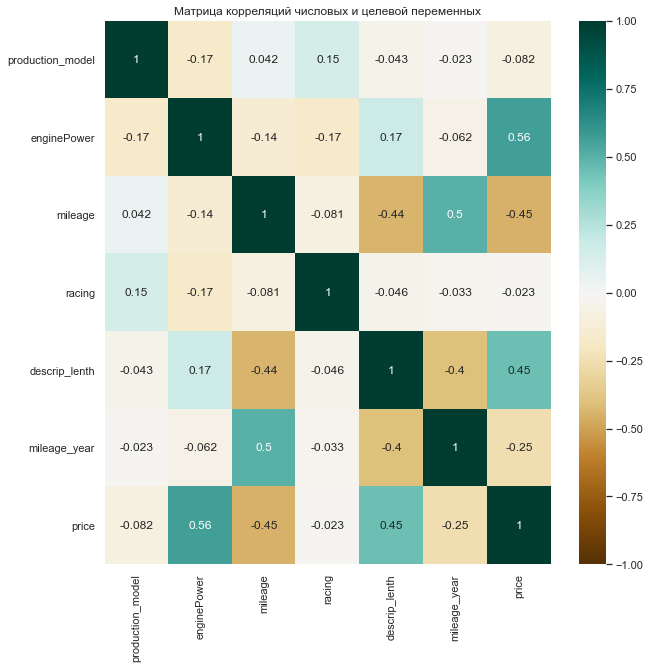

In [589]:
fig, axes = plt.subplots(figsize=(10, 10))
data_pic = data.query('sample == 1')
heatmap = sns.heatmap(data_pic[num_cols + target_col].corr(), vmin=-1,
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций числовых и целевой переменных')
plt.show()

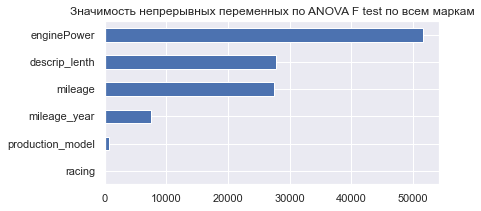

In [590]:
fig, ax = plt.subplots(figsize=(6, 3))
data_train = data[data['sample'] == 1].copy()
imp_num = pd.Series(f_regression(data_train[num_cols], data_train['price'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(
    kind='barh', title='Значимость непрерывных переменных по ANOVA F test по всем маркам')
plt.show()

In [591]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# Убедимся в преобразовании
data[bin_cols].sample(10)

car_new  driverSide  pts
7755          0           0    1
19005         0           0    1
29738         0           0    1
99769         0           0    0
12721         0           0    1
108279        0           0    1
22581         0           0    1
69590         0           0    1
96175         0           0    1
88657         0           0    0

## категориальные переменные

In [592]:
# Labels encoding for all
for colum in cat_cols:
    data[colum] = data[colum].astype('category').cat.codes
    

In [593]:
data[cat_cols].sample(10)

brand  bodyType  color  fuelType  drivertrain  vendor  ownersCount  \
117770     55        15     15         0            2       3            1   
73551      49         1      6         0            2       4            3   
62536      37         1     15         4            2       2            3   
122665     55        10      0         4            2       3            2   
102696     79         1      2         0            1       4            1   
106821     80        20      6         0            1       3            2   
41435       4        15     15         0            0       3            3   
768        72         1      6         0            2       3            3   
85285      60         1      6         0            2       4            1   
102994     79         1     15         0            2       4            0   

        numberOfDoors  vehicleTransmission  
117770              2                    0  
73551               3                    0  
62536               3                    0  
122665              2                    0  
102696              3                    1  
106821              3                    2  
41435               2                    0  
768                 3                    3  
85285               3                    1  
102994              3                    1

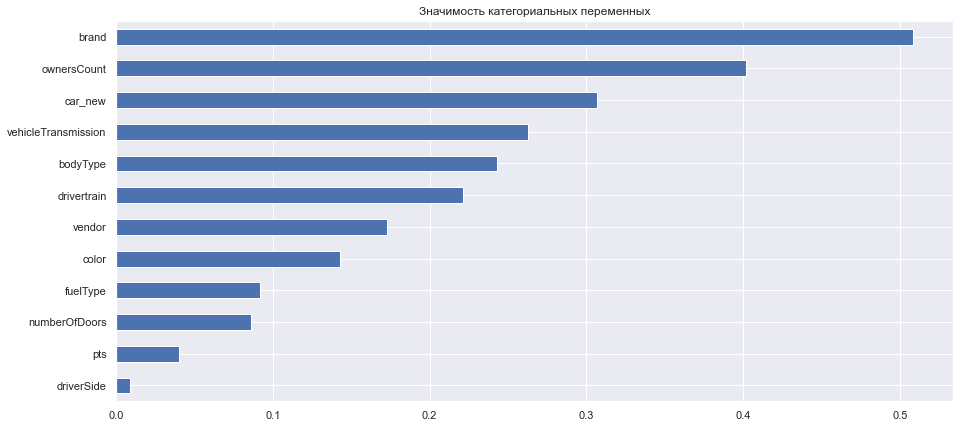

In [594]:
# Оценим значимость бинарных и категориальных признаков
fig, ax = plt.subplots(figsize=(15, 7))
data_train = data[data['sample'] == 1].copy()

imp_cat = pd.Series(mutual_info_regression(
    data_train[list(set(bin_cols+cat_cols))], data_train['price'], discrete_features=True), index=list(set(bin_cols+cat_cols)))
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Значимость категориальных переменных')
plt.show()

## Разделение данных


In [595]:
y = data.query('sample == 1')['price']

In [596]:
X = data.query('sample == 1')[num_cols + bin_cols + cat_cols ]
X_sub = data.query('sample == 0')[num_cols + bin_cols + cat_cols ]

In [597]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [598]:
X_train.columns

Index(['production_model', 'enginePower', 'mileage', 'racing', 'descrip_lenth',
       'mileage_year', 'car_new', 'driverSide', 'pts', 'brand', 'bodyType',
       'color', 'fuelType', 'drivertrain', 'vendor', 'ownersCount',
       'numberOfDoors', 'vehicleTransmission'],
      dtype='object')

# CatBoost

In [599]:
model = CatBoostRegressor(iterations = 1000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         )

model.save_model('catboost_single_model_baseline.model')

In [600]:
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 19.86%


## LazyPredict

In [602]:
import lazypredict

from lazypredict.Supervised import LazyRegressor

In [ ]:
mae = mean_absolute_error
regr=LazyRegressor(verbose=0,predictions=True, custom_metric=mae)

models, predictions=regr.fit(X_train, X_test, np.log(y_train), np.log(y_test))


 24%|██▍       | 10/42 [00:50<04:08,  7.78s/it]

In [ ]:
models

## Label Encoding

In [21]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

<ipython-input-21-1e582092c57d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sample'] = 1 # помечаем где у нас трейн
<ipython-input-21-1e582092c57d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['sample'] = 0 # помечаем где у нас тест


In [22]:
for colum in ['bodyType', 'brand', 'engineDisplacement']:
    data[colum] = data[colum].astype('category').cat.codes

In [23]:
data

bodyType  brand  productionDate  engineDisplacement  mileage  sample
0            28     56            2014                  53    74000       0
1            28     56            2017                  57    60563       0
2            28     56            2014                  59    88000       0
3            28     56            2014                  57    95000       0
4            28     56            2012                  59    58536       0
...         ...    ...             ...                 ...      ...     ...
43963         1      4            2013                  22   159807       1
43964        13      4            2020                  22    14782       1
43965         1      4            2019                  22    68272       1
43966         1      4            2021                  12        0       1
43967         1      4            2021                  33        0       1

[43968 rows x 6 columns]

In [24]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

## Train Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [26]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [27]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: nan%


# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [28]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [29]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 20.59%


Вот так просто со старта, даже не трогая сами данные и не подбирая настройки catboosta, получаем модель с уровнем ошибки в 18%!

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [30]:
np.log(y_train)

7265    14.213678
3183    12.765688
7160    14.711599
2740    13.756822
6056    12.676076
          ...    
5944    13.592367
5383    12.506177
5588    14.212943
891     13.916260
7579    13.752571
Name: price, Length: 7425, dtype: float64

In [31]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [32]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [33]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 18.11%


Как видим точность возросла до 15%, а что будет на ЛБ?

# Submission

In [34]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026  3.108330e+06
1  1100549428  4.468739e+06
2  1100658222  2.938761e+06
3  1100937408  2.789252e+06
4  1101037972  2.319839e+06
5  1100912634  1.527251e+06
6  1101228730  1.788614e+06
7  1100165896  1.313588e+06
8  1100768262  7.087194e+06
9  1101218501  2.525192e+06

В итоге получили **MAPE 27%** на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing